In [2]:
# loading libraries

library(ggplot2)
library(glue)
library(tidyverse)
library(gridExtra)
library(latex2exp)
library(moments)
library(rjags)
library(runjags)
library(rstan)
library(StanHeaders)
library(tibble)
library(dplyr)
library(ggpubr)
library(scales)
library(lubridate)
library(lobstr)
library(parallel)
library(tidybayes)
library(HDInterval)

In [3]:
options(mc.cores = parallel::detectCores())

In [4]:
parallel::detectCores()

[1] 8

In [5]:
rstan_options(auto_write = TRUE)

In [108]:
# plot settings

std_width  <- 18
std_height <- 12
options(repr.plot.width = std_width, repr.plot.height = std_height)

In [7]:
# plot colours

color_palette <- c( "#003f5c",
                    "#58508d",
                    "#bc5090",
                    "#ff6361",
                    "#ffa600"
                    )

In [107]:
# useful functions

# plot functions

plot_mh <- function(chain, x, y, norm_fact, burnin, thinning, t) {

    details1 <- glue("Burn-in: {burnin}")
    details2 <- glue("Thinning: {thinning}")

    plot_chain <- ggplot() +
           geom_histogram(
            aes(
                x = chain[,2],
                y = after_stat(density),
                fill = "Posterior sampling"
            ),
            bins = 100
           ) +
           geom_line(
            aes(
                x = x,
                y = y/(norm_fact$value),
                color = "Analytic posterior"
            ),
            linewidth = 2
           ) +
           annotate(
            geom = "text",
            x = 7.5,
            y = 0.25,
            label = details1,
            color = "#524e4e",
            size = 7
           ) +
           annotate(
            geom = "text",
            x = 7.5,
            y = 0.24,
            label = details2,
            color = "#524e4e",
            size = 7
           ) +
           theme_bw() +
           theme( legend.position = "top",
           plot.title = element_text(size = 24, hjust = 0.5),
           axis.title = element_text(size = 20),
           axis.text  = element_text(size = 18),
           legend.title = element_text(size = 18, hjust = 0.5),
           legend.text  = element_text(size = 20),
           panel.grid.major.y = element_line( color = alpha("black",0.2),
                                           linewidth = 0.3,
                                           linetype = 2 ),
           panel.grid.major.x = element_line( color = alpha("black",0.2),
                                           linewidth = 0.3,
                                           linetype = 2 ),
           panel.grid.minor = element_blank(),
           panel.background = element_blank(),
           legend.background = element_rect( fill = "white",
                                           linewidth = 0.5, 
                                           linetype = "solid", 
                                           colour = "white" ) ) +
           labs( x = expression(theta), 
               y = "probability density", 
               title = if(t) {"Posterior sampling with Metropolis-Hastings algorithm for MCMC - Norm(0,1) as random-walk candidate density"} ) +
           scale_color_manual(
            name = "",
            values = c("Analytic posterior" = color_palette[4])
           ) + 
           scale_fill_manual( name = "",
                           values = c("Posterior sampling" = color_palette[2])) +
           scale_x_continuous(n.breaks = 8)

    return(plot_chain)

}

autoc_plot <- function(mylags, y_a, burnin, thinning, t) {

    details1 <- glue("Burn-in: {burnin}")
    details2 <- glue("Thinning: {thinning}")

    plot_autoc <- ggplot() + 
                 geom_point(
                    aes(
                        x = mylags,
                        y = y_a
                    ),
                    size = 2,
                    color = color_palette[1]
                 ) +
                 annotate(
                    geom = "text",
                    x = max(mylags)-20*max(mylags)/100,
                    y = 0.75,
                    label = details1,
                    color = "#524e4e",
                    size = 8
                 ) +
                 annotate(
                    geom = "text",
                    x = max(mylags)-20*max(mylags)/100,
                    y = 0.7,
                    label = details2,
                    color = "#524e4e",
                    size = 8
                 ) +
                 theme_bw() +
                theme( legend.position = "top",
                plot.title = element_text(size = 28, hjust = 0.5),
                axis.title = element_text(size = 20),
                axis.text  = element_text(size = 18),
                legend.title = element_text(size = 18, hjust = 0.5),
                legend.text  = element_text(size = 20),
                panel.grid.major.y = element_line( color = alpha("black",0.2),
                                                linewidth = 0.3,
                                                linetype = 2 ),
                panel.grid.major.x = element_line( color = alpha("black",0.2),
                                                linewidth = 0.3,
                                                linetype = 2 ),
                panel.grid.minor = element_blank(),
                panel.background = element_blank(),
                legend.background = element_rect( fill = "white",
                                                linewidth = 0.5, 
                                                linetype = "solid", 
                                                colour = "white" ) ) +
                labs( x = "lag", 
                    y = "ACF", 
                    title = if(t) {"Auto-correlation function for the chain - sigma = 1"} ) +
                scale_x_continuous(n.breaks = 10)

    return(plot_autoc)
}

runjags_plot <- function(results, vaccine, y) {

    ptitle <- paste("Posterior Distribution of the % Difference in Infection Rate - JAGS - ", vaccine, sep = "")
    mean_label <- glue("Mean = {round(results$mean,1)}%")
    
    rplot <- ggplot() + 
             geom_histogram(
                aes(
                    x = results$rate,
                    y = after_stat(density),
                    fill = "Posterior sampling"
                ),
                bins = 100
             ) + 
             geom_segment(
                aes(
                    x = results$mean,
                    y = 0,
                    xend = results$mean,
                    yend = y,
                    color = mean_label
                ),
                linewidth = 2
             ) +
             geom_segment(
                aes(
                    x = results$rmin,
                    y = 0,
                    xend = results$rmax,
                    yend = 0,
                    color = "95% CI"
                ),
                linewidth = 4
             ) +
             theme_bw() +
             theme( legend.position = "right",
             plot.title = element_text(size = 30, hjust = 0.5),
             axis.title = element_text(size = 24),
             axis.text  = element_text(size = 20),
             legend.title = element_text(size = 20, hjust = 0.5),
             legend.text  = element_text(size = 24),
             panel.grid.major.y = element_line( color = alpha("black",0.2),
                                               linewidth = 0.3,
                                               linetype = 2 ),
             panel.grid.major.x = element_line( color = alpha("black",0.2),
                                               linewidth = 0.3,
                                               linetype = 2 ),
             panel.grid.minor = element_blank(),
             panel.background = element_blank(),
             legend.background = element_rect( fill = "white",
                                               linewidth = 0.5, 
                                               linetype = "solid", 
                                               colour = "white" ) ) +
             labs( x = "% difference in infection rate", 
                   y = "probability density", 
                   title = ptitle ) +
             scale_color_manual(
                name = "",
                values = c(color_palette[5], color_palette[4]),
                labels = c("95% CI", mean_label)
             ) + 
             scale_fill_manual( name = "",
                               values = c("Posterior sampling" = color_palette[2])) +
             scale_x_continuous(n.breaks = 8)
    return(rplot)
}

stan_plot <- function(results, vaccine, y) {
    title <- paste("Posterior Distribution of the % Difference in Infection Rate - STAN - ", vaccine, sep = "")
    mean_label <- glue("Mean = {round(results$mean,1)}%")
    splot <- ggplot() + 
             geom_histogram(
                aes(
                    x = results$rate,
                    y = after_stat(density),
                    fill = "Posterior sampling"
                ),
                bins = 80
             ) + 
             geom_segment(
                aes(
                    x = results$mean,
                    y = 0,
                    xend = results$mean,
                    yend = y,
                    color = mean_label
                ),
                linewidth = 2
             ) +
             geom_segment(
                aes(
                    x = results$rmin,
                    y = 0,
                    xend = results$rmax,
                    yend = 0,
                    color = "95% CI"
                ),
                linewidth = 4
             ) +
             theme_bw() +
             theme( legend.position = "right",
             plot.title = element_text(size = 30, hjust = 0.5),
             axis.title = element_text(size = 24),
             axis.text  = element_text(size = 20),
             legend.title = element_text(size = 20, hjust = 0.5),
             legend.text  = element_text(size = 24),
             panel.grid.major.y = element_line( color = alpha("black",0.2),
                                               linewidth = 0.3,
                                               linetype = 2 ),
             panel.grid.major.x = element_line( color = alpha("black",0.2),
                                               linewidth = 0.3,
                                               linetype = 2 ),
             panel.grid.minor = element_blank(),
             panel.background = element_blank(),
             legend.background = element_rect( fill = "white",
                                               linewidth = 0.5, 
                                               linetype = "solid", 
                                               colour = "white" ) ) +
             labs( x = "% difference in infection rate", 
                   y = "probability density", 
                   title = title ) +
             scale_color_manual(
                name = "",
                values = c(color_palette[5], color_palette[4]),
                labels = c("95% CI", mean_label)
             ) + 
             scale_fill_manual( name = "",
                               values = c("Posterior sampling" = color_palette[2])) +
             scale_x_continuous(n.breaks = 8)
    return(splot)
}

# Exercise 1

Given the following un-normalized posterior distribution:

$$ g(\theta | x ) \propto \frac{1}{2}\exp \left[-\frac{(\theta + 3)^2}{2}\right] + \frac{1}{2}\exp \left[-\frac{(\theta - 3)^2}{2}\right] $$

#### 1. Draw a Markow Chain from the posterior distribution using a Metropolis - Hastings algorithm. Use a $\text{Norm}(0,1)$ as random - walk candidate density. Plot the sampled distribution.

In [73]:
# MH algorithm (1D because we have only 1 parameter)

mh_algorithm <- function(func,       # returns log10 of the likelihood function     
                         theta_i,    # initial value of the parameter
                         n_sample,   # sample dimension
                         sigma,      # sd of the Gaussian MCMC sampling pdf
                         thinning,
                         burn_in
                         ) {

    # parameter current value
    theta_cur <- theta_i
    # log10 of the likelihood function
    func_cur <- func(theta_cur)
    # matrix to store sampled values
    func_samp <- matrix(data = NA, nrow = n_sample, ncol = 2)

    # chain iterations
    for(n in 1:n_sample) {

        # proposed value for the parameter
        theta_prop <- rnorm(n = 1, mean = theta_cur, sd = sigma)
        # log10 of the likelihood function
        func_prop <- func(theta_prop)
        # log of Metropolis Ratio
        logMR <- func_prop - func_cur

        # decide whether to accept the proposed value
        if(logMR >= 0 || logMR > log10(runif(1))) {
            theta_cur <- theta_prop
            func_cur <- func_prop
        }

        # store parameter values
        if( n >= burn_in ) {

            if(n%%thinning == 0) {
                func_samp[n,1] <- func_cur
                func_samp[n,2] <- theta_cur
            }
             
        }
        
    }

    # return the matrix removing rows with NA
    return(na.omit(func_samp))
    
}

In [10]:
# test function

test_func <- function(theta) {
    return(dnorm(theta, mean = -3, sd = sqrt(2/pi)) + dnorm(theta, mean = 3, sd = sqrt(2/pi)))
}

# function for MH algorithm

test_func_MH <- function(theta) {
    return(log10(test_func(theta)))
}

In [40]:
# running parameters

# Norm(0,1) as random walk candidate density
theta_init <- 0
sample_sig <- 1

nSample <- 10^6

set.seed(20230604)

In [41]:
# run the chain

chain_MH <- mh_algorithm(
    func = test_func_MH, 
    theta_i = theta_init, 
    n_sample = nSample, 
    sigma = sample_sig^2,
    thinning = 1,
    burn_in = 0
    )

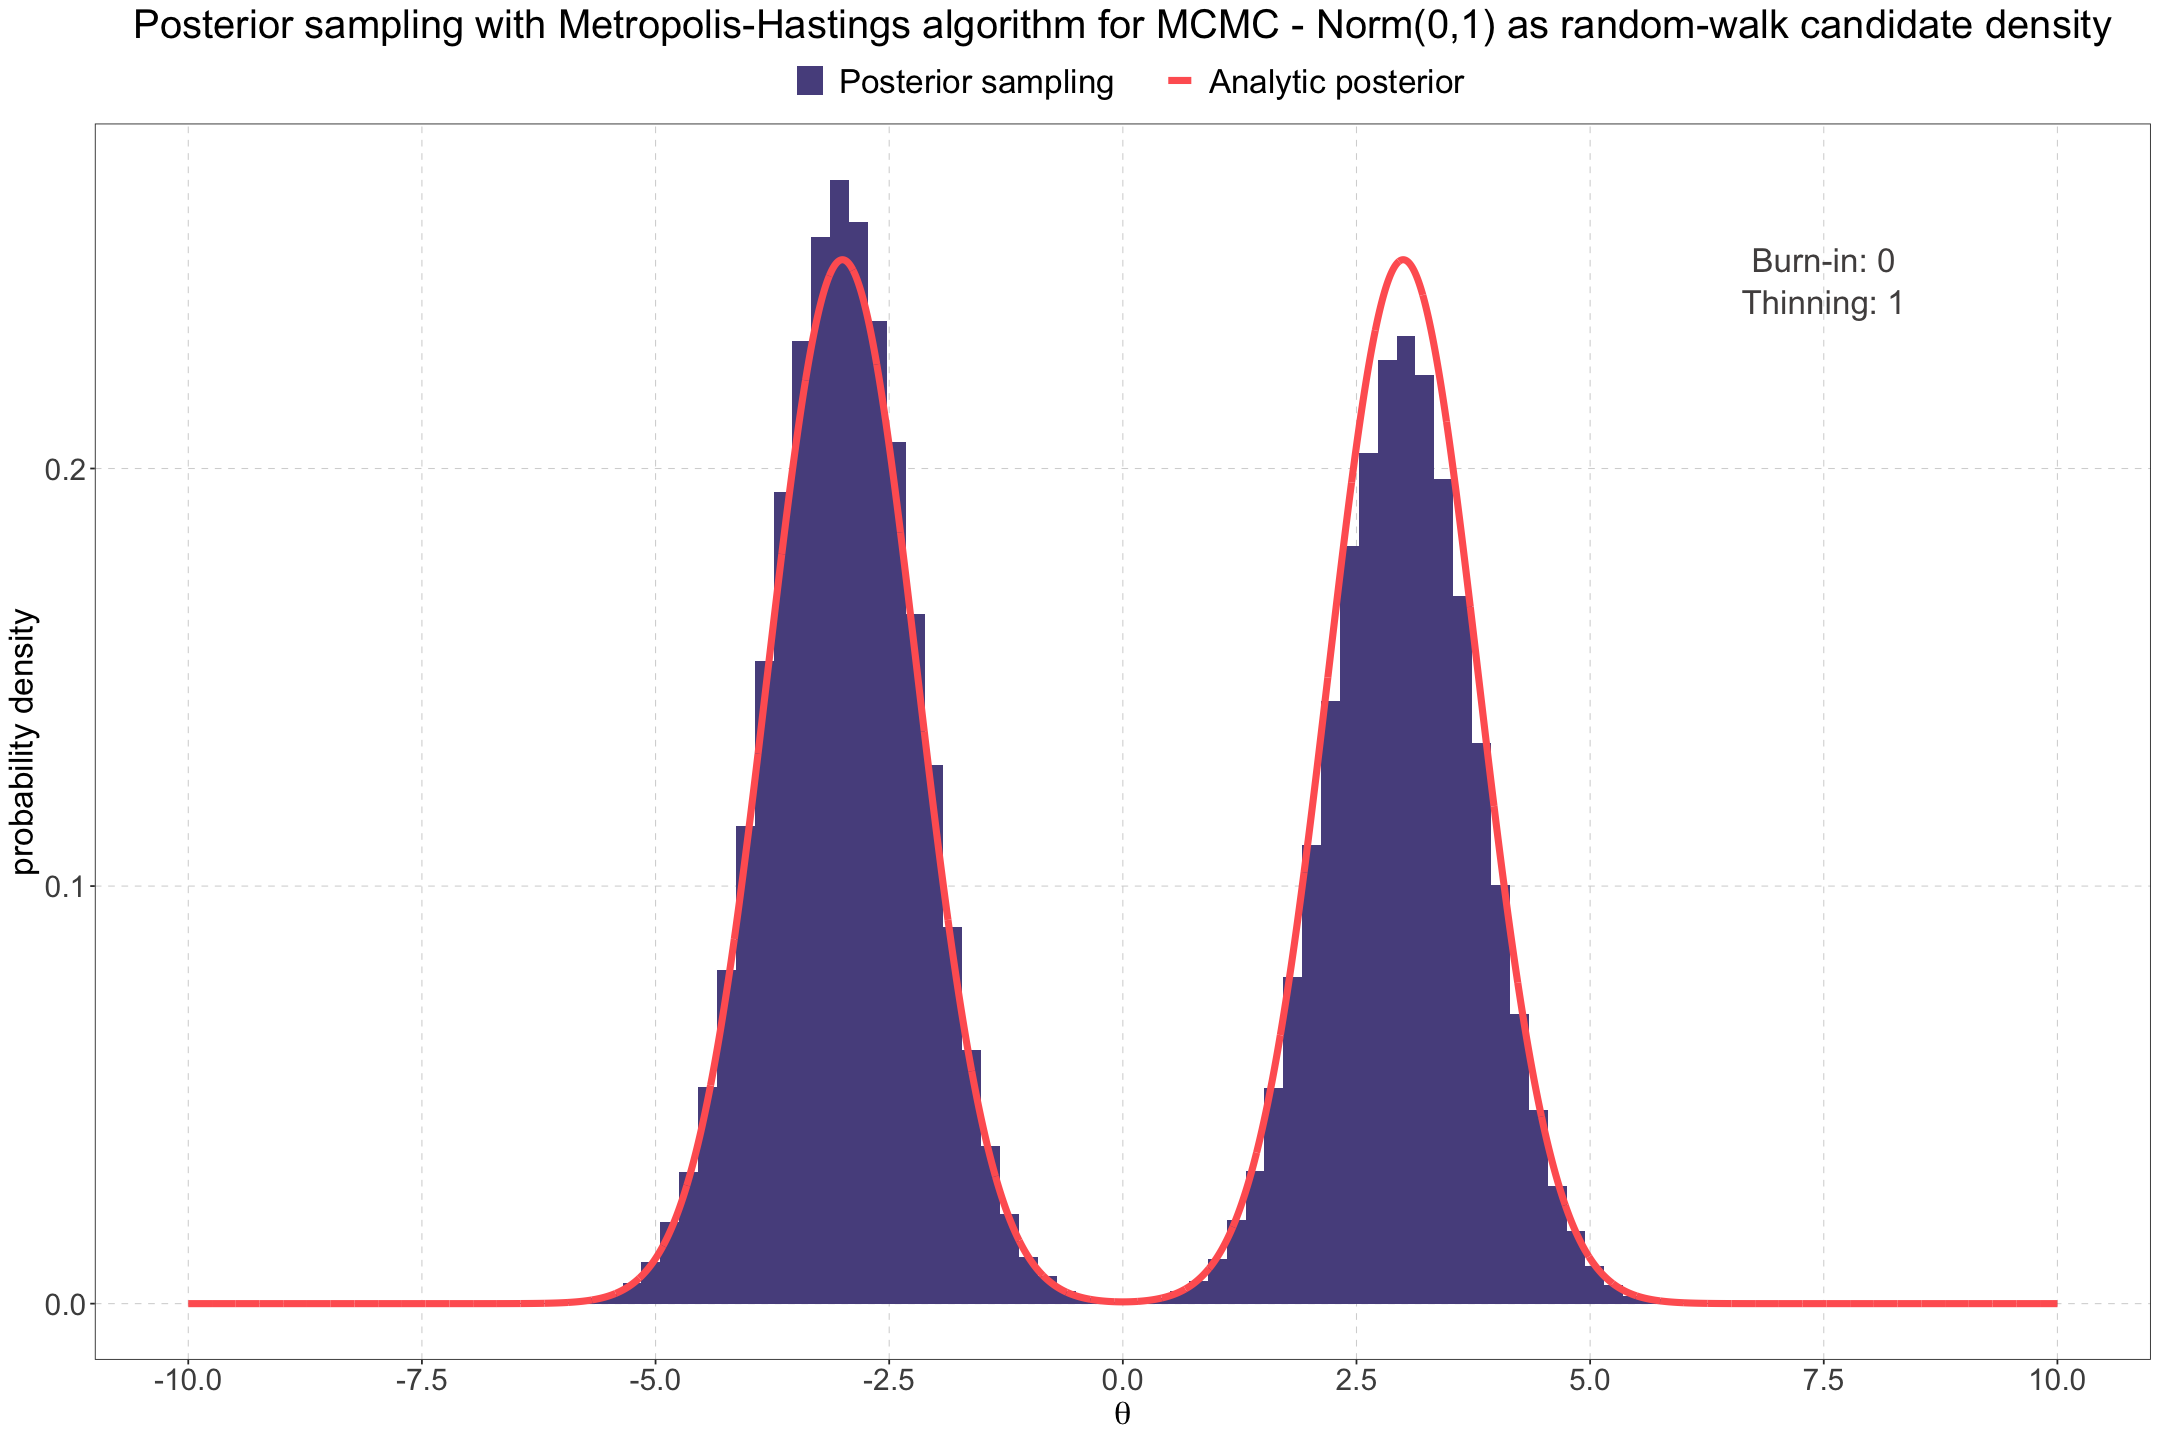

In [109]:
# analytic posterior
x <- seq(-10,10, length.out = 10^4)
y <- test_func(x)

# normalization factor
normF <- integrate(function(x) test_func(x), -10, 10)

# plot
plot_mh(chain_MH, x, y, normF, 0, 1, t = TRUE)

#### 2. Analyze the chain with the `CODA` package and plot the chain autocorrelation

In [15]:
# coda chain
chain_coda <- as.mcmc(chain_MH[,2])

In [46]:
# computing autocorrelation

my_lags <- seq(0, 50000, 1)
y_autoc <- autocorr(chain_coda, lags = my_lags)

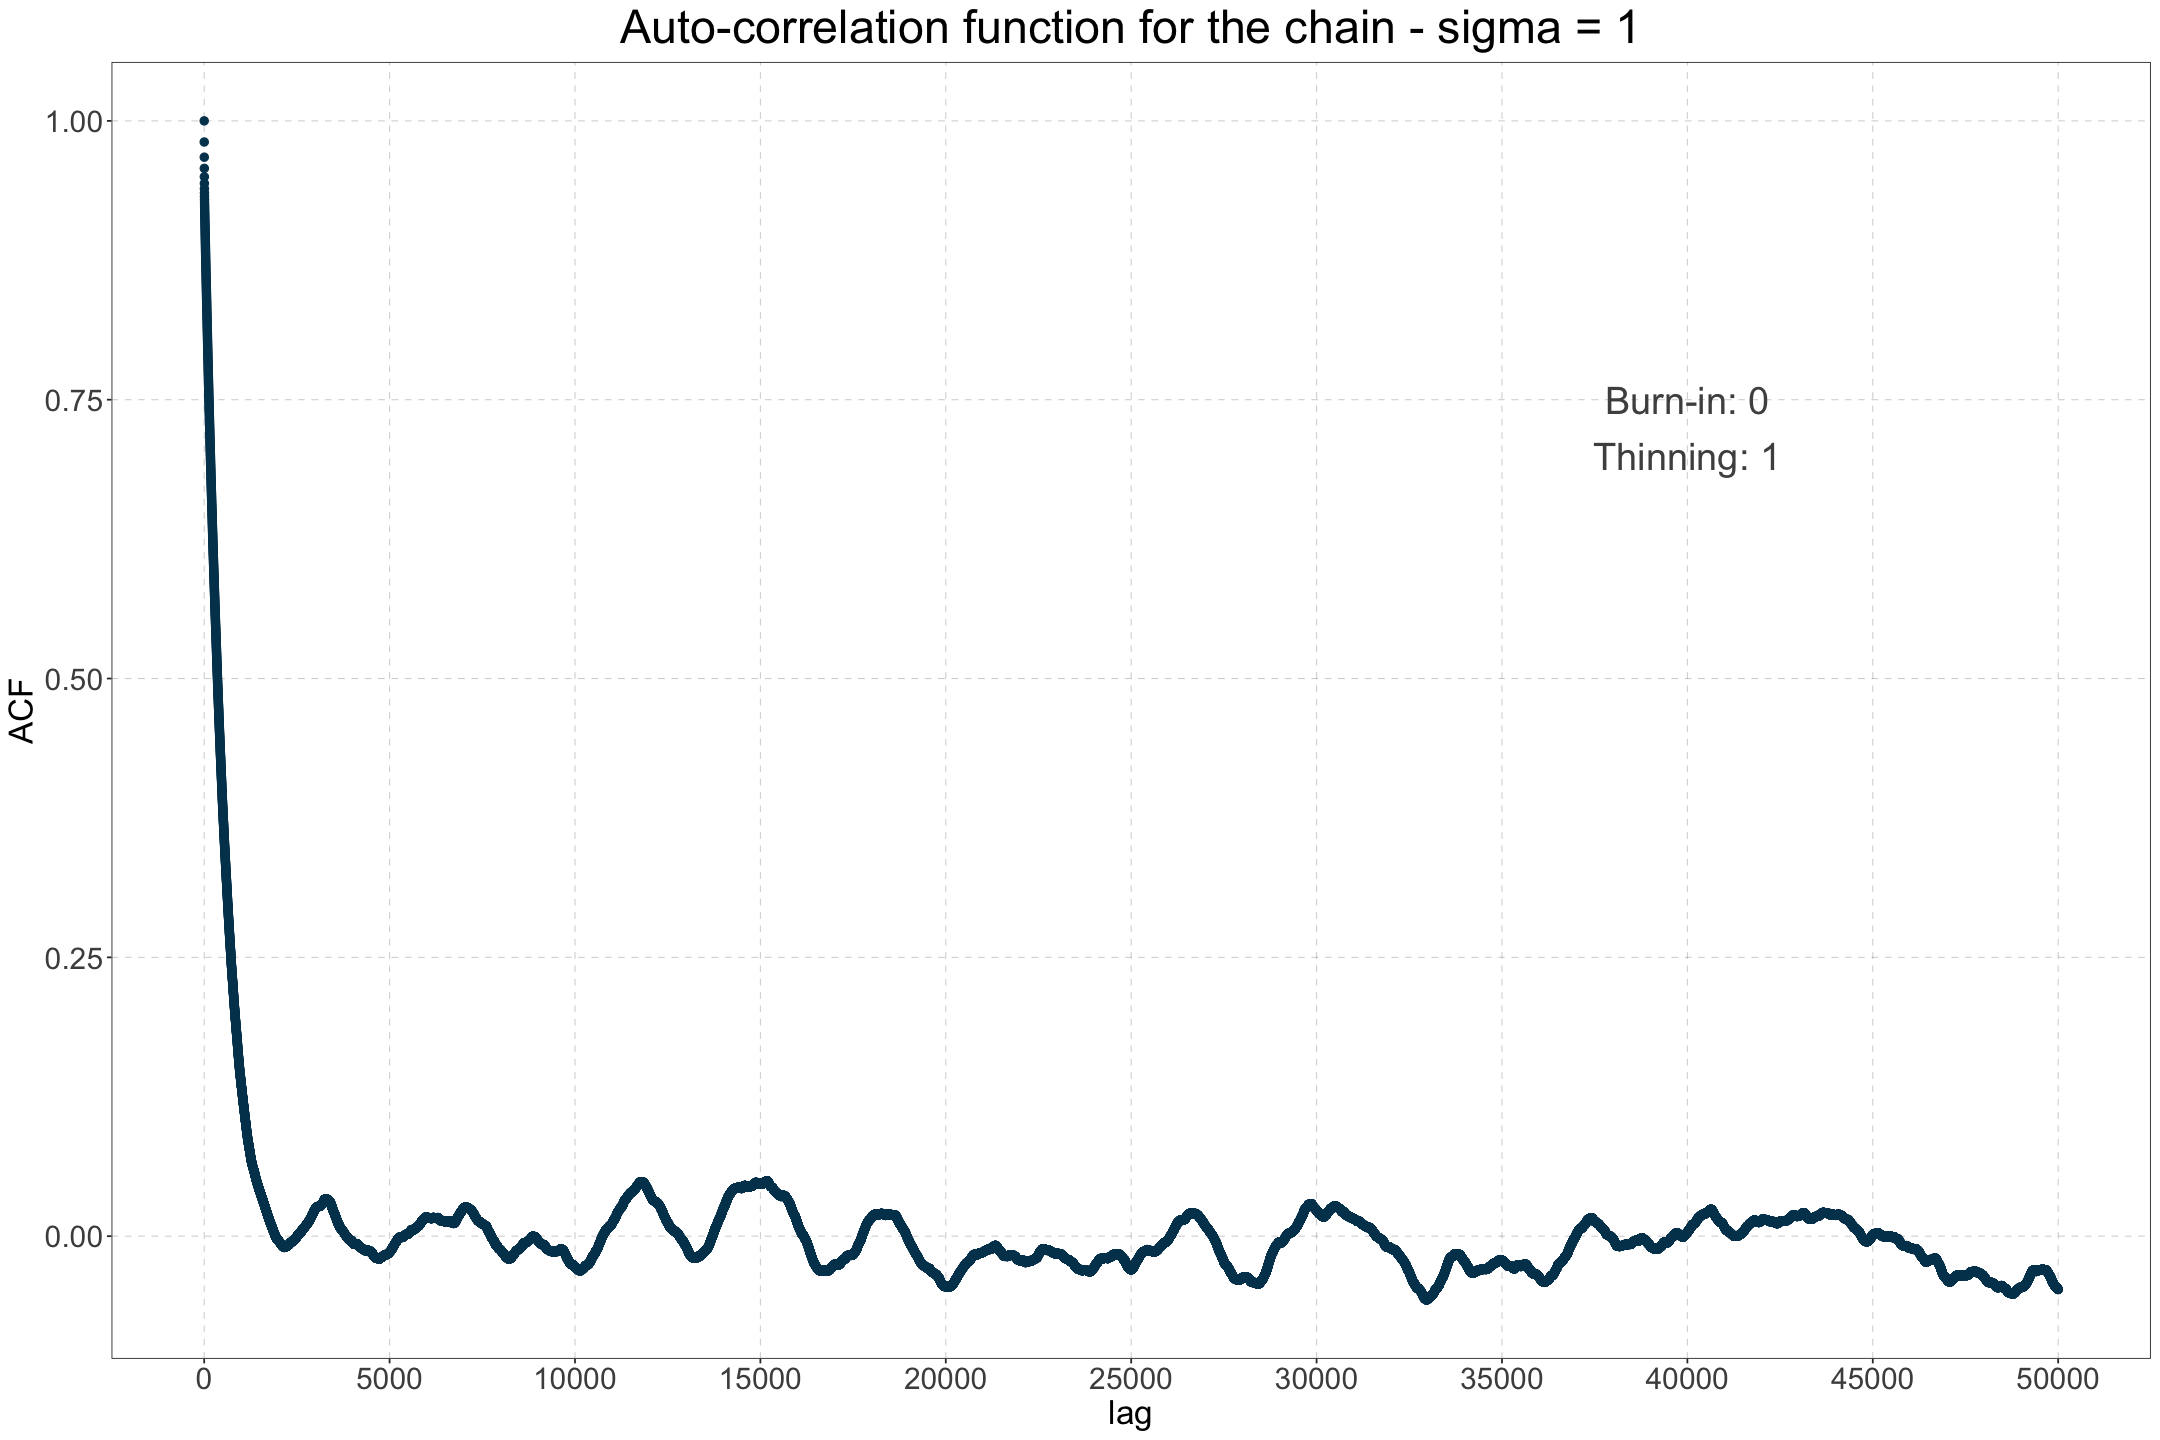

In [110]:
# plot
autoc_plot(my_lags, y_autoc, 0, 1, t = TRUE)

#### 3. Try to use different burn-in cicles and thinning and plot the corresponding posterior distribution and the chain autocorrelation function. What are the best parameters?

In [117]:
# burn-in = 5000, thinning = 25
chain_MH_2 <- mh_algorithm(
    func = test_func_MH,
    theta_i = theta_init,
    n_sample = nSample,
    sigma = sample_sig^2,
    thinning = 25,
    burn_in = 5000
)

# coda
chain_coda_2 <- as.mcmc(chain_MH_2[,2])
my_lags_2 <- seq(0, 1000, 1)
y_autoc_2 <- autocorr(chain_coda_2, lags = my_lags_2)

In [118]:
# burn-in = 5000, thinning = 50
chain_MH_3 <- mh_algorithm(
    func = test_func_MH,
    theta_i = theta_init,
    n_sample = nSample,
    sigma = sample_sig^2,
    thinning = 50,
    burn_in = 5000
)

# coda
chain_coda_3 <- as.mcmc(chain_MH_3[,2])
my_lags_3 <- seq(0, 1000, 1)
y_autoc_3 <- autocorr(chain_coda_3, lags = my_lags_3)

In [119]:
# burn-in = 1000, thinning = 100
chain_MH_4 <- mh_algorithm(
    func = test_func_MH,
    theta_i = theta_init,
    n_sample = nSample,
    sigma = sample_sig^2,
    thinning = 100,
    burn_in = 1000
)

# coda
chain_coda_4 <- as.mcmc(chain_MH_4[,2])
my_lags_4 <- seq(0, 1000, 1)
y_autoc_4 <- autocorr(chain_coda_4, lags = my_lags_4)

In [120]:
# burn-in = 1000, thinning = 200
chain_MH_5 <- mh_algorithm(
    func = test_func_MH,
    theta_i = theta_init,
    n_sample = nSample,
    sigma = sample_sig^2,
    thinning = 200,
    burn_in = 1000
)

# coda
chain_coda_5 <- as.mcmc(chain_MH_5[,2])
my_lags_5 <- seq(0, 1000, 1)
y_autoc_5 <- autocorr(chain_coda_5, lags = my_lags_5)

In [121]:
# plot settings

std_width  <- 35
std_height <- 18
options(repr.plot.width = std_width, repr.plot.height = std_height)

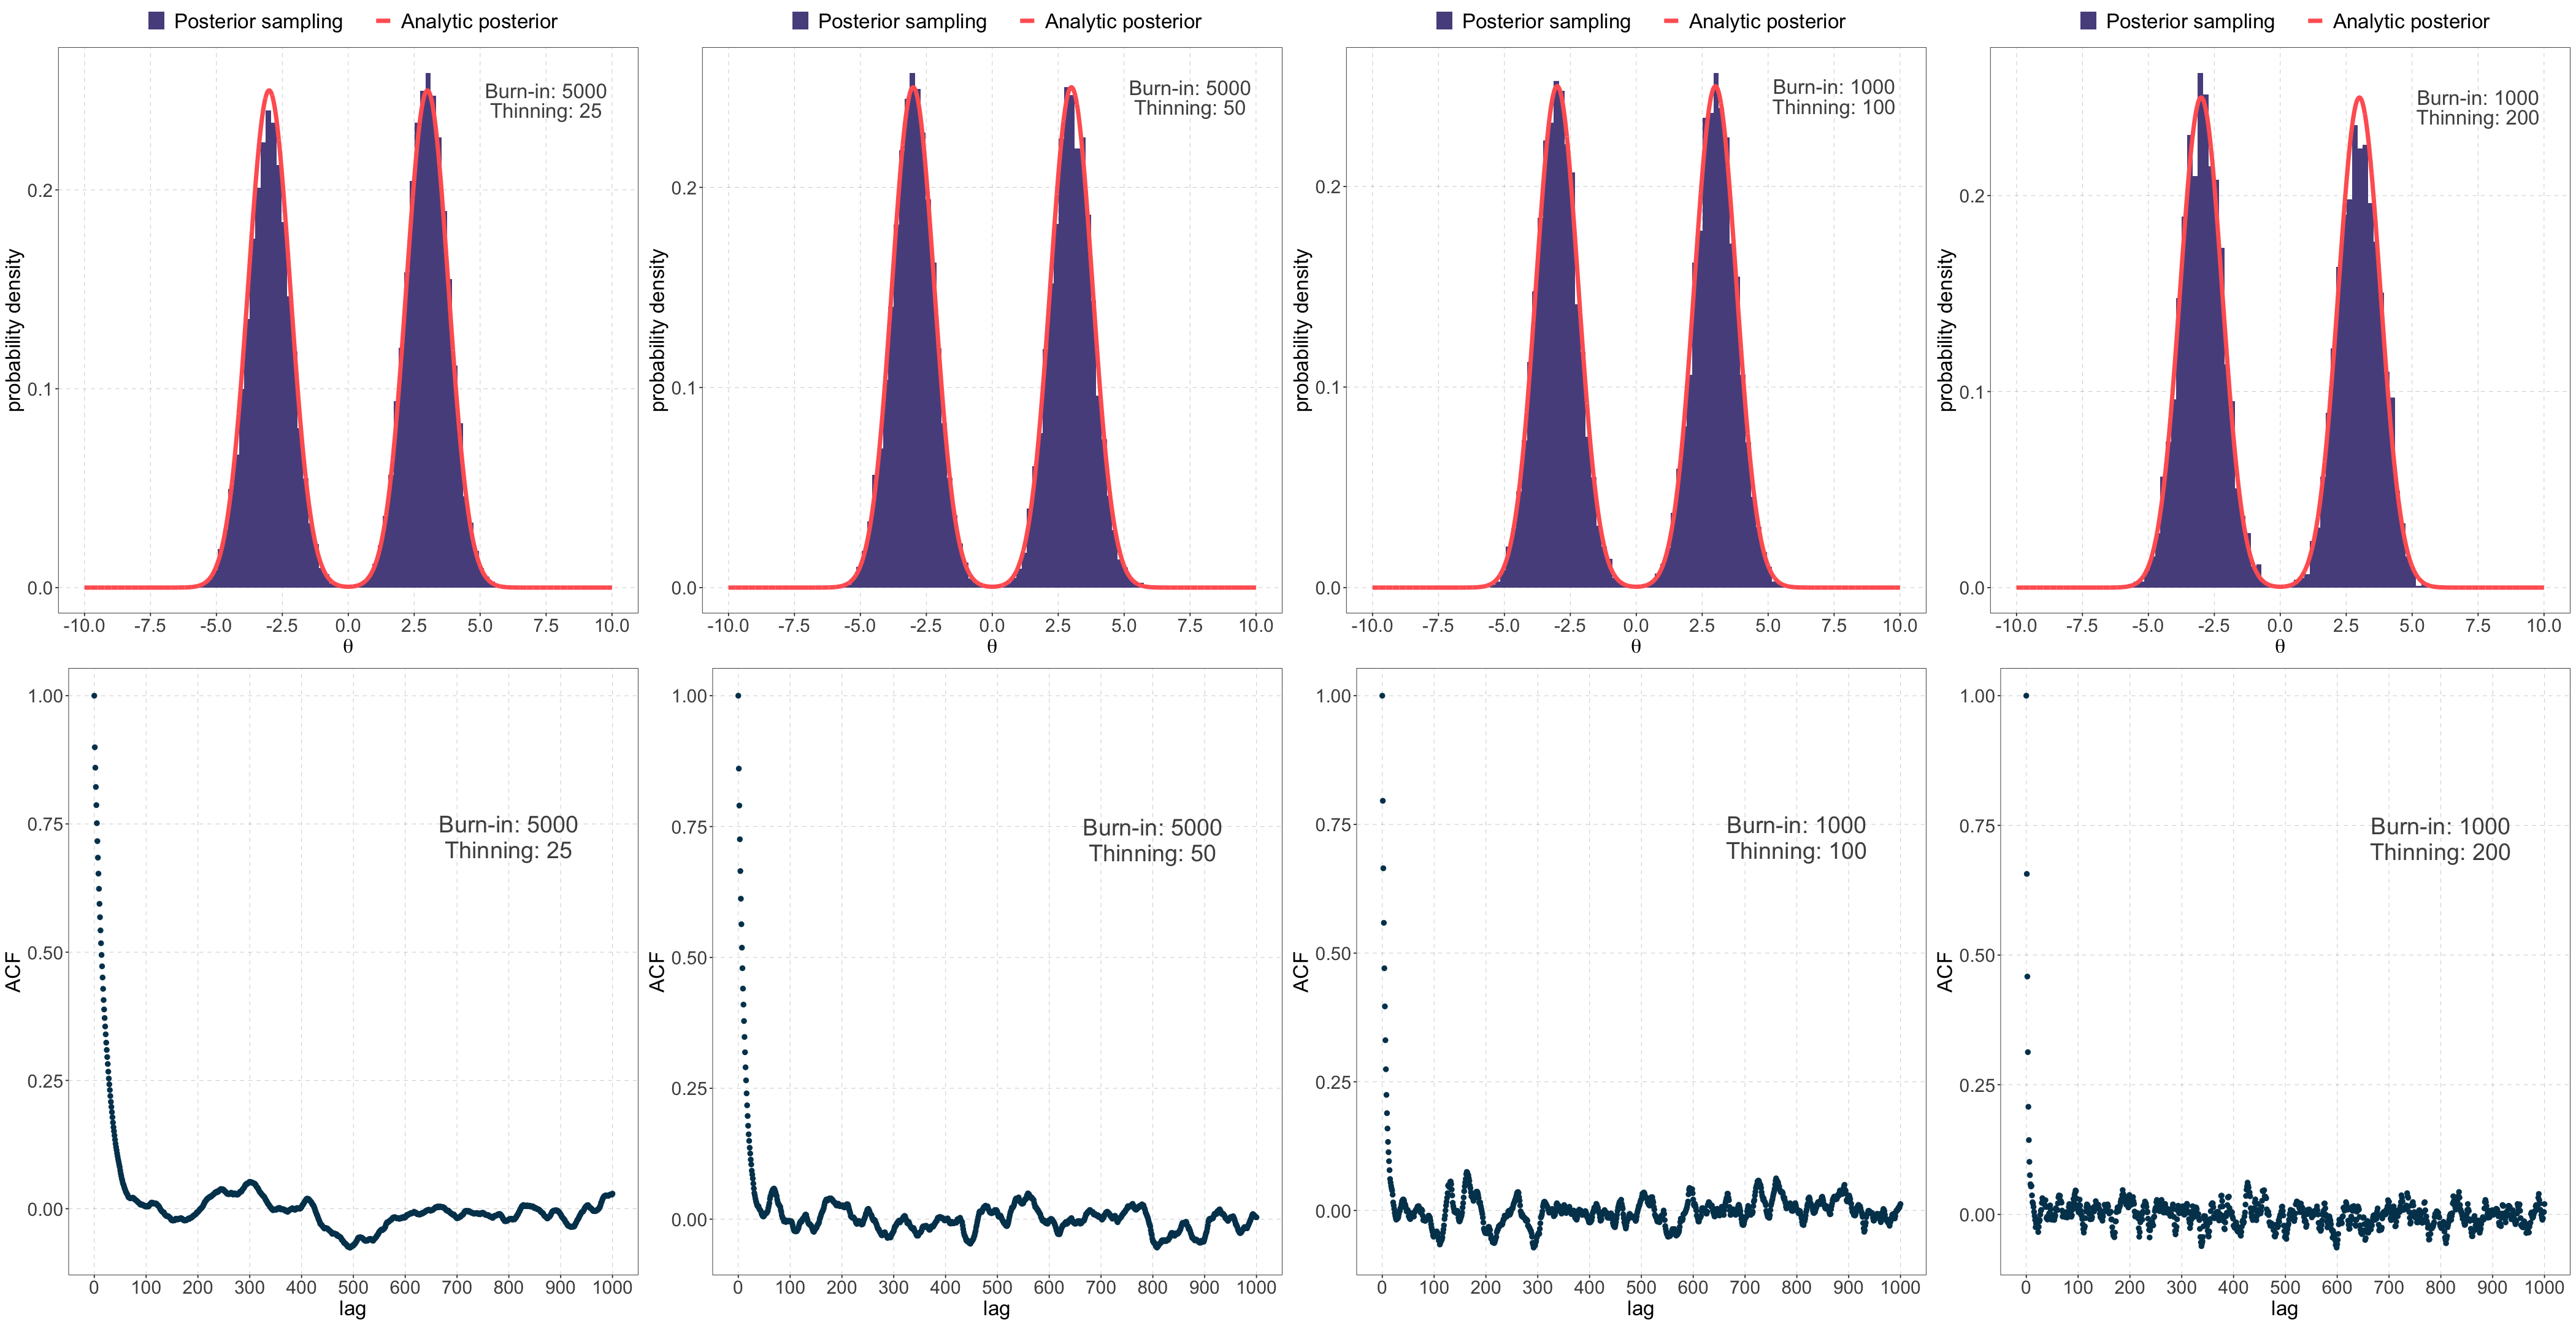

In [122]:
# plots
grid.arrange(
    plot_mh(chain_MH_2, x, y, normF, 5000, 25, t = FALSE),
    plot_mh(chain_MH_3, x, y, normF, 5000, 50, t = FALSE), 
    plot_mh(chain_MH_4, x, y, normF, 1000, 100, t = FALSE), 
    plot_mh(chain_MH_5, x, y, normF, 1000, 200, t = FALSE), 
    autoc_plot(my_lags_2, y_autoc_2, 5000, 25, t = FALSE),
    autoc_plot(my_lags_3, y_autoc_3, 5000, 50, t = FALSE),
    autoc_plot(my_lags_4, y_autoc_4, 1000, 100, t = FALSE),
    autoc_plot(my_lags_5, y_autoc_5, 1000, 200, t = FALSE), 
    nrow = 2, 
    ncol = 4
)

From the plot, we can observe that the best parameters are: 
* burn-in = 1000, thinning = 100

since the posterior is well sampled and the ACF is good.

------------------

# Exercise 2

The EMA (European Medicines Agency) has authorized a list of COVID-19 vaccines, after having performed a scientific evaluation of the vaccines efficacy. The following vaccines are corrently authorized for use in EU:
- Comirnaty (BioNTech and Pfizer)
- VCOVID-19 Vaccine Valneva
- Nuvaxovid (Novavax)
- Spikevax (Moderna)
- Vaxzeviria (AstraZeneca)
- Jcovden (Janssen)
- VidPrevtyn Beta (Sanofi Pasteur)
- Bimervax (HIPRA)

Analyze the initial test data reported on the EMA website for the following early vaccines: Jcovden, Moderna, AstraZeneca. Create a MCMC with JAGS or STAN for the efficacy of each vaccine. Infere the $95\%\,\text{CI}$.

First of all, we recall the definition of vaccine effectivness:

*vaccine effectivness is the percent reduction in the frequency of ilness among vaccinated people compared to people not vaccinated*

We will perform analyses with both `STAN` and `runjags` and we will compare their results. In both cases, we choose a $\text{Beta}(3,100)$ as prior for the $\theta$ parameter, that corresponds to the probability of getting COVID infection. We will analyze the infection rate both in vaccinated people and in people who received a placebo, then, we will compare the infection rates to determine the vaccine efficacy. We highlight that the prior choice might be affect the final results on vaccine efficacy with recpect on the published ones by EMA.

#### **Jcovden**

From the EMA we can extract the following information:

- **sample**: over 44 000 people
- **efficiency experiment**: 19 630 people received vaccine, 19 691 people received a placebo; people did not know if they had been given Jcovden or placebo.
- **results**: after 2 weeks, 116 vaccinated people got symptoms, 348 people who received a placebo got symptoms
- **conclusion**: the vaccine had a 67% efficacy

In [124]:
# sample
vaccinated_j <- 19630
placebo_j <- 19691

patient_j <- c( rep("Vaccine", vaccinated_j),
                rep("Placebo", placebo_j) )

# symptoms
pos_v_j <- 116
pos_p_j <- 348

tested_j <- c( rep("Pos", pos_v_j),
               rep("Neg", vaccinated_j-pos_v_j),
               rep("Pos", pos_p_j),
               rep("Neg", placebo_j-pos_p_j))

# organizing data
jcovden_tb <- tibble(tested = tested_j, patient = patient_j)
table(jcovden_tb[[2]], jcovden_tb[[1]])

data_j = list(
    tested = ifelse(jcovden_tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(jcovden_tb$patient)),
    N = nrow(jcovden_tb),
    Nclass = nlevels(factor(jcovden_tb$patient))
)

         
            Neg   Pos
  Placebo 19343   348
  Vaccine 19514   116

In [125]:
# RUNJAGS

chain_j <- run.jags(model = "vaccine_efficacy_model.bug", 
                    sample = 15000,
                    n.chains = 4,
                    method = "parallel",
                    monitor = "theta",
                    data = data_j)

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.2 on Sun Jun  4 14:21:10 2023
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 39321
   Unobserved stochastic nodes: 2
   Total graph size: 78648
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 15000
-------------------------------------------------| 15000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

In [126]:
# percentage difference in infection rates (getting a tibble)

res_j <- tidy_draws(chain_j) %>%
        select('theta[1]':'theta[2]') %>%
        rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
        mutate(
            diff_rate = (Placebo-Vaccine)/Placebo * 100,
            Placebo_percent = Placebo * 100,
            Vaccine_percent = Vaccine * 100
        )

In [127]:
# coda chain results

summary(as.mcmc(res_j))


Iterations = 1:60000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 60000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                     Mean        SD  Naive SE Time-series SE
Placebo          0.017733 0.0009359 3.821e-06      3.821e-06
Vaccine          0.006032 0.0005498 2.245e-06      2.245e-06
diff_rate       65.889929 3.6023899 1.471e-02      1.471e-02
Placebo_percent  1.773260 0.0935857 3.821e-04      3.821e-04
Vaccine_percent  0.603170 0.0549812 2.245e-04      2.245e-04

2. Quantiles for each variable:

                    2.5%       25%       50%       75%     97.5%
Placebo          0.01594  0.017092  0.017718  0.018354  0.019617
Vaccine          0.00501  0.005653  0.006016  0.006395  0.007157
diff_rate       58.37250 63.560582 66.039125 68.404570 72.482588
Placebo_percent  1.59371  1.709220  1.771790  1.835413  1.961720
Vaccine_percent  0.50101  0.565259  0.601568  0.639505  0.715683


In [128]:
# storing results

# getting 95% CI
ci_runjags_j <- hdi(as.mcmc(res_j$diff_rate), prob = 0.95)

results_j_runjags <- NULL
results_j_runjags$rate <- res_j$diff_rate
results_j_runjags$mean <- mean(res_j$diff_rate)
results_j_runjags$rmin <- ci_runjags_j[1]
results_j_runjags$rmax <- ci_runjags_j[2]

In [174]:
# plot settings

std_width  <- 19
std_height <- 12
options(repr.plot.width = std_width, repr.plot.height = std_height)

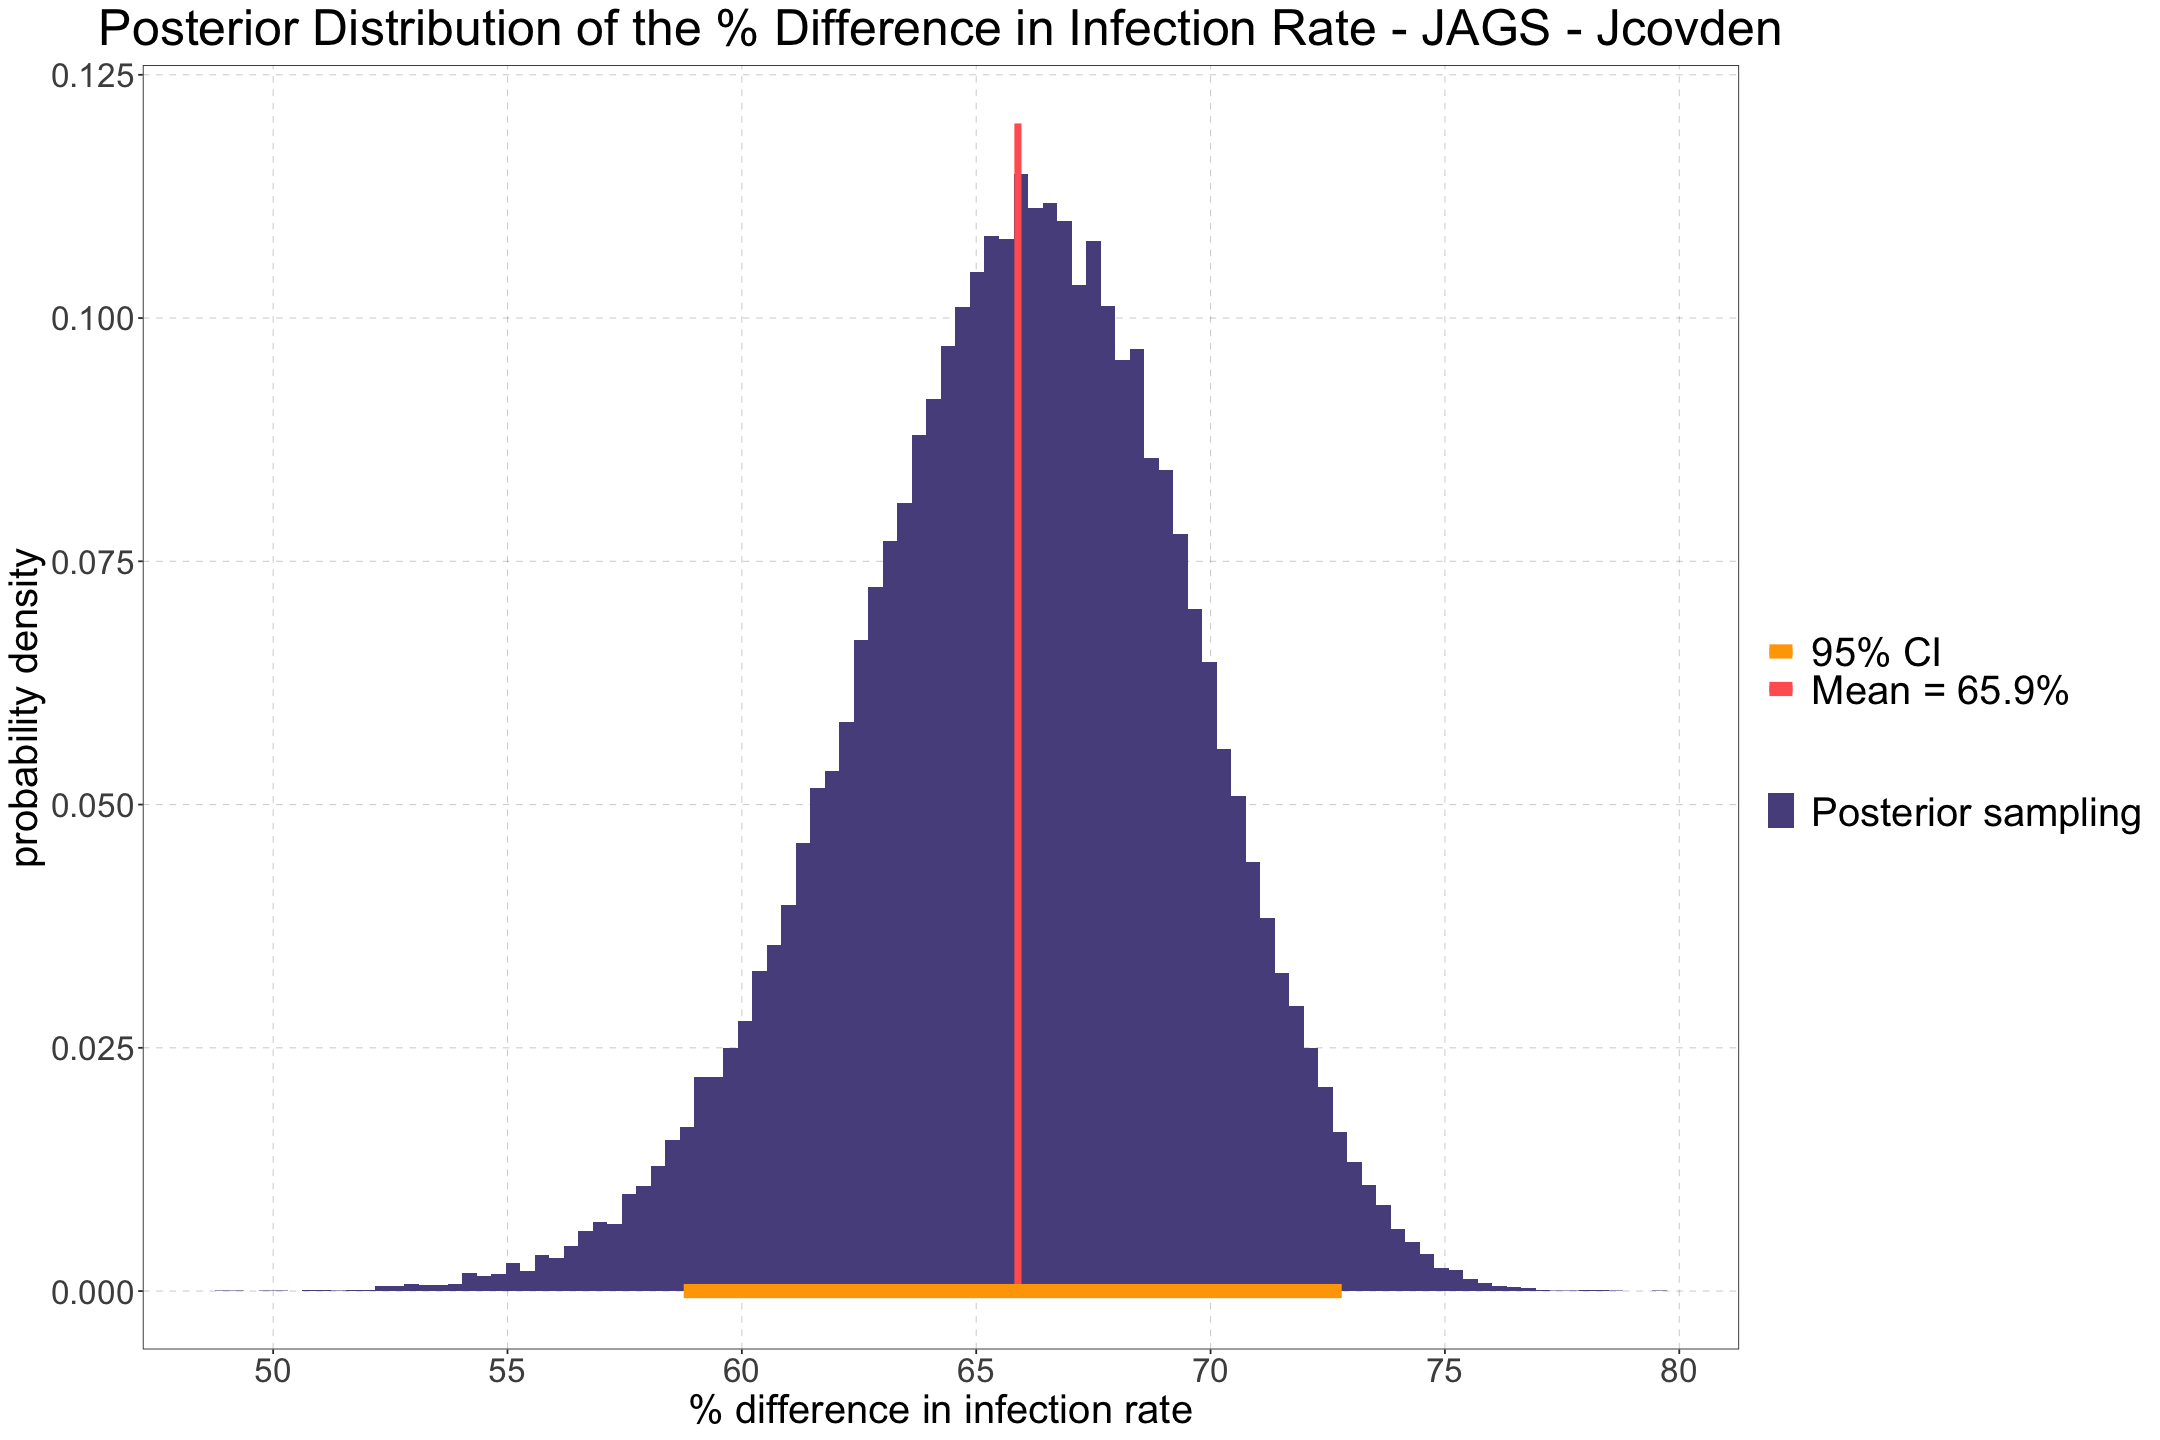

In [132]:
# plot
runjags_plot(results_j_runjags, "Jcovden", 0.12)

In [133]:
# STAN

# model (it is the same for all the datasets)
stan_model_vaccines <- "
data {
  int<lower=0> N;                           // number of observations
  int<lower=1> Nclass;                      // number of classes --> parameters
  int<lower=0, upper=1> tested[N];          // observed test results 
                                            // (0 for negative, 1 for positive)
  int<lower=1, upper=Nclass> patient[N];    // patient class indices
}

parameters {
  vector<lower=0, upper=1>[Nclass] theta;   // success probabilities for each class
}

model {
  // prior 
  for (j in 1:Nclass) {
    theta[j] ~ beta(3, 100);
  }
  
  // likelihood
  for (i in 1:N) {
    tested[i] ~ bernoulli(theta[patient[i]]);
  }
}
"

# compile the stan model (only one time for all datasets)
stan_vaccines <- stan_model(model_code = stan_model_vaccines)

In [145]:
# run the stan model with the data

fit_j <- sampling(
  object = stan_vaccines, 
  data = data_j, 
  chains = 2, 
  iter = 10000, 
  warmup = 1000, 
  thin = 1
)

In [146]:
# creating a tibble

tb_j <- as_tibble(as.data.frame(fit_j))

In [147]:
# calculating percentage difference in infection rates

tb_j <- tb_j %>% rename(
            Placebo = 'theta[1]', 
            Vaccine = 'theta[2]'
        )

In [148]:
tb_j <- tb_j %>% transmute(
            diff_rate = (Placebo-Vaccine)/Placebo * 100,
            Placebo_percent = Placebo * 100,
            Vaccine_percent = Vaccine * 100
)

In [149]:
# coda chain results

summary(as.mcmc(tb_j))


Iterations = 1:18000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 18000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                   Mean      SD  Naive SE Time-series SE
diff_rate       65.9198 3.62487 0.0270182      0.0291607
Placebo_percent  1.7739 0.09434 0.0007032      0.0007723
Vaccine_percent  0.6028 0.05544 0.0004132      0.0004406

2. Quantiles for each variable:

                   2.5%     25%     50%     75%   97.5%
diff_rate       58.3550 63.5317 66.0703 68.4228 72.6480
Placebo_percent  1.5934  1.7088  1.7727  1.8365  1.9628
Vaccine_percent  0.4979  0.5645  0.6017  0.6401  0.7158


In [150]:
# storing stan results

# getting 95% CI
ci_stan_j <- hdi(as.mcmc(tb_j$diff_rate), prob = 0.95)

results_j_stan <- NULL
results_j_stan$rate <- tb_j$diff_rate
results_j_stan$mean <- mean(tb_j$diff_rate)
results_j_stan$rmin <- ci_stan_j[1]
results_j_stan$rmax <- ci_stan_j[2]

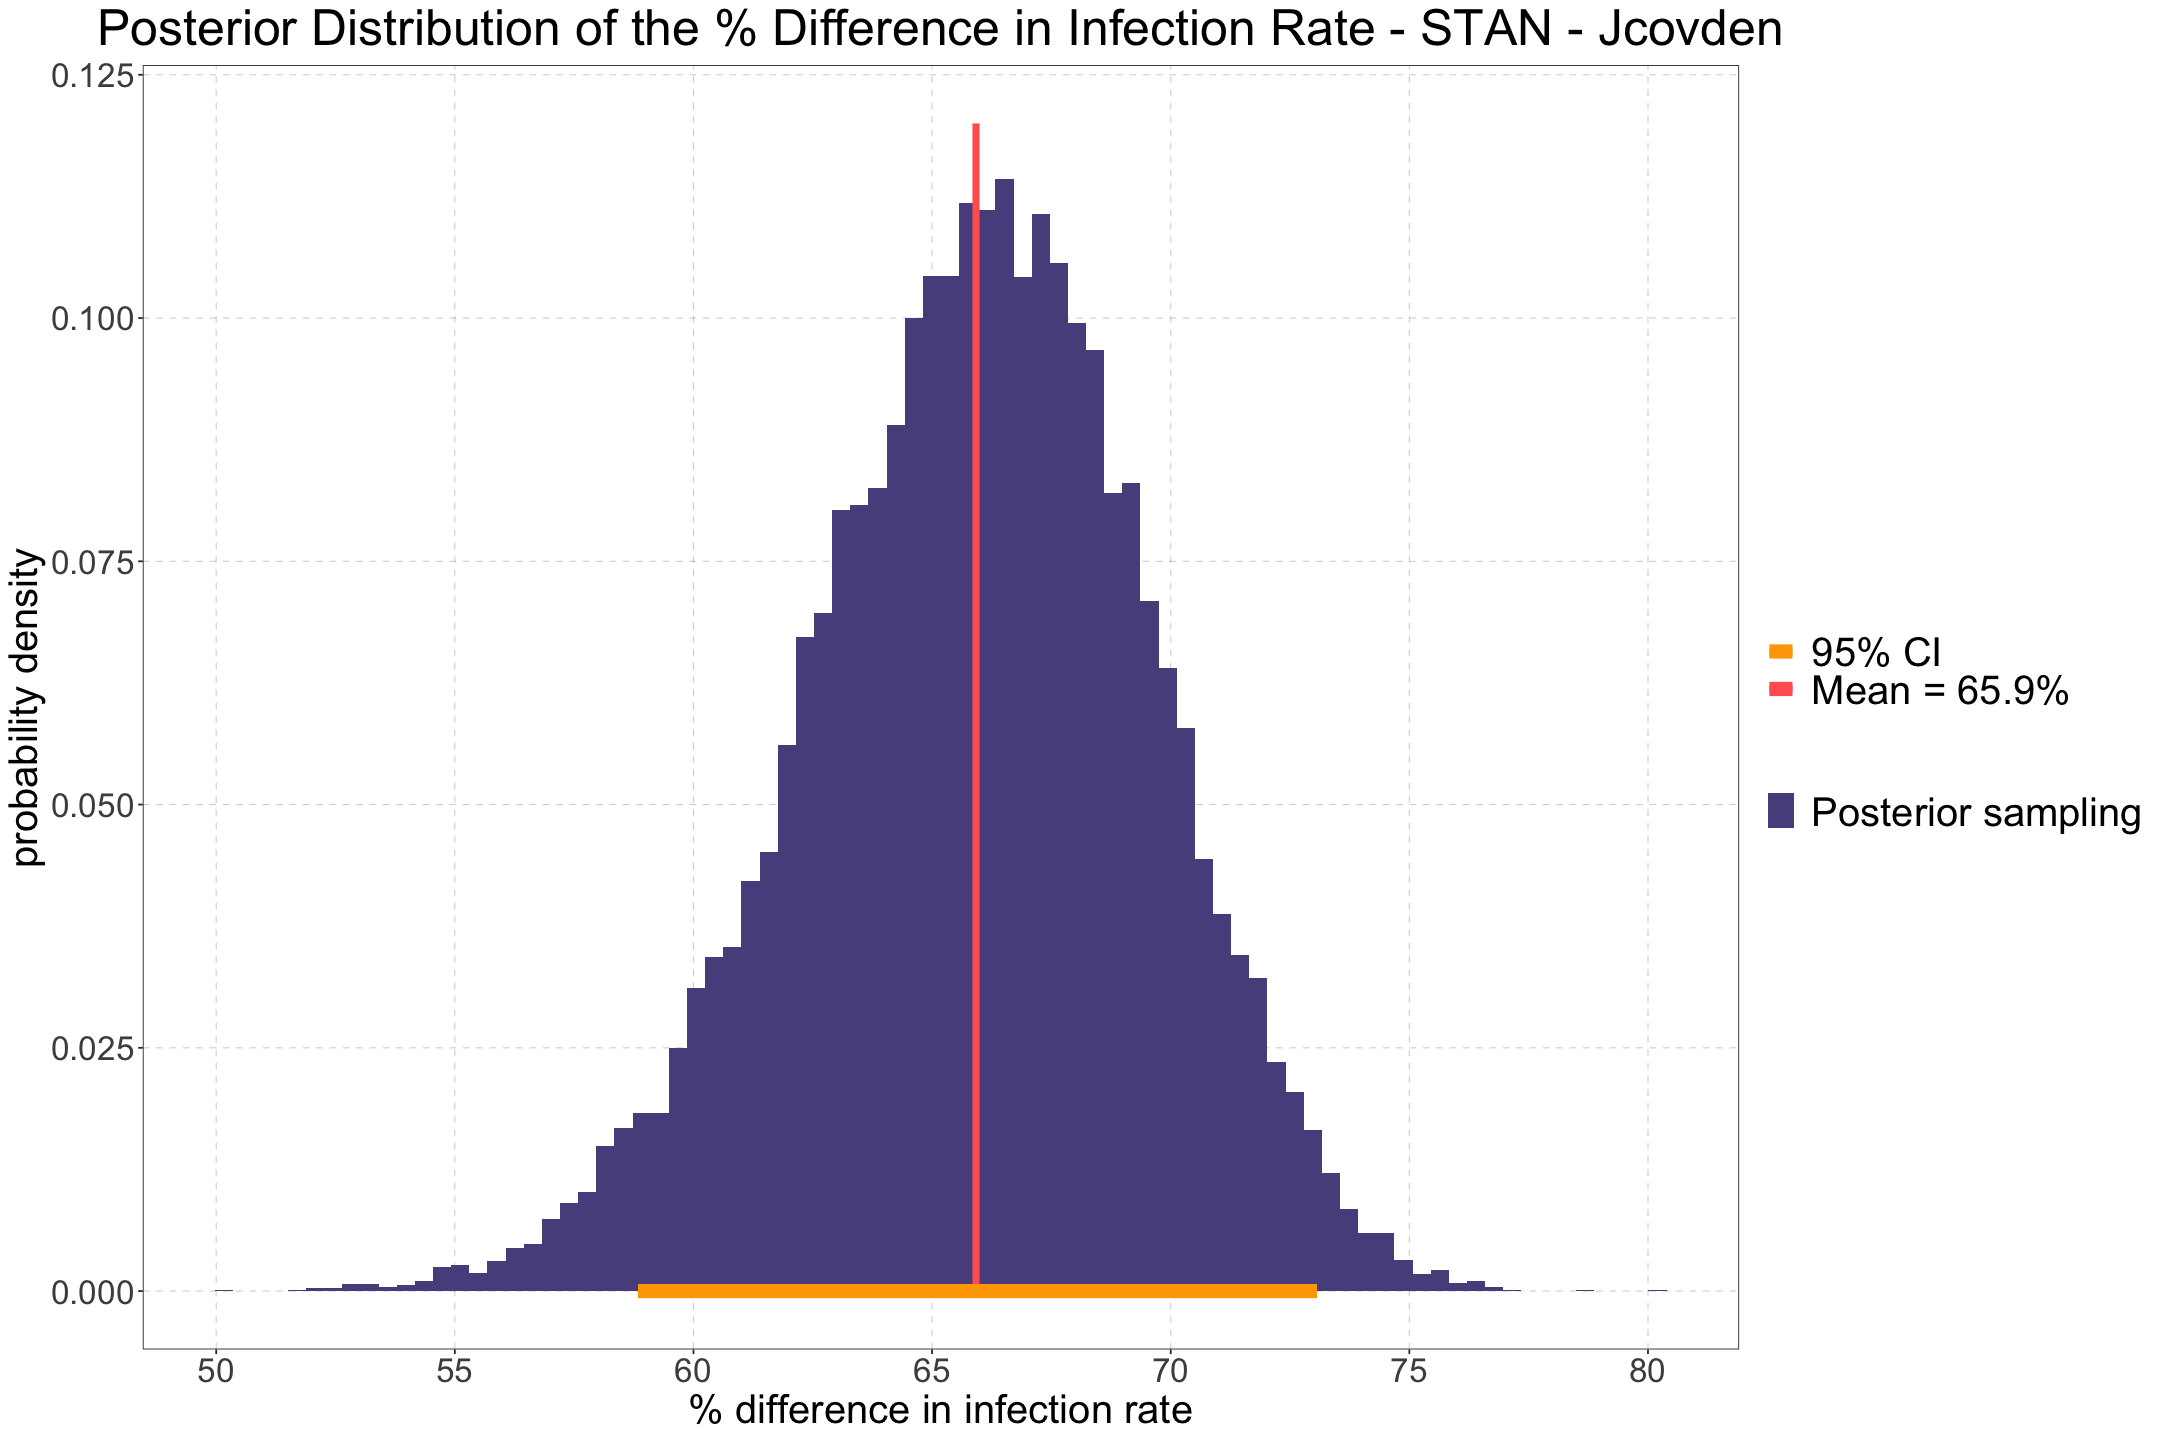

In [151]:
stan_plot(results_j_stan, "Jcovden", 0.12)

#### **Moderna**

From EMA, we can extract the following information:

1. **adults** 
     - sample: ~ 28 000 people
     - efficacy experiment: 14 134 people received vaccine, 14 073 people  received a placebo; people did not know whether they received the vaccine or the dummy injections.
     - results: 11 vaccinated people got symptoms, 185 people that received a   placebo got symptoms
     - conclusion: the vaccine has a 94.1% efficacy
2. **children**
     - sample: over 3 000 
     - efficacy experiment: 2 163 children received vaccine, 1 073 receied a placebo
     - results: 0 vaccinated children got symptoms, 4 children that received a placebo got symptoms
     - conclusion: the vaccine has an efficacy similar to that in adults


In [152]:
# ADULTS

# sample
vaccinated_m_a <- 14134
placebo_m_a <- 14073

patient_m_a <- c(
    rep("Vaccine", vaccinated_m_a),
    rep("Placebo", placebo_m_a)
)

pos_v_m_a <- 11
pos_p_m_a <- 185

tested_m_a <- c(
    rep("Pos", pos_v_m_a),
    rep("Neg", vaccinated_m_a-pos_v_m_a),
    rep("Pos", pos_p_m_a),
    rep("Neg", placebo_m_a-pos_p_m_a)
)

# organizing data
moderna_a_tb <- tibble(tested = tested_m_a, patient = patient_m_a)
table(moderna_a_tb[[2]], moderna_a_tb[[1]])

data_m_a = list(
    tested = ifelse(moderna_a_tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(moderna_a_tb$patient)),
    N = nrow(moderna_a_tb),
    Nclass = nlevels(factor(moderna_a_tb$patient))
)

         
            Neg   Pos
  Placebo 13888   185
  Vaccine 14123    11

In [153]:
# RUNJAGS

chain_m_a <- run.jags(  model = "vaccine_efficacy_model.bug", 
                        sample = 15000,
                        n.chains = 4,
                        method = "parallel",
                        monitor = "theta",
                        data = data_m_a)

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.2 on Sun Jun  4 14:25:59 2023
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 28207
   Unobserved stochastic nodes: 2
   Total graph size: 56420
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 15000
-------------------------------------------------| 15000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

In [154]:
# percentage difference in infection rates (getting a tibble)

res_m_a <- tidy_draws(chain_m_a) %>%
            select('theta[1]':'theta[2]') %>%
            rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
            mutate(
                diff_rate = (Placebo-Vaccine)/Placebo * 100,
                Placebo_percent = Placebo * 100,
                Vaccine_percent = Vaccine * 100
            )

In [155]:
# coda chain results

summary(as.mcmc(res_m_a))


Iterations = 1:60000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 60000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                     Mean        SD  Naive SE Time-series SE
Placebo          0.013260 0.0009613 3.924e-06      3.924e-06
Vaccine          0.000983 0.0002646 1.080e-06      1.080e-06
diff_rate       92.547291 2.0838169 8.507e-03      8.507e-03
Placebo_percent  1.326027 0.0961271 3.924e-04      3.924e-04
Vaccine_percent  0.098304 0.0264583 1.080e-04      1.080e-04

2. Quantiles for each variable:

                     2.5%       25%       50%       75%     97.5%
Placebo         1.144e-02  0.012599  0.013241  0.013892  0.015205
Vaccine         5.354e-04  0.000794  0.000959  0.001145  0.001572
diff_rate       8.791e+01 91.277432 92.752754 94.039602 96.020542
Placebo_percent 1.144e+00  1.259860  1.324090  1.389200  1.520501
Vaccine_percent 5.354e-02  0.079396  0.095902  0.114537  0.157222


In [156]:
# storing results

# getting 95% CI
ci_runjags_m_a <- hdi(as.mcmc(res_m_a$diff_rate), prob = 0.95)

results_m_a_runjags <- NULL
results_m_a_runjags$rate <- res_m_a$diff_rate
results_m_a_runjags$mean <- mean(res_m_a$diff_rate)
results_m_a_runjags$rmin <- ci_runjags_m_a[1]
results_m_a_runjags$rmax <- ci_runjags_m_a[2]

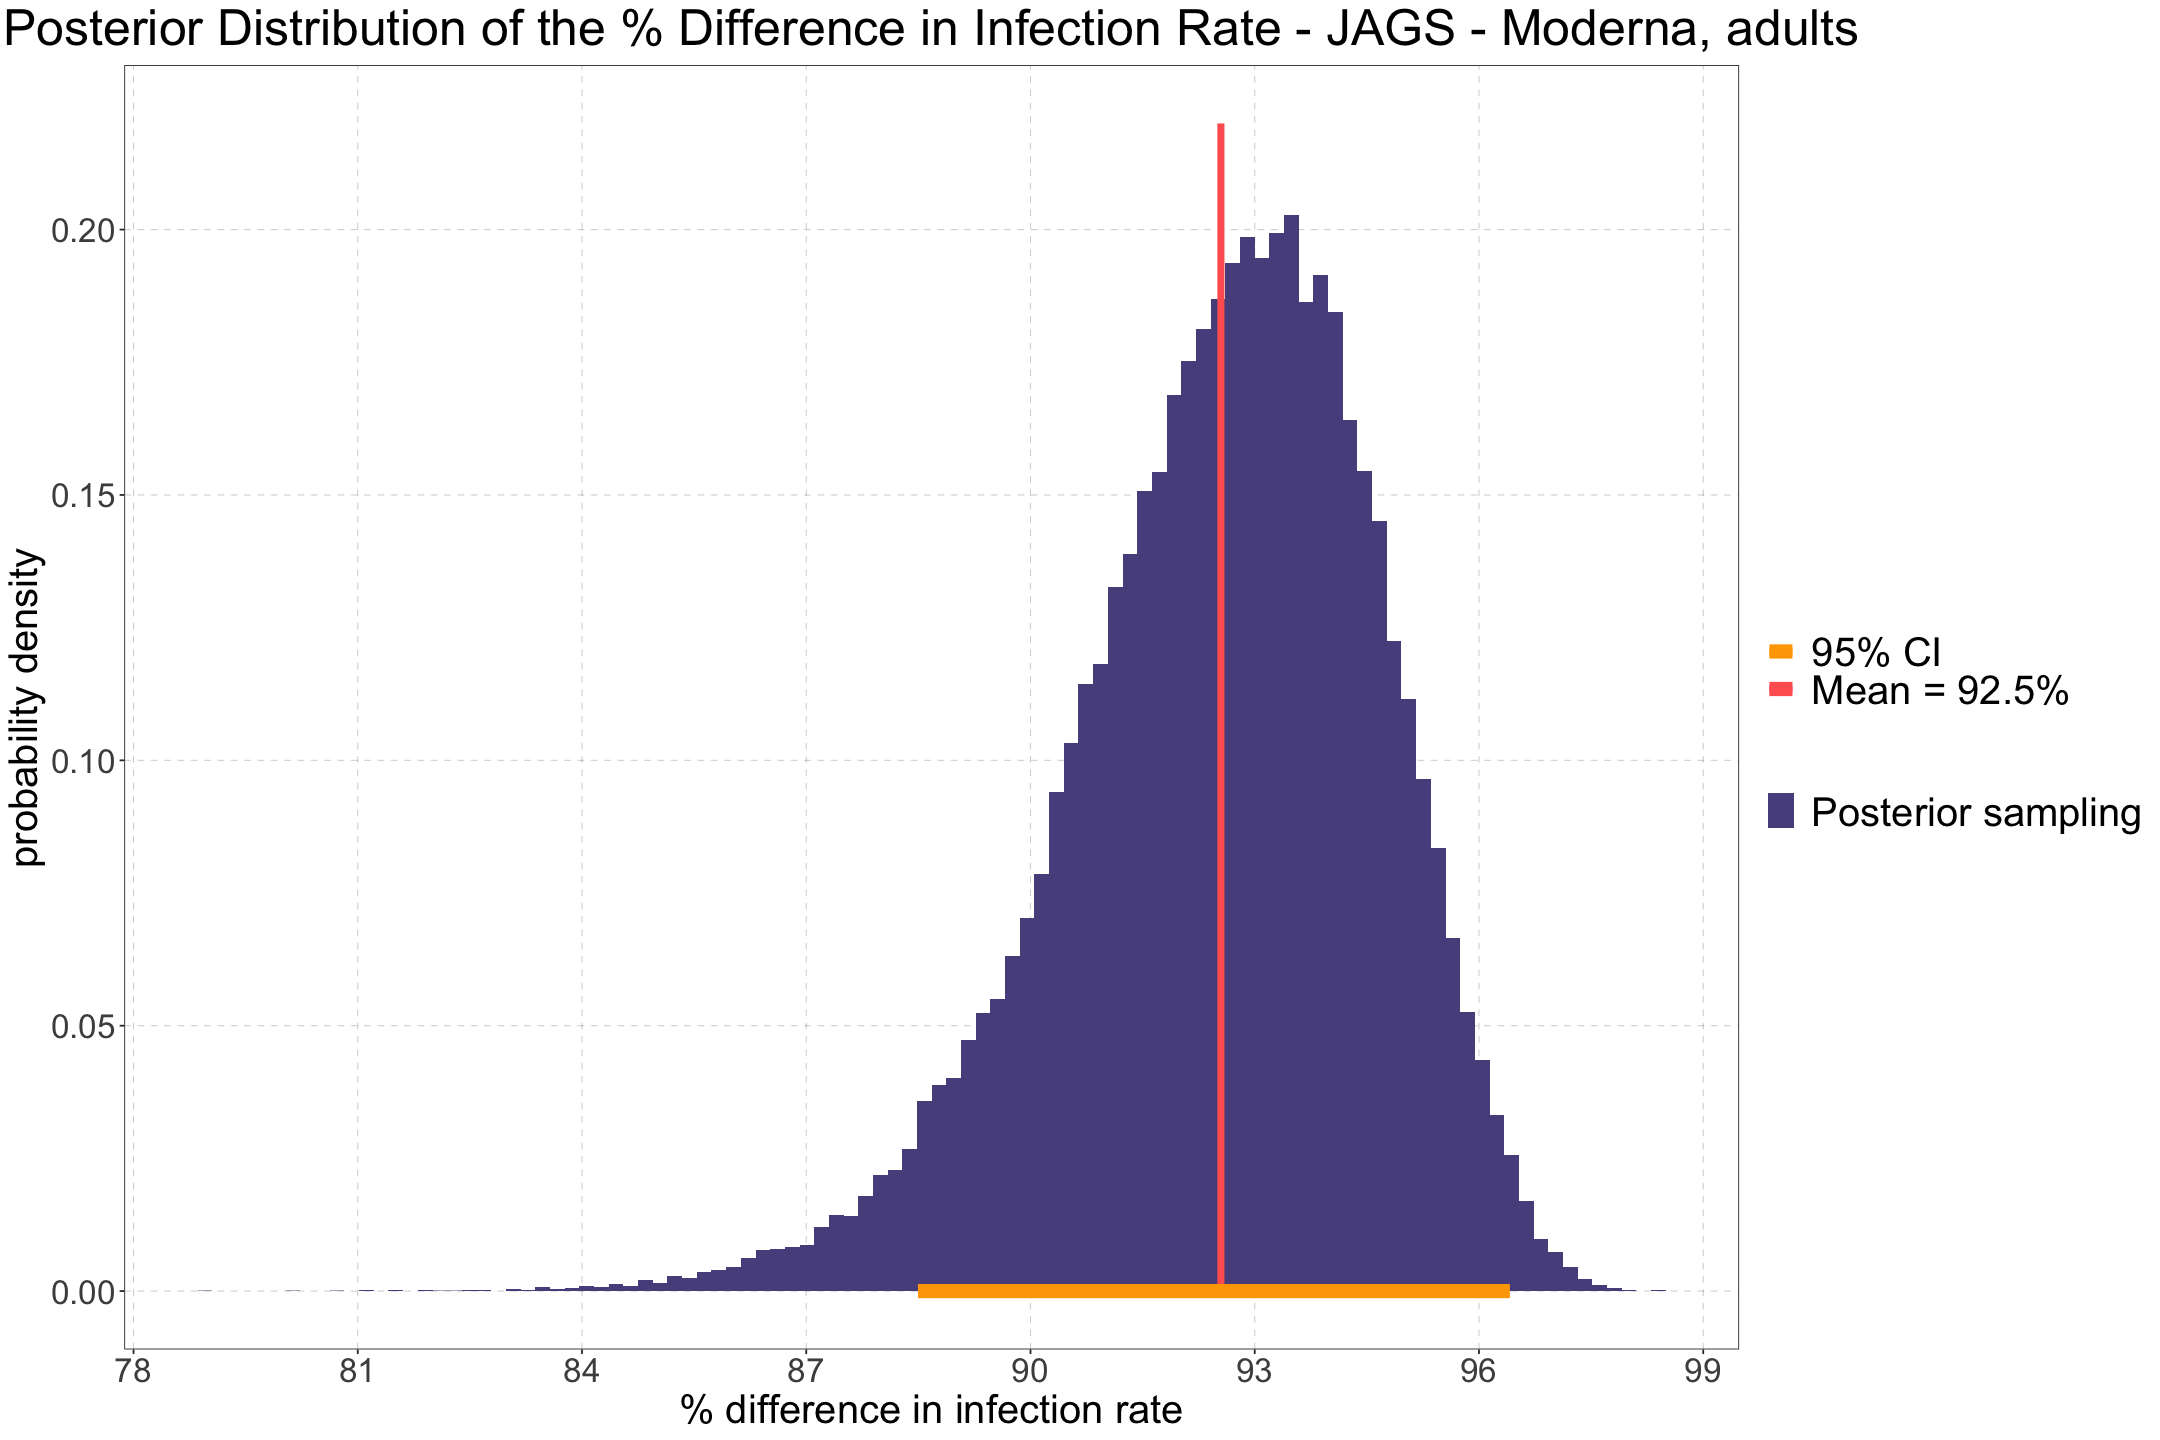

In [157]:
# plot
runjags_plot(results_m_a_runjags, "Moderna, adults", 0.22)

In [158]:
# STAN

# run the model with the data

fit_m_a <- sampling(    object = stan_vaccines,
                        data = data_m_a,
                        chains = 4,
                        iter = 10000,
                        warmup = 1000,
                        thin = 1
                    )

In [159]:
# creating a tibble

tb_m_a <- as_tibble(as.data.frame(fit_m_a))

# calculating percentage difference in infection rates

tb_m_a <- tb_m_a %>% rename(
            Placebo = 'theta[1]', 
            Vaccine = 'theta[2]'
        )

tb_m_a <- tb_m_a %>% transmute(
            diff_rate = (Placebo-Vaccine)/Placebo * 100,
            Placebo_percent = Placebo * 100,
            Vaccine_percent = Vaccine * 100
)

# coda chain results

summary(as.mcmc(tb_m_a))


Iterations = 1:36000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 36000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                    Mean      SD  Naive SE Time-series SE
diff_rate       92.54874 2.08114 0.0109686      0.0122136
Placebo_percent  1.32661 0.09629 0.0005075      0.0005939
Vaccine_percent  0.09835 0.02651 0.0001397      0.0001543

2. Quantiles for each variable:

                    2.5%      25%      50%     75%   97.5%
diff_rate       87.91851 91.28104 92.75956 94.0428 96.0052
Placebo_percent  1.14421  1.26050  1.32400  1.3908  1.5203
Vaccine_percent  0.05379  0.07933  0.09597  0.1148  0.1565


In [160]:
# storing stan results

# getting 95% CI
ci_stan__m_a <- hdi(as.mcmc(tb_m_a$diff_rate), prob = 0.95)

results_m_a_stan <- NULL
results_m_a_stan$rate <- tb_m_a$diff_rate
results_m_a_stan$mean <- mean(tb_m_a$diff_rate)
results_m_a_stan$rmin <- ci_stan__m_a[1]
results_m_a_stan$rmax <- ci_stan__m_a[2]

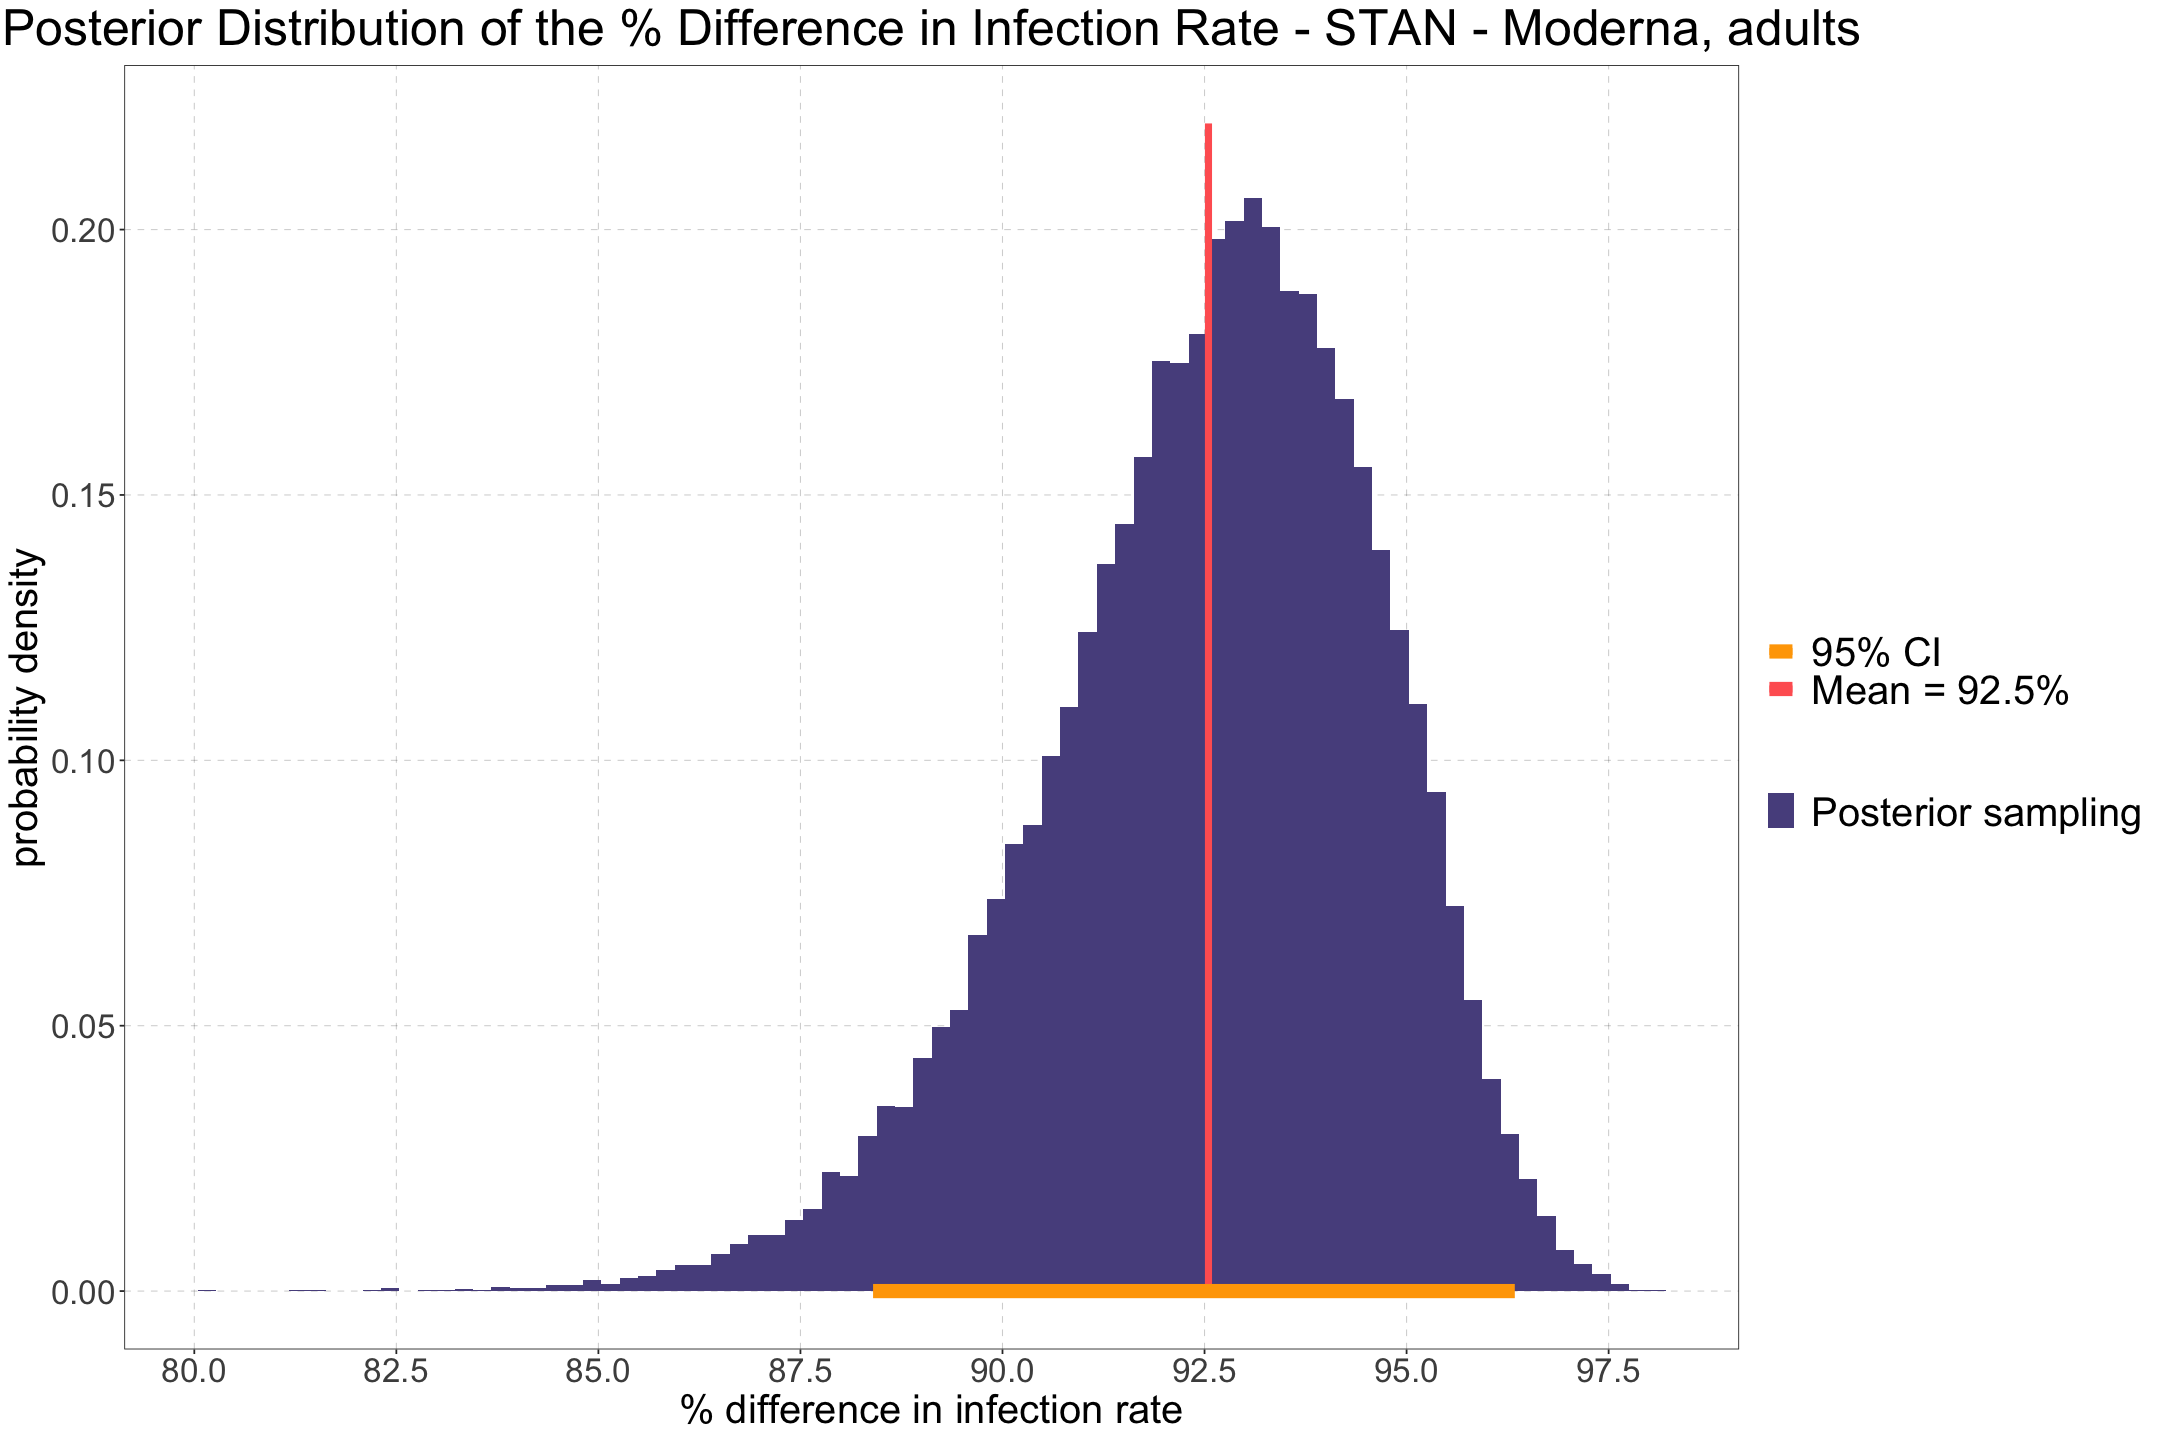

In [161]:
stan_plot(results_m_a_stan, "Moderna, adults", 0.22)

In [162]:
# CHILDREN

# sample
vaccinated_m_c <- 2163
placebo_m_c <- 1073

patient_m_c <- c(
    rep("Vaccine", vaccinated_m_c),
    rep("Placebo", placebo_m_c)
)

pos_v_m_c <- 0
pos_p_m_c <- 4

tested_m_c <- c(
    rep("Pos", pos_v_m_c),
    rep("Neg", vaccinated_m_c-pos_v_m_c),
    rep("Pos", pos_p_m_c),
    rep("Neg", placebo_m_c-pos_p_m_c)
)

# organizing data
moderna_c_tb <- tibble(tested = tested_m_c, patient = patient_m_c)
table(moderna_c_tb[[2]], moderna_c_tb[[1]])

data_m_c = list(
    tested = ifelse(moderna_c_tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(moderna_c_tb$patient)),
    N = nrow(moderna_c_tb),
    Nclass = nlevels(factor(moderna_c_tb$patient))
)

         
           Neg  Pos
  Placebo 1069    4
  Vaccine 2163    0

In [163]:
# RUNJAGS

chain_m_c <- run.jags( model = "vaccine_efficacy_model.bug", 
                       sample = 15000,
                       n.chains = 4,
                       method = "parallel",
                       monitor = "theta",
                       data =data_m_c
                      )

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.2 on Sun Jun  4 14:28:51 2023
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 3236
   Unobserved stochastic nodes: 2
   Total graph size: 6478
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 15000
-------------------------------------------------| 15000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not req

In [176]:
# percentage difference in infection rates (getting a tibble)

res_m_c <- tidy_draws(chain_m_c) %>%
            select('theta[1]':'theta[2]') %>%
            rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
            mutate(
                diff_rate = (abs(Placebo-Vaccine))/Placebo * 100,
                Placebo_percent = Placebo * 100,
                Vaccine_percent = Vaccine * 100
            )

In [177]:
# coda chain results

summary(as.mcmc(res_m_c))


Iterations = 1:60000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 60000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                     Mean        SD  Naive SE Time-series SE
Placebo          0.005961 2.249e-03 9.182e-06      9.182e-06
Vaccine          0.001321 7.644e-04 3.121e-06      3.121e-06
diff_rate       74.685376 1.798e+01 7.342e-02      7.403e-02
Placebo_percent  0.596134 2.249e-01 9.182e-04      9.182e-04
Vaccine_percent  0.132094 7.644e-02 3.121e-04      3.121e-04

2. Quantiles for each variable:

                     2.5%       25%       50%       75%     97.5%
Placebo          0.002394  0.004323  0.005678  0.007293  0.011110
Vaccine          0.000272  0.000762  0.001175  0.001728  0.003211
diff_rate       24.629180 66.962201 79.314829 87.426659 95.888726
Placebo_percent  0.239358  0.432315  0.567759  0.729250  1.110991
Vaccine_percent  0.027202  0.076203  0.117529  0.172833  0.321136


In [178]:
# storing results

# getting 95% CI
ci_runjags_m_c <- hdi(as.mcmc(res_m_c$diff_rate), prob = 0.95)

results_m_c_runjags <- NULL
results_m_c_runjags$rate <- res_m_c$diff_rate
results_m_c_runjags$mean <- mean(res_m_c$diff_rate)
results_m_c_runjags$rmin <- ci_runjags_m_c[1]
results_m_c_runjags$rmax <- ci_runjags_m_c[2]

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


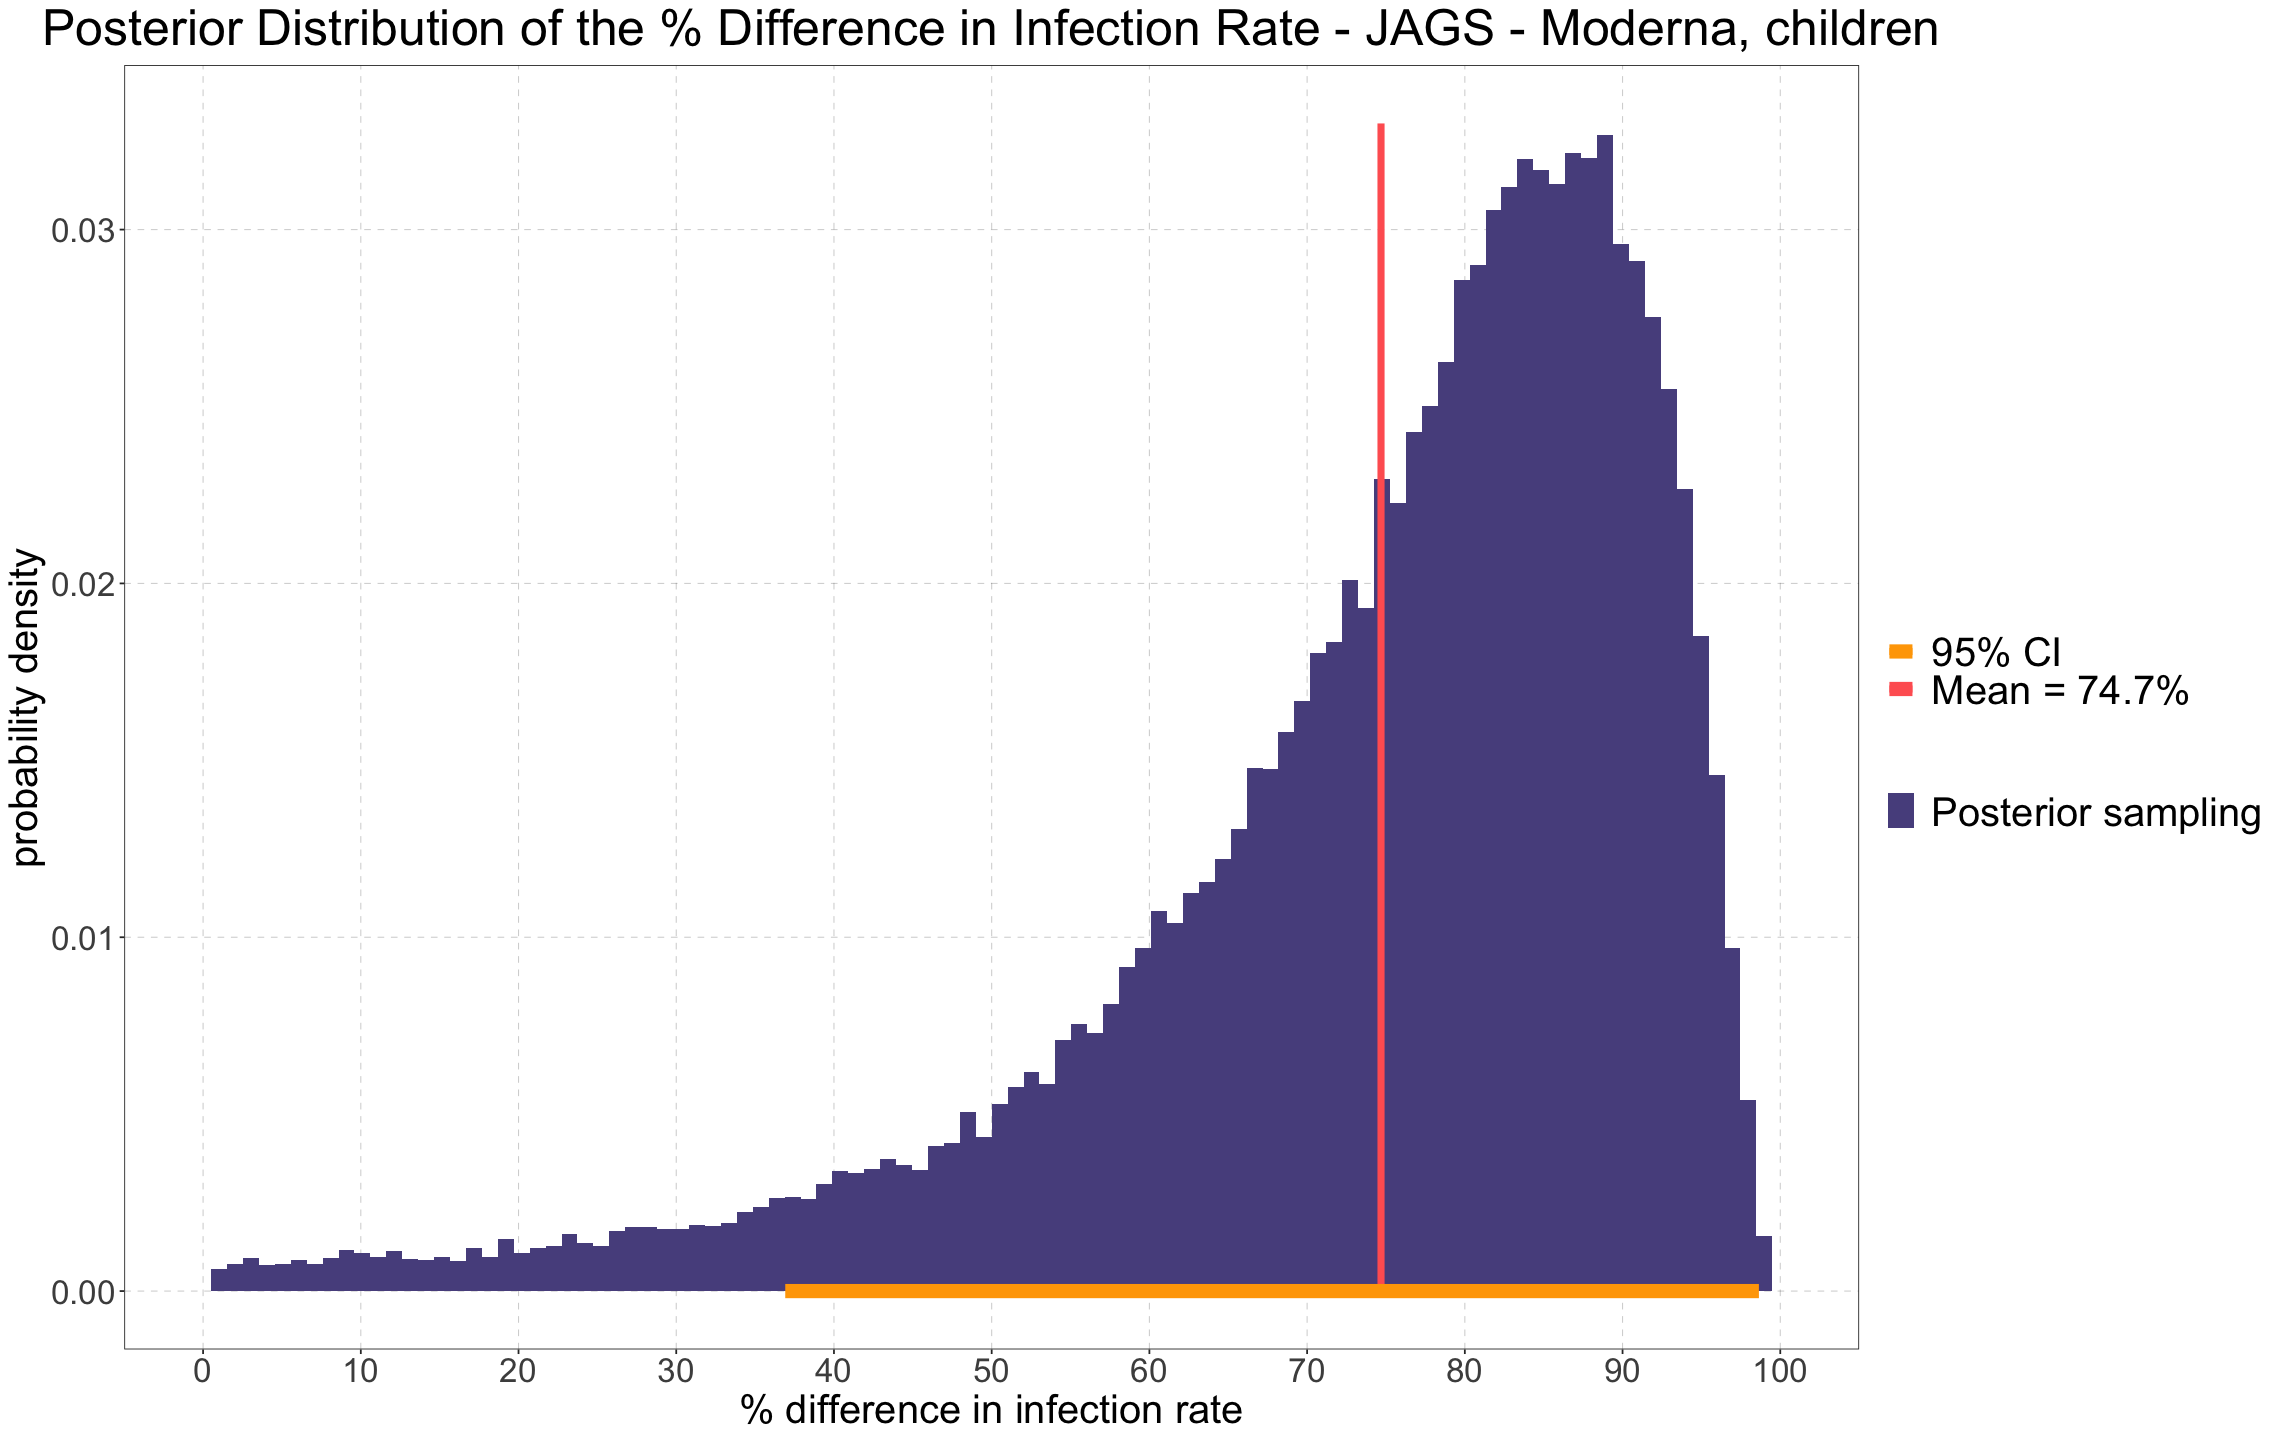

In [188]:
# plot (silencing not necessary warnings)

defaultW <- getOption("warn") 

options(warn = -1) 

runjags_plot(results_m_c_runjags, "Moderna, children", 0.033) + 
scale_x_continuous(n.breaks = 10, limits = c(0,100))

options(warn = defaultW)


In [190]:
# STAN

# run the model with the data

fit_m_c <- sampling(
    object = stan_vaccines,
    data = data_m_c,
    chains = 4,
    iter = 10000,
    warmup = 1000,
    thin = 1
)

In [195]:
# creating a tibble

tb_m_c <- as_tibble(as.data.frame(fit_m_c))

# calculating percentage difference in infection rates

tb_m_c <- tb_m_c %>% rename(
            Placebo = 'theta[1]', 
            Vaccine = 'theta[2]'
        )

tb_m_c <- tb_m_c %>% transmute(
            diff_rate = abs(Placebo-Vaccine)/Placebo * 100,
            Placebo_percent = Placebo * 100,
            Vaccine_percent = Vaccine * 100
)

# coda chain results

summary(as.mcmc(tb_m_c))


Iterations = 1:36000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 36000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                   Mean       SD Naive SE Time-series SE
diff_rate       74.8054 17.55489 0.092522      0.1141046
Placebo_percent  0.5975  0.22298 0.001175      0.0014077
Vaccine_percent  0.1323  0.07571 0.000399      0.0004778

2. Quantiles for each variable:

                    2.5%      25%     50%     75%   97.5%
diff_rate       26.65562 66.95186 79.2421 87.3739 95.7689
Placebo_percent  0.24523  0.43617  0.5691  0.7267  1.1073
Vaccine_percent  0.02798  0.07691  0.1182  0.1730  0.3163


In [196]:
# storing stan results

# getting 95% CI
ci_stan__m_c <- hdi(as.mcmc(tb_m_c$diff_rate), prob = 0.95)

results_m_c_stan <- NULL
results_m_c_stan$rate <- tb_m_c$diff_rate
results_m_c_stan$mean <- mean(tb_m_c$diff_rate)
results_m_c_stan$rmin <- ci_stan__m_c[1]
results_m_c_stan$rmax <- ci_stan__m_c[2]

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


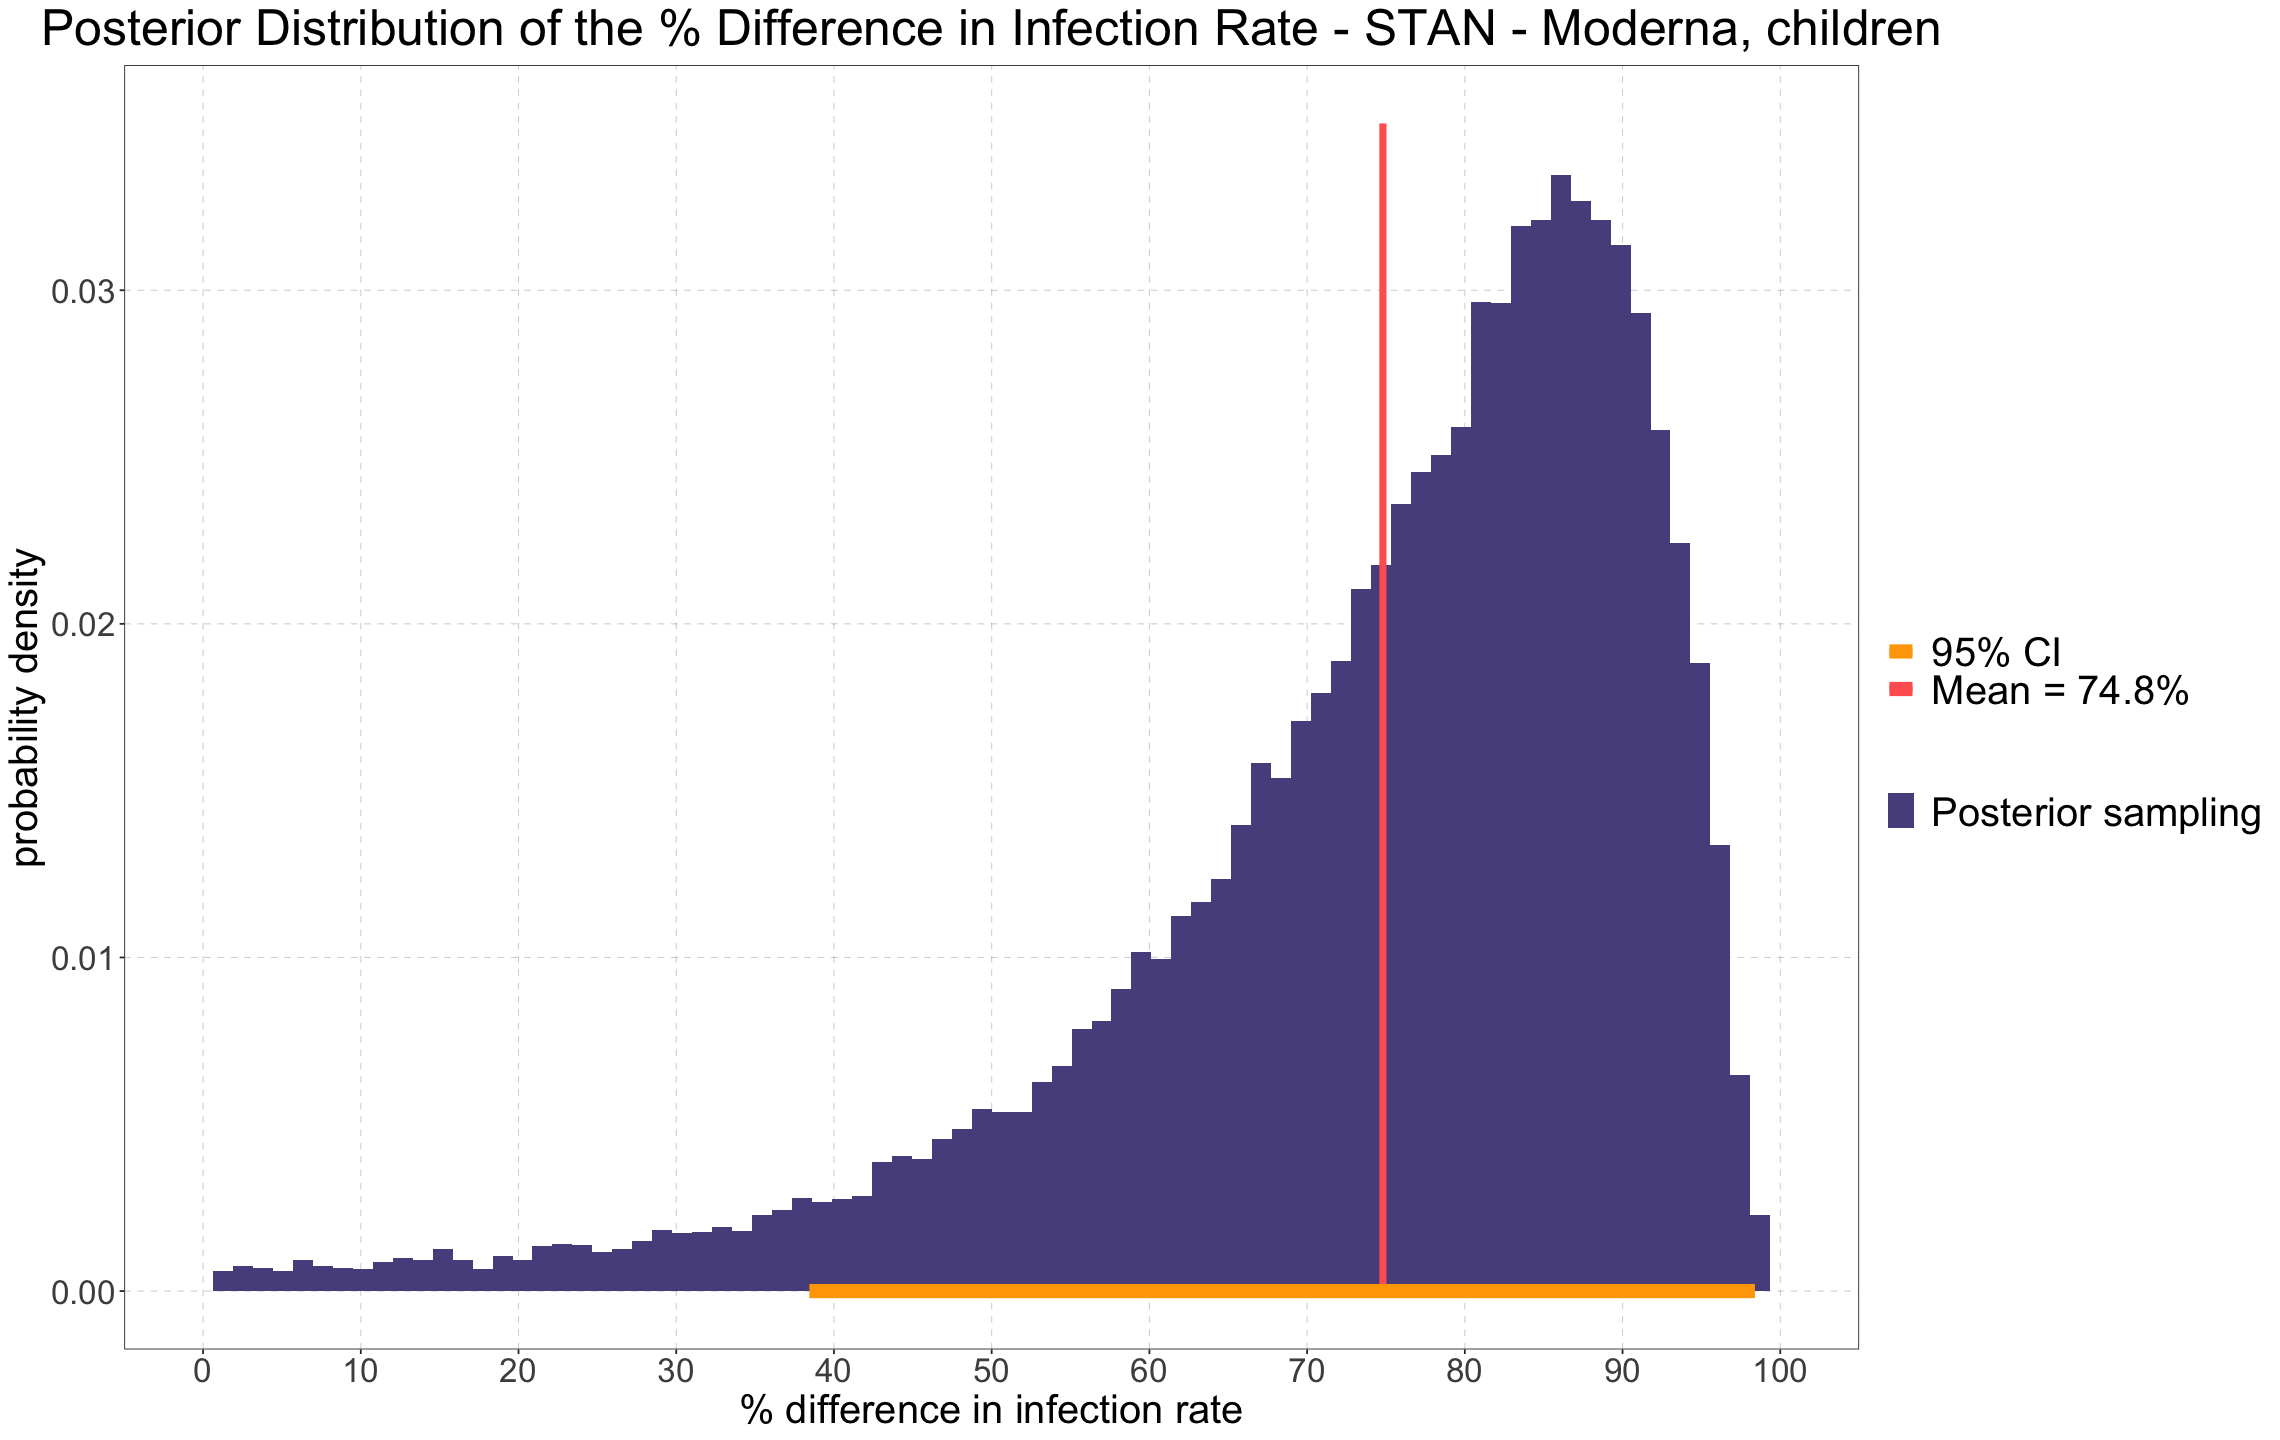

In [200]:
# plot (silencing not necessary warnings)

defaultW <- getOption("warn") 
options(warn = -1) 
stan_plot(results_m_c_stan, "Moderna, children", 0.035) + 
scale_x_continuous(n.breaks = 10, limits = c(0,100))
options(warn = defaultW)

From both analyses, with `runjags` and `rstan`, we see that the sampled posterior distribution for the children sample is strongly asymmetrical and if we choose the median as the best estimate for the efficacy, we obtain that the efficacy among children is similar to that one among adults.

#### **AstraZeneca**

FromEMA, we can extract the following information:

1. **first study**
   - sample: ~ 10 000 people
   - efficacy experiment: 5 258 people got vaccinated, 5 210 got placebo
   - results: 65 vaccinated people got symptoms, 154 people that received placebo got symptoms
   - conclusion: 59.5% efficacy
2. **second study**
   - sample: ~ 26 000 people
   - efficacy experiment: 17 662 people got vaccinated, 8 550 got placebo
   - results: 73 vaccinated people got symptoms, 130 people that received placebo got symptoms
   - conclusion: 74% efficacy

In [201]:
# first study 

# sample
vaccinated_az1 <- 5258
placebo_az1 <- 5210

patient_az1 <- c(
    rep("Vaccine", vaccinated_az1),
    rep("Placebo", placebo_az1)
)

pos_v_az1 <- 65
pos_p_az1 <- 154

tested_az1 <- c(
    rep("Pos", pos_v_az1),
    rep("Neg", vaccinated_az1-pos_v_az1),
    rep("Pos", pos_p_az1),
    rep("Neg", placebo_az1-pos_p_az1)
)

# organizing data
az1_tb <- tibble(tested = tested_az1, patient = patient_az1)
table(az1_tb[[2]], az1_tb[[1]])

data_az1 = list(
    tested = ifelse(az1_tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(az1_tb$patient)),
    N = nrow(az1_tb),
    Nclass = nlevels(factor(az1_tb$patient))
)

         
           Neg  Pos
  Placebo 5056  154
  Vaccine 5193   65

In [202]:
# RUNJAGS

chain_az1 <- run.jags(model = "vaccine_efficacy_model.bug", 
                    sample = 15000,
                    n.chains = 4,
                    method = "parallel",
                    monitor = "theta",
                    data = data_az1)

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.2 on Sun Jun  4 14:43:17 2023
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 10468
   Unobserved stochastic nodes: 2
   Total graph size: 20942
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 15000
-------------------------------------------------| 15000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

In [203]:
# percentage difference in infection rates (getting a tibble)

res_az1 <- tidy_draws(chain_az1) %>%
            select('theta[1]':'theta[2]') %>%
            rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
            mutate(
                diff_rate = (Placebo-Vaccine)/Placebo * 100,
                Placebo_percent = Placebo * 100,
                Vaccine_percent = Vaccine * 100
            )

In [204]:
# coda chain results

summary(as.mcmc(res_az1))


Iterations = 1:60000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 60000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                    Mean       SD  Naive SE Time-series SE
Placebo          0.02956 0.002329 9.509e-06      9.353e-06
Vaccine          0.01269 0.001533 6.260e-06      6.260e-06
diff_rate       56.81074 6.258716 2.555e-02      2.579e-02
Placebo_percent  2.95587 0.232911 9.509e-04      9.353e-04
Vaccine_percent  1.26868 0.153327 6.260e-04      6.260e-04

2. Quantiles for each variable:

                     2.5%      25%      50%      75%    97.5%
Placebo          0.025192  0.02796  0.02950  0.03109  0.03433
Vaccine          0.009873  0.01161  0.01262  0.01369  0.01586
diff_rate       43.557606 52.82483 57.22133 61.22949 67.91944
Placebo_percent  2.519179  2.79571  2.94971  3.10923  3.43252
Vaccine_percent  0.987283  1.16136  1.26199  1.36930  1.58615


In [205]:
# storing results

# getting 95% CI
ci_runjags_az1 <- hdi(as.mcmc(res_az1$diff_rate), prob = 0.95)

results_az1_runjags <- NULL
results_az1_runjags$rate <- res_az1$diff_rate
results_az1_runjags$mean <- mean(res_az1$diff_rate)
results_az1_runjags$rmin <- ci_runjags_az1[1]
results_az1_runjags$rmax <- ci_runjags_az1[2]

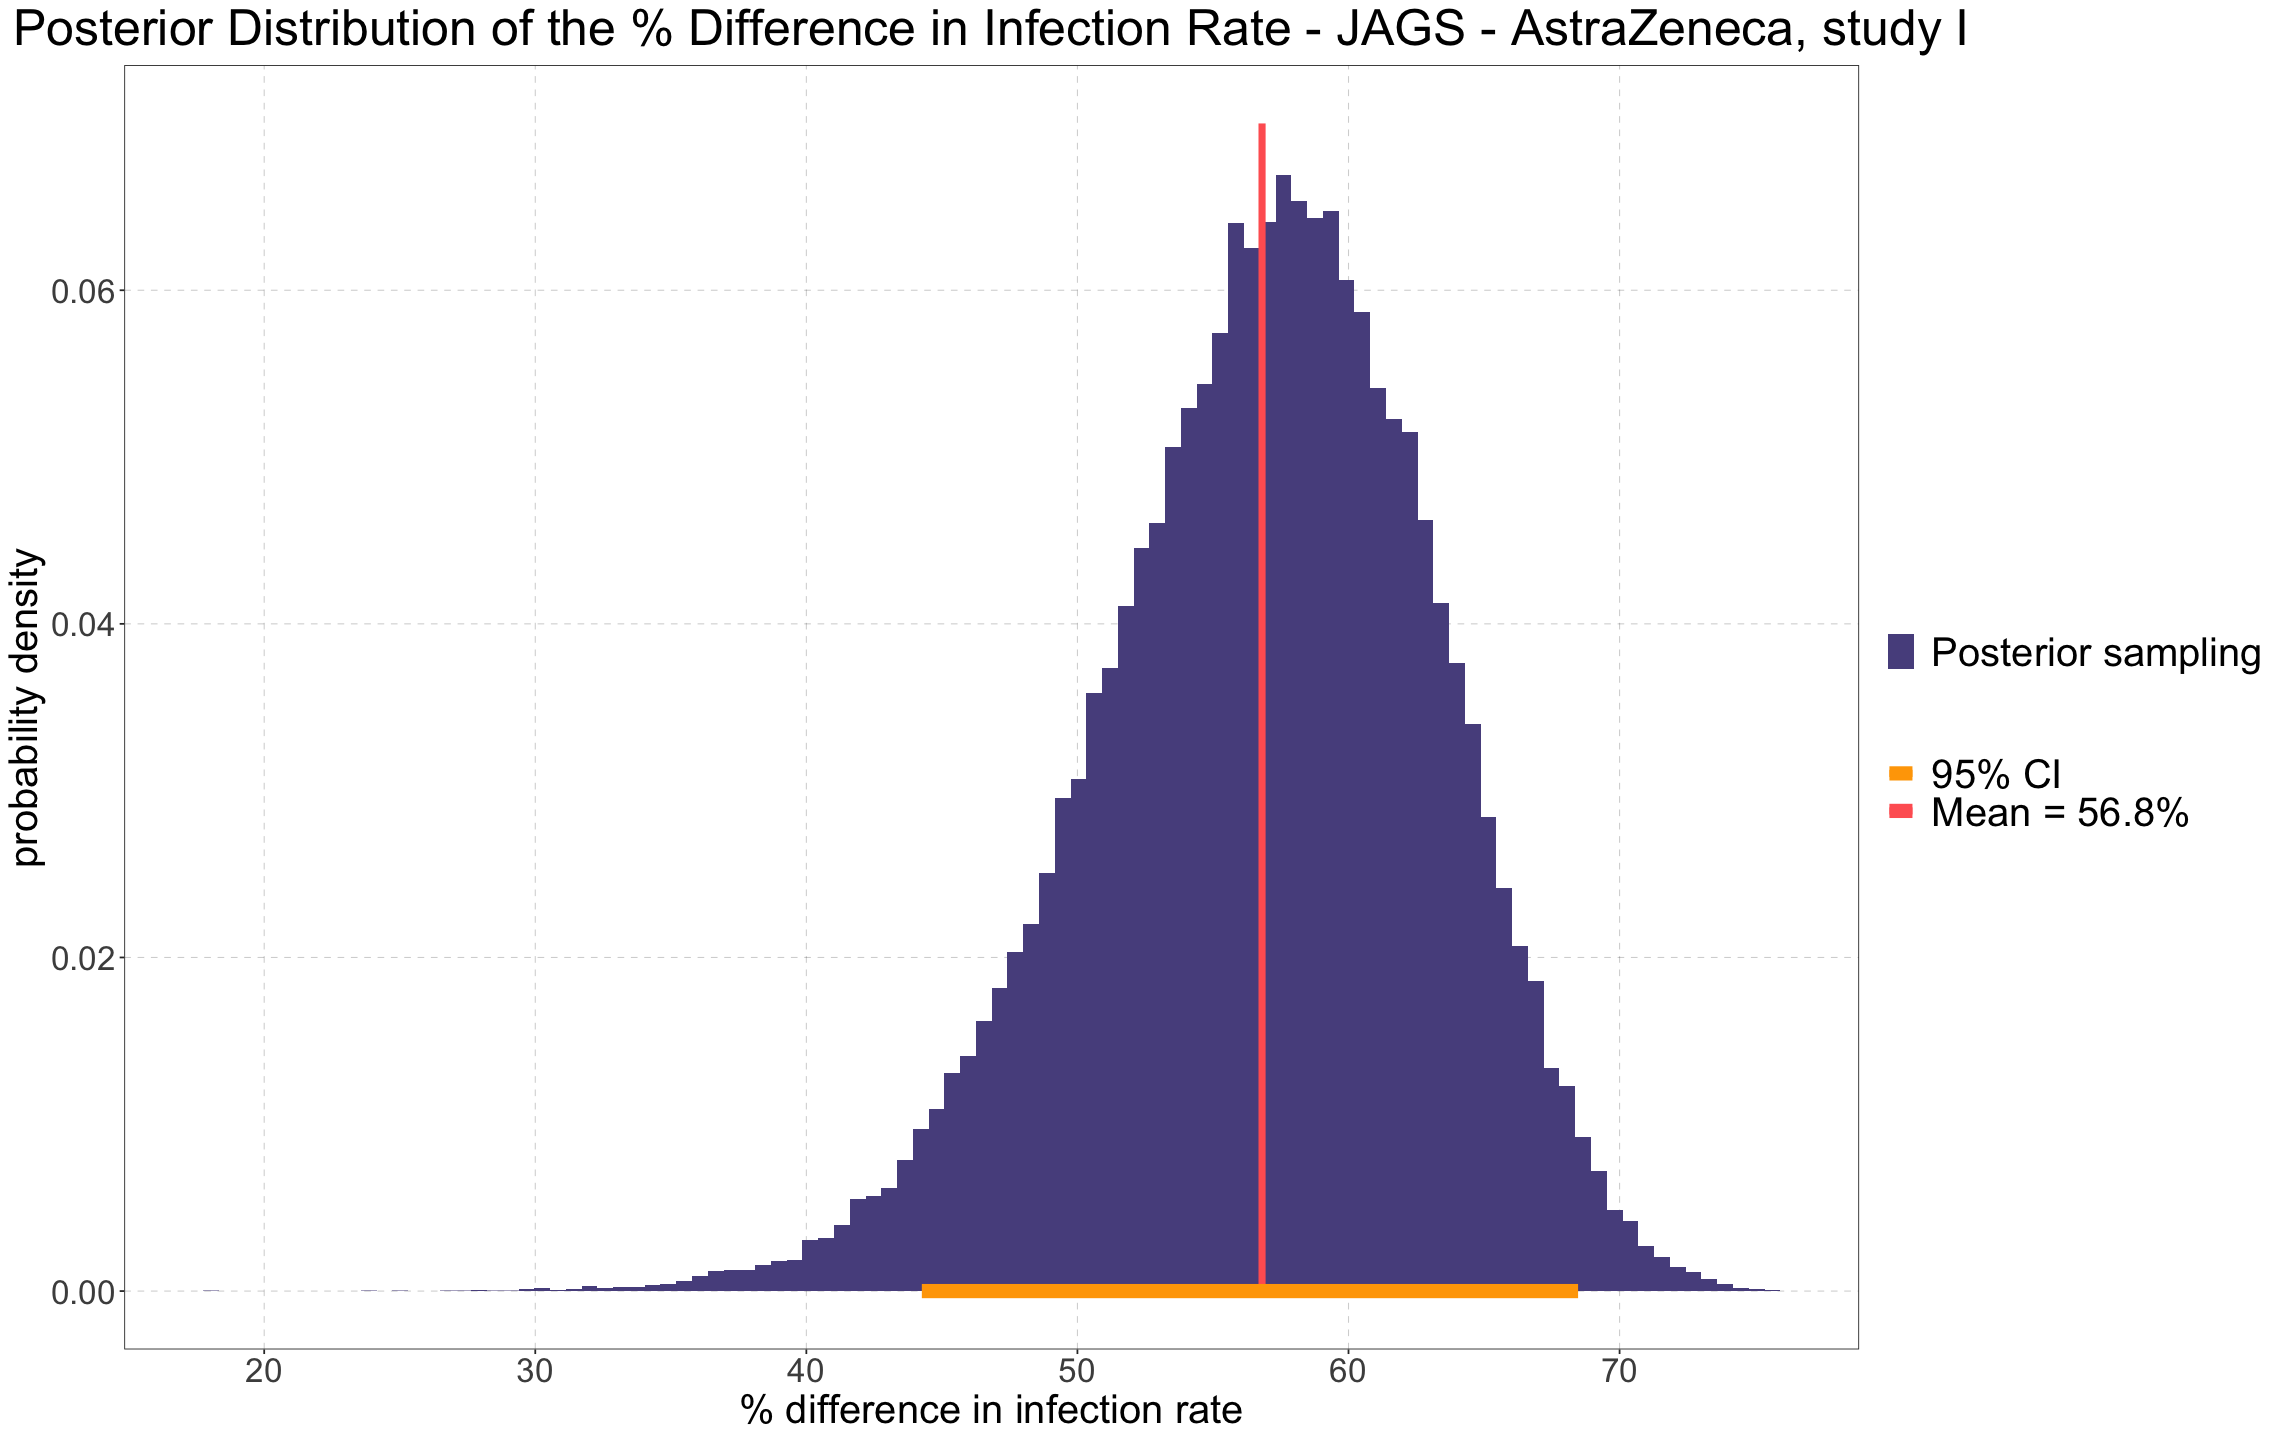

In [210]:
# plot
runjags_plot(results_az1_runjags, "AstraZeneca, study I", 0.07)

In [211]:
# STAN

# run the model with the data

fit_az1 <- sampling(
    object = stan_vaccines,
    data = data_az1,
    chains = 4, 
    iter = 10000,
    warmup = 1000,
    thin = 1
)

In [212]:
# creating a tibble

tb_az1 <- as_tibble(as.data.frame(fit_az1))

# calculating percentage difference in infection rates

tb_az1 <- tb_az1 %>% rename(
            Placebo = 'theta[1]', 
            Vaccine = 'theta[2]'
        )

tb_az1 <- tb_az1 %>% transmute(
            diff_rate = (Placebo-Vaccine)/Placebo * 100,
            Placebo_percent = Placebo * 100,
            Vaccine_percent = Vaccine * 100
)

# coda chain results

summary(as.mcmc(tb_az1))


Iterations = 1:36000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 36000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                  Mean     SD  Naive SE Time-series SE
diff_rate       56.791 6.2103 0.0327311      0.0361931
Placebo_percent  2.954 0.2298 0.0012112      0.0013457
Vaccine_percent  1.269 0.1527 0.0008046      0.0008724

2. Quantiles for each variable:

                   2.5%    25%    50%    75% 97.5%
diff_rate       43.5093 52.894 57.168 61.119 67.93
Placebo_percent  2.5204  2.795  2.947  3.107  3.42
Vaccine_percent  0.9873  1.163  1.264  1.368  1.58


In [213]:
# storing stan results

# getting 95% CI
ci_stan__az1 <- hdi(as.mcmc(tb_az1$diff_rate), prob = 0.95)

results_az1_stan <- NULL
results_az1_stan$rate <- tb_az1$diff_rate
results_az1_stan$mean <- mean(tb_az1$diff_rate)
results_az1_stan$rmin <- ci_stan__az1[1]
results_az1_stan$rmax <- ci_stan__az1[2]

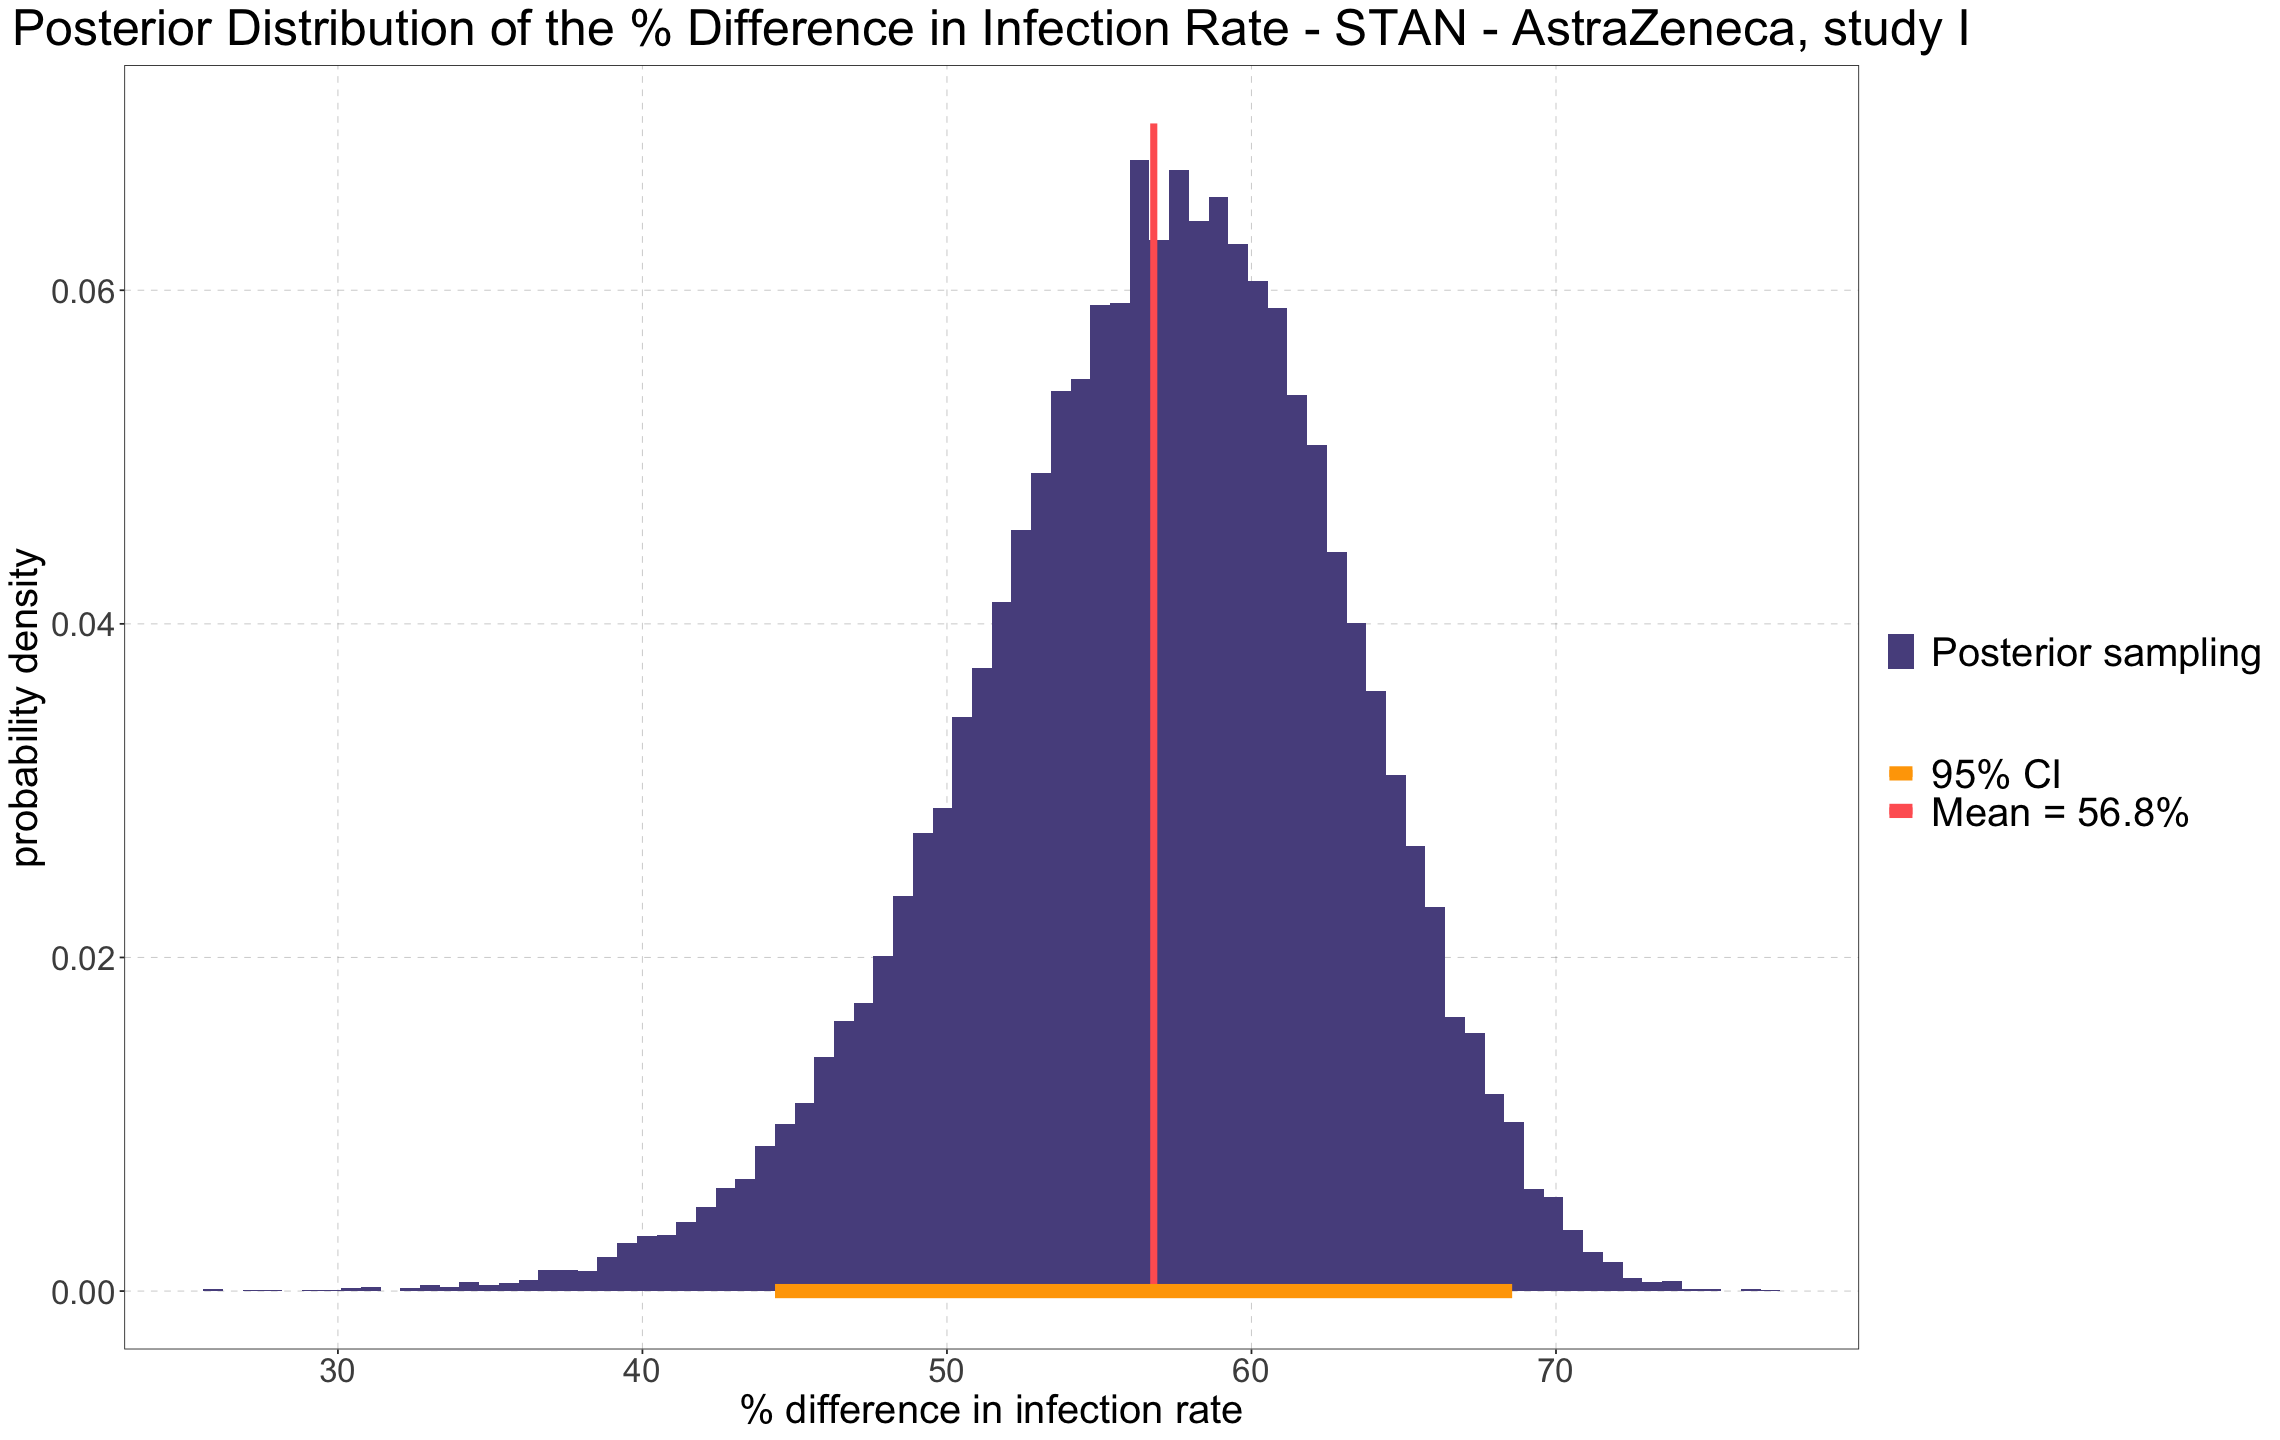

In [215]:
stan_plot(results_az1_stan, "AstraZeneca, study I", 0.07)

In [216]:
# second study 

# sample
vaccinated_az2 <- 17662
placebo_az2 <- 8550

patient_az2 <- c(
    rep("Vaccine", vaccinated_az2),
    rep("Placebo", placebo_az2)
)

pos_v_az2 <- 73
pos_p_az2 <- 130

tested_az2 <- c(
    rep("Pos", pos_v_az2),
    rep("Neg", vaccinated_az2-pos_v_az2),
    rep("Pos", pos_p_az2),
    rep("Neg", placebo_az2-pos_p_az2)
)

# organizing data
az2_tb <- tibble(tested = tested_az2, patient = patient_az2)
table(az2_tb[[2]], az2_tb[[1]])

data_az2 = list(
    tested = ifelse(az2_tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(az2_tb$patient)),
    N = nrow(az2_tb),
    Nclass = nlevels(factor(az2_tb$patient))
)

         
            Neg   Pos
  Placebo  8420   130
  Vaccine 17589    73

In [217]:
# RUNJAGS

chain_az2 <- run.jags(
    model = "vaccine_efficacy_model.bug", 
    sample = 15000,
    n.chains = 4,
    method = "parallel",
    monitor = "theta",
    data = data_az2)

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.2 on Sun Jun  4 14:48:01 2023
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 26212
   Unobserved stochastic nodes: 2
   Total graph size: 52430
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 15000
-------------------------------------------------| 15000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

In [218]:
# percentage difference in infection rates (getting a tibble)

res_az2 <- tidy_draws(chain_az2) %>%
            select('theta[1]':'theta[2]') %>%
            rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
            mutate(
                diff_rate = (Placebo-Vaccine)/Placebo * 100,
                Placebo_percent = Placebo * 100,
                Vaccine_percent = Vaccine * 100
            )

In [219]:
# coda chain results

summary(as.mcmc(res_az2))


Iterations = 1:60000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 60000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                     Mean        SD  Naive SE Time-series SE
Placebo          0.015368 0.0013251 5.410e-06      5.410e-06
Vaccine          0.004276 0.0004915 2.006e-06      2.006e-06
diff_rate       71.968981 4.0470237 1.652e-02      1.663e-02
Placebo_percent  1.536810 0.1325069 5.410e-04      5.410e-04
Vaccine_percent  0.427585 0.0491488 2.006e-04      2.006e-04

2. Quantiles for each variable:

                     2.5%       25%       50%       75%     97.5%
Placebo          0.012876  0.014460  0.015331  0.016241  0.018058
Vaccine          0.003367  0.003933  0.004259  0.004598  0.005289
diff_rate       63.250798 69.433925 72.211538 74.804025 79.136732
Placebo_percent  1.287640  1.446007  1.533115  1.624082  1.805830
Vaccine_percent  0.336691  0.393343  0.425874  0.459770  0.528912


In [220]:
# storing results

# getting 95% CI
ci_runjags_az2 <- hdi(as.mcmc(res_az2$diff_rate), prob = 0.95)

results_az2_runjags <- NULL
results_az2_runjags$rate <- res_az2$diff_rate
results_az2_runjags$mean <- mean(res_az2$diff_rate)
results_az2_runjags$rmin <- ci_runjags_az2[1]
results_az2_runjags$rmax <- ci_runjags_az2[2]

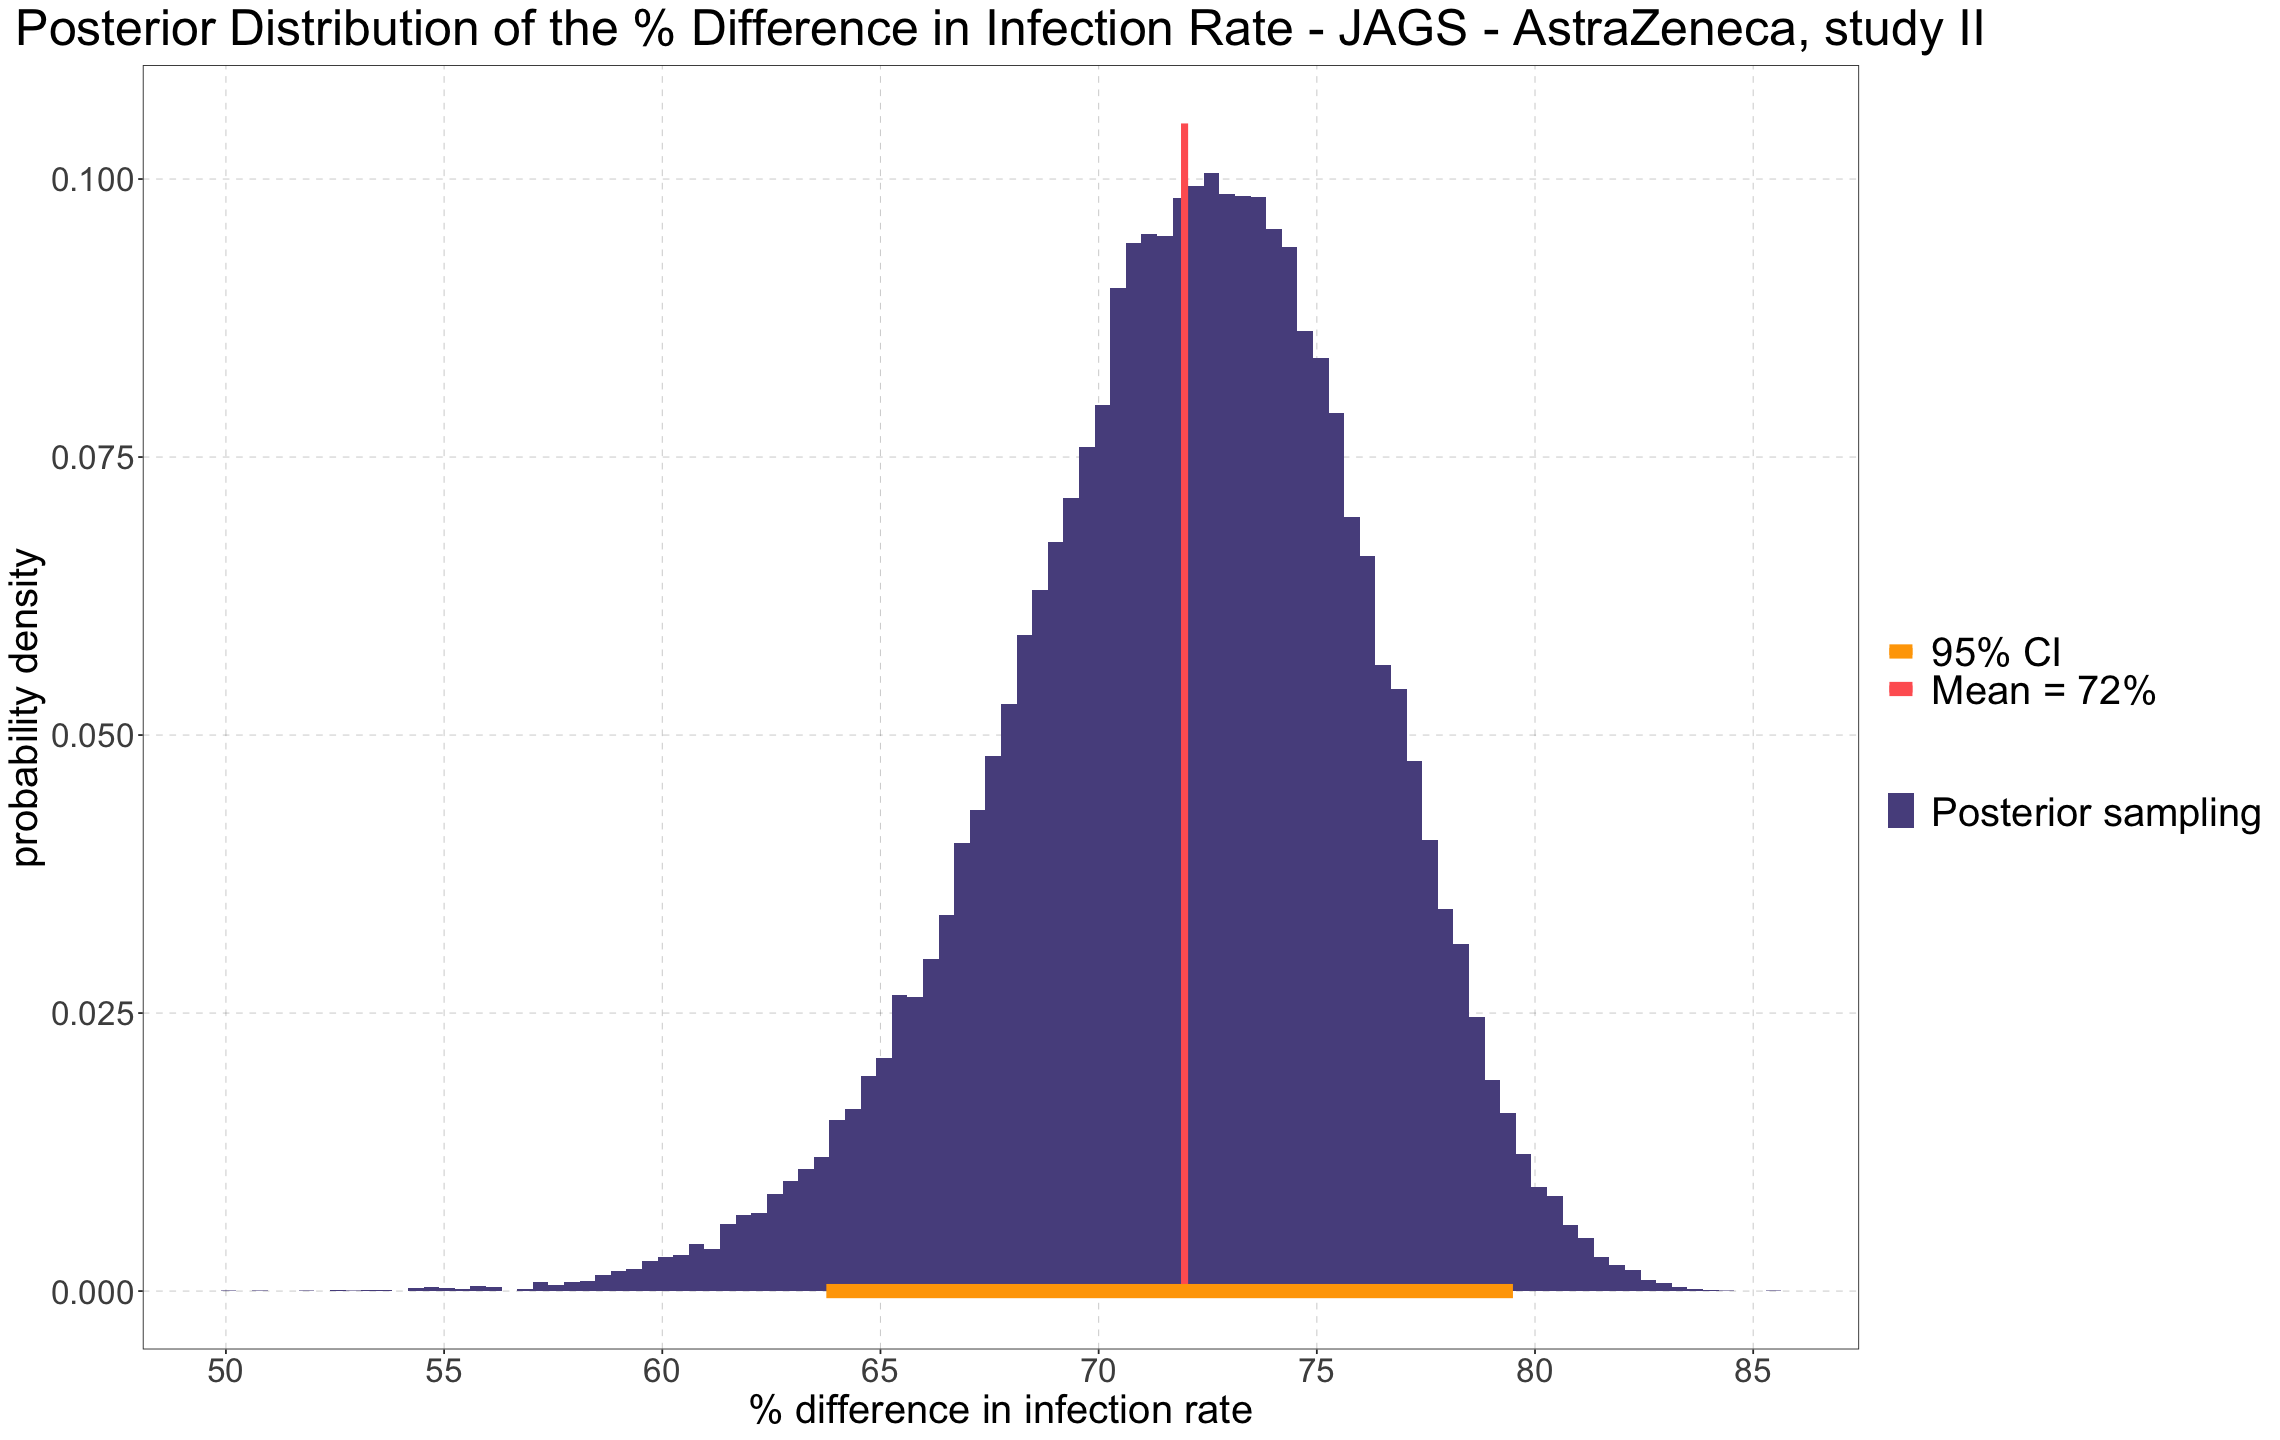

In [223]:
# plot
runjags_plot(results_az2_runjags, "AstraZeneca, study II", 0.105)

In [224]:
# STAN

# run the model with the data

fit_az2 <- sampling(
    object = stan_vaccines,
    data = data_az2,
    chains = 4,
    iter = 10000,
    warmup = 1000,
    thin = 1
)

In [225]:
# creating a tibble

tb_az2 <- as_tibble(as.data.frame(fit_az2))

# calculating percentage difference in infection rates

tb_az2 <- tb_az2 %>% rename(
            Placebo = 'theta[1]', 
            Vaccine = 'theta[2]'
        )

tb_az2 <- tb_az2 %>% transmute(
            diff_rate = (Placebo-Vaccine)/Placebo * 100,
            Placebo_percent = Placebo * 100,
            Vaccine_percent = Vaccine * 100
)

# coda chain results

summary(as.mcmc(tb_az2))


Iterations = 1:36000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 36000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                   Mean      SD  Naive SE Time-series SE
diff_rate       71.9289 4.00061 0.0210851      0.0229967
Placebo_percent  1.5369 0.13190 0.0006952      0.0007830
Vaccine_percent  0.4283 0.04854 0.0002558      0.0002727

2. Quantiles for each variable:

                   2.5%     25%     50%     75%   97.5%
diff_rate       63.3682 69.4174 72.1817 74.7458 79.0999
Placebo_percent  1.2884  1.4456  1.5336  1.6238  1.8038
Vaccine_percent  0.3379  0.3944  0.4267  0.4602  0.5279


In [226]:
# storing stan results

# getting 95% CI
ci_stan__az2 <- hdi(as.mcmc(tb_az2$diff_rate), prob = 0.95)

results_az2_stan <- NULL
results_az2_stan$rate <- tb_az2$diff_rate
results_az2_stan$mean <- mean(tb_az2$diff_rate)
results_az2_stan$rmin <- ci_stan__az2[1]
results_az2_stan$rmax <- ci_stan__az2[2]

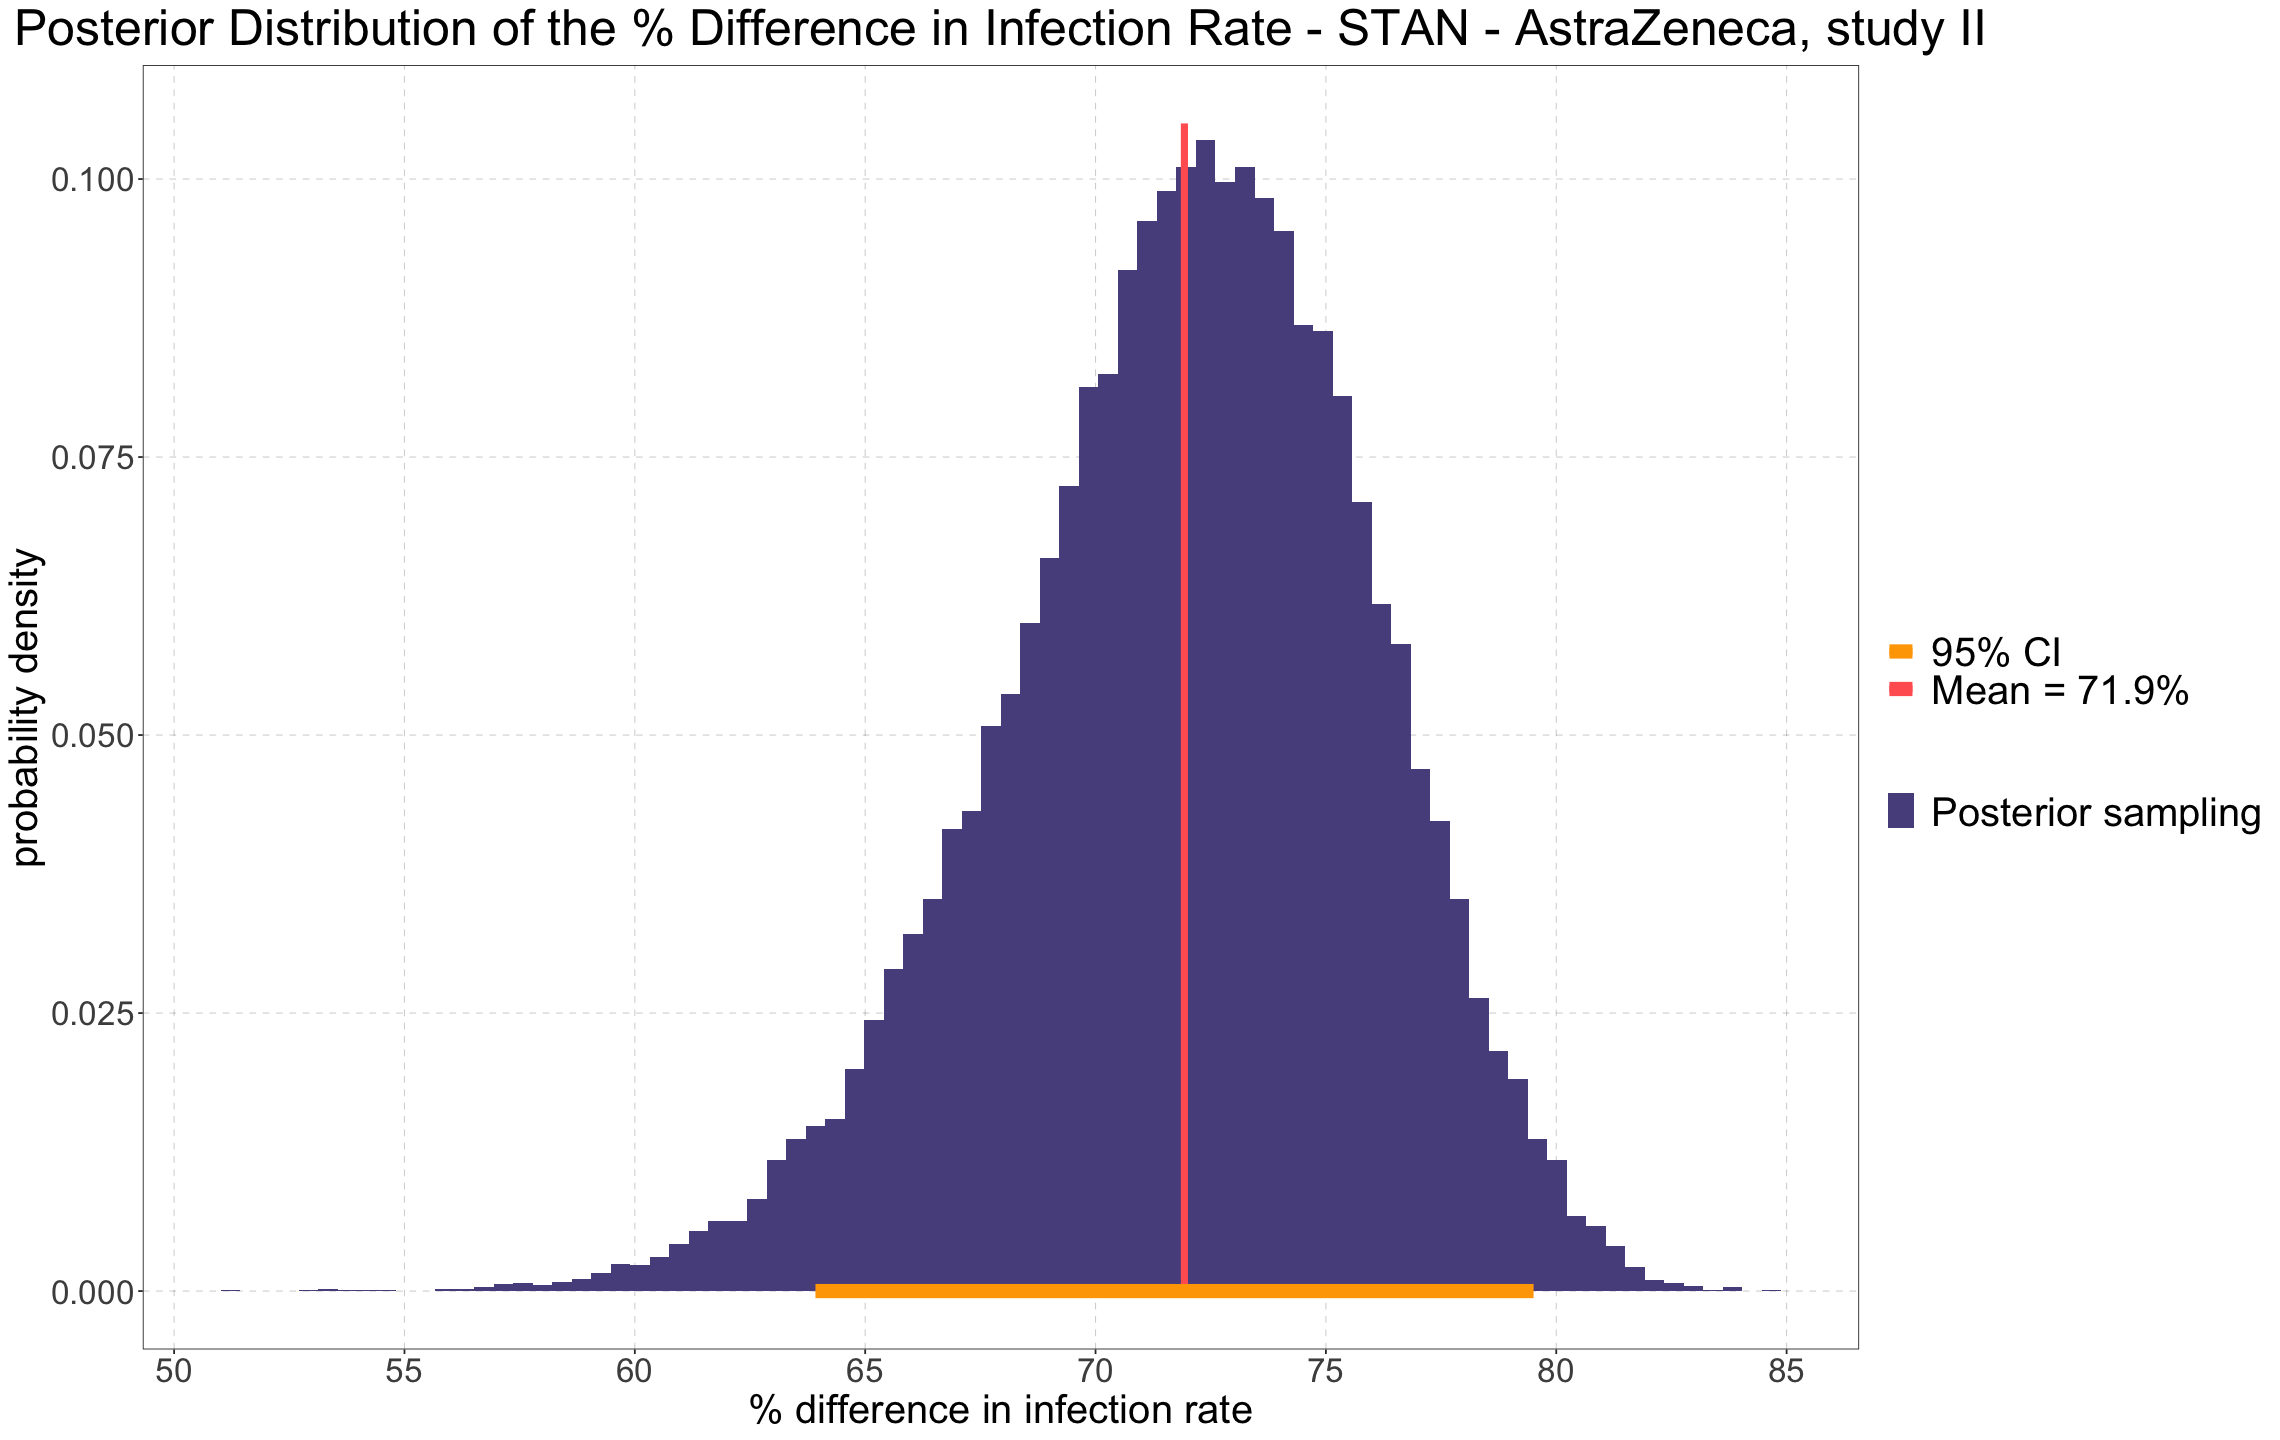

In [230]:
stan_plot(results_az2_stan, "AstraZeneca, study II", 0.105)

In conclusion, we can observe that our analysis is consistent with the result published by EMA. The small differences in the vaccine efficacies are due to our prior choice. Moreover, the results obtained with RUNJAGS and STAN are practically the same.

-----------------------

# Exercise 3

According to the official COVID-19 vaccination data, $70\%$ of the world population has received at least one dose of a COVID-19 vaccine. A global vaccination dataset is available (by OurWorldInData) and the European Centre for Disease Prevention and Control published a downloadable file containing information on COVID-19 vaccination in EU/EEA.

Analyze the data and produce the following plots:

#### 1. Number of vaccinated people (cumulative, daily and week average)

First, we analyze the full dataset collected by OurWorldInData.

In [119]:
# read and import the data
data_df <- read.csv("owid-covid-data.csv")

In [120]:
# converting to tibble
data <- as_tibble(data_df)

In [121]:
dim(data)

[1] 313070     67

In [122]:
colnames(data)

[1] "iso_code"                                  
 [2] "continent"                                 
 [3] "location"                                  
 [4] "date"                                      
 [5] "total_cases"                               
 [6] "new_cases"                                 
 [7] "new_cases_smoothed"                        
 [8] "total_deaths"                              
 [9] "new_deaths"                                
[10] "new_deaths_smoothed"                       
[11] "total_cases_per_million"                   
[12] "new_cases_per_million"                     
[13] "new_cases_smoothed_per_million"            
[14] "total_deaths_per_million"                  
[15] "new_deaths_per_million"                    
[16] "new_deaths_smoothed_per_million"           
[17] "reproduction_rate"                         
[18] "icu_patients"                              
[19] "icu_patients_per_million"                  
[20] "hosp_patients"                             
[21] "hosp_patients_per_million"                 
[22] "weekly_icu_admissions"                     
[23] "weekly_icu_admissions_per_million"         
[24] "weekly_hosp_admissions"                    
[25] "weekly_hosp_admissions_per_million"        
[26] "total_tests"                               
[27] "new_tests"                                 
[28] "total_tests_per_thousand"                  
[29] "new_tests_per_thousand"                    
[30] "new_tests_smoothed"                        
[31] "new_tests_smoothed_per_thousand"           
[32] "positive_rate"                             
[33] "tests_per_case"                            
[34] "tests_units"                               
[35] "total_vaccinations"                        
[36] "people_vaccinated"                         
[37] "people_fully_vaccinated"                   
[38] "total_boosters"                            
[39] "new_vaccinations"                          
[40] "new_vaccinations_smoothed"                 
[41] "total_vaccinations_per_hundred"            
[42] "people_vaccinated_per_hundred"             
[43] "people_fully_vaccinated_per_hundred"       
[44] "total_boosters_per_hundred"                
[45] "new_vaccinations_smoothed_per_million"     
[46] "new_people_vaccinated_smoothed"            
[47] "new_people_vaccinated_smoothed_per_hundred"
[48] "stringency_index"                          
[49] "population_density"                        
[50] "median_age"                                
[51] "aged_65_older"                             
[52] "aged_70_older"                             
[53] "gdp_per_capita"                            
[54] "extreme_poverty"                           
[55] "cardiovasc_death_rate"                     
[56] "diabetes_prevalence"                       
[57] "female_smokers"                            
[58] "male_smokers"                              
[59] "handwashing_facilities"                    
[60] "hospital_beds_per_thousand"                
[61] "life_expectancy"                           
[62] "human_development_index"                   
[63] "population"                                
[64] "excess_mortality_cumulative_absolute"      
[65] "excess_mortality_cumulative"               
[66] "excess_mortality"                          
[67] "excess_mortality_cumulative_per_million"

Let's select the variables about vaccinations, looking at their description:

- `people_vaccinated`: total number of people who received at least one vaccine dose
- `people_fully_vaccinated`: total number of people who received all doses prescribed by the initial vaccination protocol
- `new_vaccinations`: new COVID-19 vaccination doses administered (only calculated for consecutive days)
- `new_vaccinations_smoothed`: new COVID-19 vaccination doses administered (7-day smoothed). For countries that don't report vaccination data on a daily basis, we assume that vaccination changed equally on a daily basis over any periods in which no data was reported. This produces a complete series of daily figures, which is then averaged over a rolling 7-day window
- `people_vaccinated_per_hundred`: total number of people who received at least one vaccine dose per 100 people in the total population
- `people_fully_vaccinated_per_hundred`: total number of people who received all doses prescribed by the initial vaccination protocol per 100 people in the total population
- `new_vaccinations_smoothed_per_million`: new COVID-19 vaccination doses administered (7-day smoothed) per 1,000,000 people in the total population
- `new_people_vaccinated_smoothed`: daily number of people receiving their first vaccine dose (7-day smoothed)
- `new_people_vaccinated_smoothed_per_hundred`: daily number of people receiving their first vaccine dose (7-day smoothed) per 100 people in the total population

For the cumulative number of vaccinated people, we can use `people_vaccinated`, for the daily number of vaccinated people we could use `new_vaccinations` and for a weekly average of the number of vaccinated people we use `new_people_vaccinated_smoothed`. Moreover, in `location`, we can find almost every country in the world, but also the world total. So, we should select `World` between all the possible locations.

In [123]:
data <- data %>% transmute(
    location = location,
    date = as.Date(date),                   # converting to date format
    vax_c = people_vaccinated,              # cumulative
    vax_d = new_vaccinations,               # daily
    vax_w = new_people_vaccinated_smoothed  # weekly
)

In [124]:
# selecting world data 
data <- filter( data, location == "World" )

In [125]:
head(data)

location date       vax_c vax_d vax_w
1 World    2020-01-03 NA    NA    NA   
2 World    2020-01-04 NA    NA    NA   
3 World    2020-01-05 NA    NA    NA   
4 World    2020-01-06 NA    NA    NA   
5 World    2020-01-07 NA    NA    NA   
6 World    2020-01-08 NA    NA    NA

In [126]:
# filtering out NA
data <- data %>% filter(!is.na(vax_c))
data <- data %>% filter(!is.na(vax_d))
data <- data %>% filter(!is.na(vax_w))

In [128]:
dim(data)

[1] 898   5

In [127]:
head(data)

location date       vax_c vax_d vax_w
1 World    2020-12-02 0     0     0    
2 World    2020-12-03 0     1     1    
3 World    2020-12-04 1     1     1    
4 World    2020-12-05 1     1     1    
5 World    2020-12-06 1     1     1    
6 World    2020-12-07 2     1     1

In [129]:
tail(data)

location date       vax_c      vax_d  vax_w
1 World    2023-05-13 5581435014  72093 13904
2 World    2023-05-14 5581520192  71404 15336
3 World    2023-05-15 5581523985  83952 17426
4 World    2023-05-16 5581576291 163595 20239
5 World    2023-05-17 5581580861  84575  2018
6 World    2023-05-18 5581582284  77396  2090

In [157]:
# plots

plot_vax <- ggplot(data) + 
            theme_bw() + 
            theme( legend.position = "right",
            plot.title = element_text(size = 26, hjust = 0.5),
            axis.title = element_text(size = 20),
            axis.text  = element_text(size = 18),
            legend.title = element_text(size = 20, hjust = 0.5),
            legend.text  = element_text(size = 18),
            panel.grid.major.y = element_line( color = alpha("black",0.2),
                                            linewidth = 0.3,
                                            linetype = 2 ),
            panel.grid.major.x = element_line( color = alpha("black",0.2),
                                            linewidth = 0.3,
                                            linetype = 2 ),
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            legend.background = element_rect( fill = "white",
                                            linewidth = 0.5, 
                                            linetype = "solid", 
                                            colour = "grey" ) )

plot_vax_c <- plot_vax + 
              geom_line(
                aes(
                    x = date,
                    y = vax_c
                ),
                linewidth = 1.5,
                color = color_palette[2]
              ) + 
              labs( 
                x = "year", 
                y = "total number of people vaccinated", 
                title = "Cumulative number of people vaccinated over time" )

plot_vax_d <- plot_vax + 
              geom_line(
                aes(
                  x = date,
                  y = vax_d
                ),
                linewidth = 1,
                color = color_palette[3]
              ) + 
              labs( 
                x = "year", 
                y = "number of people vaccinated / day", 
                title = "Daily number of people vaccinated over time" ) 

plot_vax_w <- plot_vax +
              geom_line(
                aes(
                  x = date,
                  y = vax_w
                ),
                linewidth = 1.5,
                color = color_palette[4]
              ) +
              labs( 
                x = "year", 
                y = "number of people vaccinated / week", 
                title = "Weekly number of people vaccinated over time" ) 

In [158]:
# plot settings

std_width  <- 18
std_height <- 16
options(repr.plot.width = std_width, repr.plot.height = std_height)

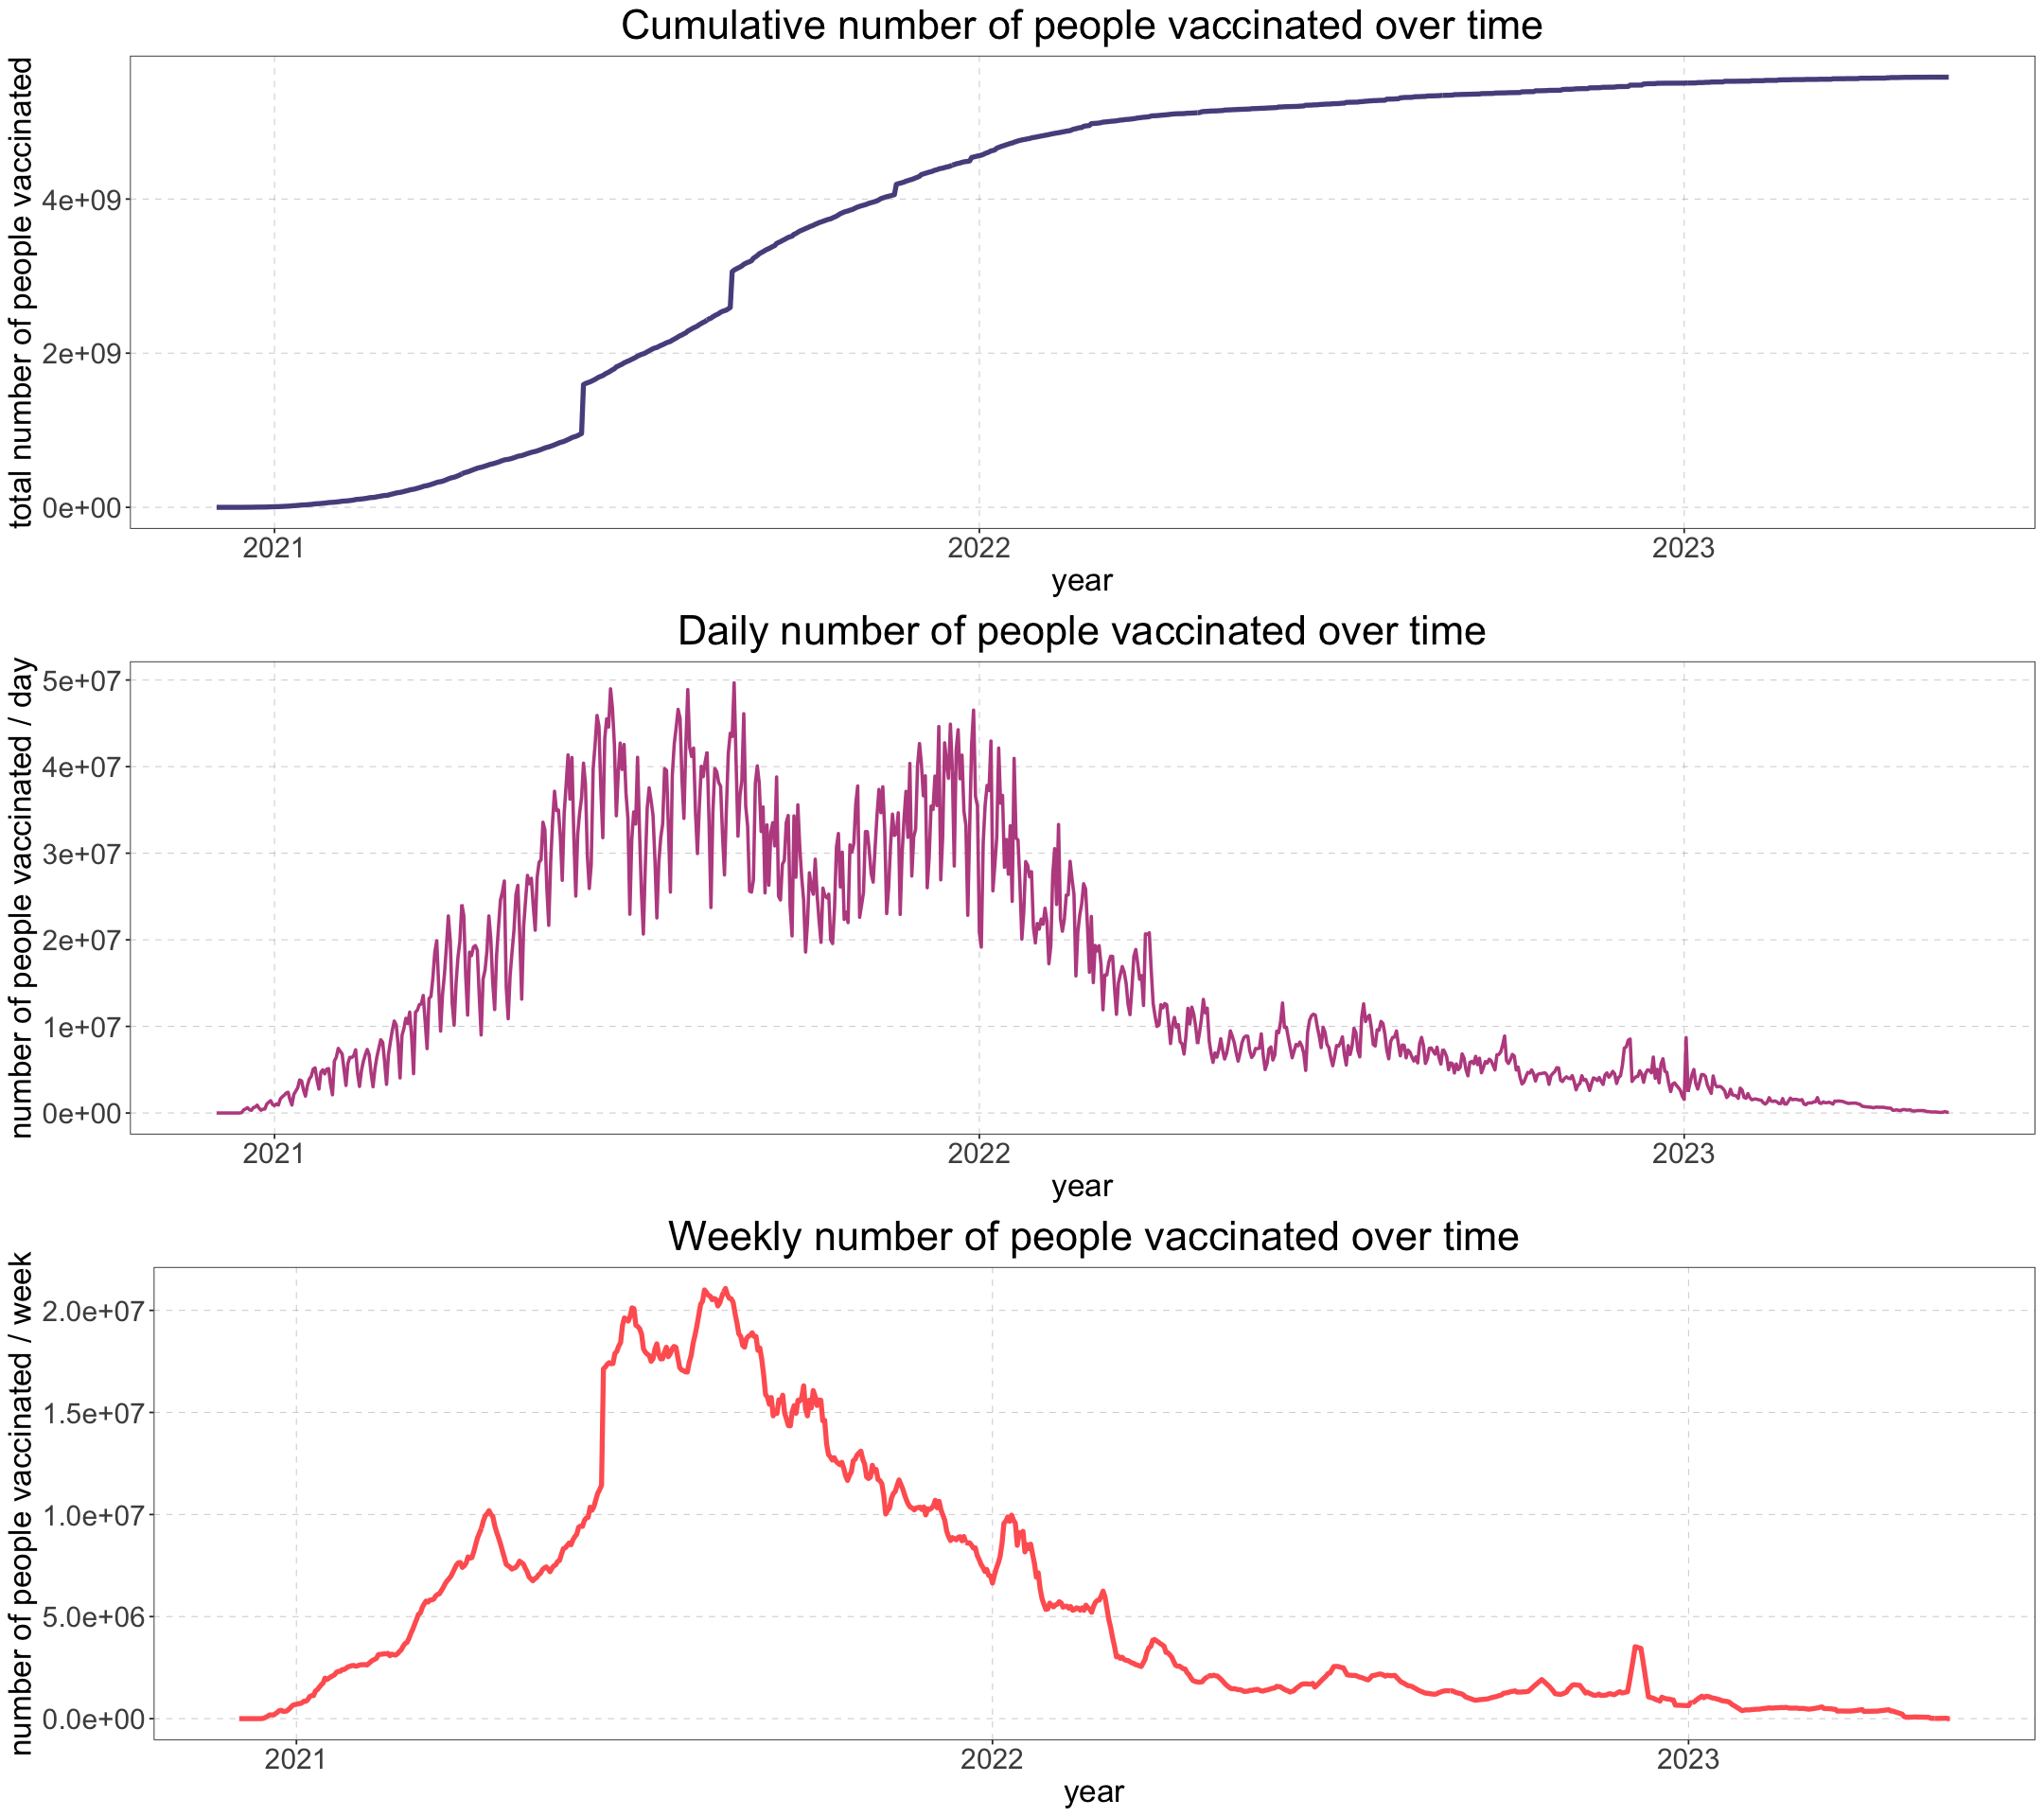

In [159]:
grid.arrange(plot_vax_c, plot_vax_d, plot_vax_w)

We could also have a look in OurWorldInData vaccinations dataset, specifically built only for vaccinations data, with some different variables and then compare it with the total dataset:

In [133]:
data_df1 <- read.csv("vaccinations.csv")

In [142]:
data1 <- as_tibble(data_df1)

In [143]:
dim(data1)

[1] 170508     16

In [144]:
colnames(data1)

[1] "location"                            "iso_code"                           
 [3] "date"                                "total_vaccinations"                 
 [5] "people_vaccinated"                   "people_fully_vaccinated"            
 [7] "total_boosters"                      "daily_vaccinations_raw"             
 [9] "daily_vaccinations"                  "total_vaccinations_per_hundred"     
[11] "people_vaccinated_per_hundred"       "people_fully_vaccinated_per_hundred"
[13] "total_boosters_per_hundred"          "daily_vaccinations_per_million"     
[15] "daily_people_vaccinated"             "daily_people_vaccinated_per_hundred"

Let's examine the variables of our interest by looking at their description:

* `total_vaccinations`: total number of doses administered. For vaccines that require multiple doses, each individual dose is counted. If a person receives one dose of the vaccine, this metric goes up by 1. If they receive a second dose, it goes up by 1 again. If they receive a third/booster dose, it goes up by 1 again.
* `people_vaccinated`: total number of people who received at least one vaccine dose. If a person receives the first dose of a 2-dose vaccine, this metric goes up by 1. If they receive the second dose, the metric stays the same.
* `daily_vaccinations_raw`: daily change in the total number of doses administered. It is only calculated for consecutive days. This is a raw measure provided for data checks and transparency, but we strongly recommend that any analysis on daily vaccination rates be conducted using `daily_vaccinations` instead.
* `daily_vaccinations`: new doses administered per day (7-day smoothed). For countries that don't report data on a daily basis, we assume that doses changed equally on a daily basis over any periods in which no data was reported.
* `daily_people_vaccinated`: daily number of people receiving a first COVID-19 vaccine dose (7-day smoothed)

For the cumulative number of vaccinated people, we can use `people_vaccinated`, `daily_vaccinations_raw` for the daily number, and both `daily_vaccinations` and `daily_people_vaccinated` for the weekly (so we can also compare them). Moreover, we select `World` among the possible `locations`.

In [145]:
data1 <- data1 %>% transmute(
    location = location,
    date = as.Date(date),
    cVax = people_vaccinated,           # cumulative
    dVax = daily_vaccinations_raw,      # daily
    wVax1 = daily_vaccinations,         # weekly
    wVax2 = daily_people_vaccinated     # weekly
)

In [146]:
data1 <- filter( data1, location == "World" )

In [147]:
dim(data1)

[1] 908   6

In [148]:
head(data1)

location date       cVax dVax wVax1 wVax2
1 World    2020-12-02 0    0    0     0    
2 World    2020-12-03 0    1    1     1    
3 World    2020-12-04 1    1    1     1    
4 World    2020-12-05 1    1    1     1    
5 World    2020-12-06 1    1    1     1    
6 World    2020-12-07 2    1    1     1

In [149]:
# filtering out NA
data1 <- data1 %>% filter(!is.na(cVax))
data1 <- data1 %>% filter(!is.na(dVax))
data1 <- data1 %>% filter(!is.na(wVax1))
data1 <- data1 %>% filter(!is.na(wVax2))

In [150]:
dim(data1)

[1] 902   6

In [151]:
head(data1)

location date       cVax dVax wVax1 wVax2
1 World    2020-12-02 0    0    0     0    
2 World    2020-12-03 0    1    1     1    
3 World    2020-12-04 1    1    1     1    
4 World    2020-12-05 1    1    1     1    
5 World    2020-12-06 1    1    1     1    
6 World    2020-12-07 2    1    1     1

In [152]:
tail(data1)

location date       cVax       dVax   wVax1  wVax2
1 World    2023-05-17 5581711794 251810 182312 43098
2 World    2023-05-18 5581713270 244883 193042 48254
3 World    2023-05-19 5581718315 244504 204906 53490
4 World    2023-05-20 5581719466 194529 208947 58458
5 World    2023-05-21 5582356898 192502 217334 63604
6 World    2023-05-22 5582360209 116301  87222  2818

In [190]:
# plots

plot_vax1 <- ggplot(data1) + 
            theme_bw() + 
            theme( legend.position = "top",
            plot.title = element_text(size = 26, hjust = 0.5),
            axis.title = element_text(size = 20),
            axis.text  = element_text(size = 18),
            legend.title = element_text(size = 20, hjust = 0.5),
            legend.text  = element_text(size = 18),
            panel.grid.major.y = element_line( color = alpha("black",0.2),
                                            linewidth = 0.3,
                                            linetype = 2 ),
            panel.grid.major.x = element_line( color = alpha("black",0.2),
                                            linewidth = 0.3,
                                            linetype = 2 ),
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            legend.background = element_rect( fill = "white",
                                            linewidth = 0.5, 
                                            linetype = "solid", 
                                            colour = "white" ) )

plot_vax_c1 <- plot_vax1 + 
               geom_line(
                aes(
                    x = date,
                    y = cVax
                ),
                linewidth = 1.5,
                color = color_palette[2]
               ) + 
               labs( 
                x = "year", 
                y = "total number of people vaccinated", 
                title = "Cumulative number of people vaccinated over time" )

plot_vax_d1 <- plot_vax1 + 
               geom_line(
                aes(
                    x = date,
                    y = dVax
                ),
                linewidth = 1,
                color = color_palette[3]
               ) + 
               labs( 
                x = "year", 
                y = "number of people vaccinated / day", 
                title = "Daily number of people vaccinated over time" )

plot_vax_w1 <- plot_vax1 + 
               geom_line(
                aes(
                    x = date,
                    y = wVax1,
                    color = "Daily vaccinations"
                ),
                linewidth = 1.5
               ) + 
               geom_line(
                aes(
                    x = date,
                    y = wVax2,
                    color = "Daily people vaccinated"
                ),
                linewidth = 1.5
               ) +
               labs( 
                x = "year", 
                y = "number of people vaccinated / week", 
                title = "Weekly number of people vaccinated over time" ) +
               scale_color_manual( 
                                    name = "",
                                    values = c("Daily vaccinations" = color_palette[1], "Daily people vaccinated" = color_palette[4]))

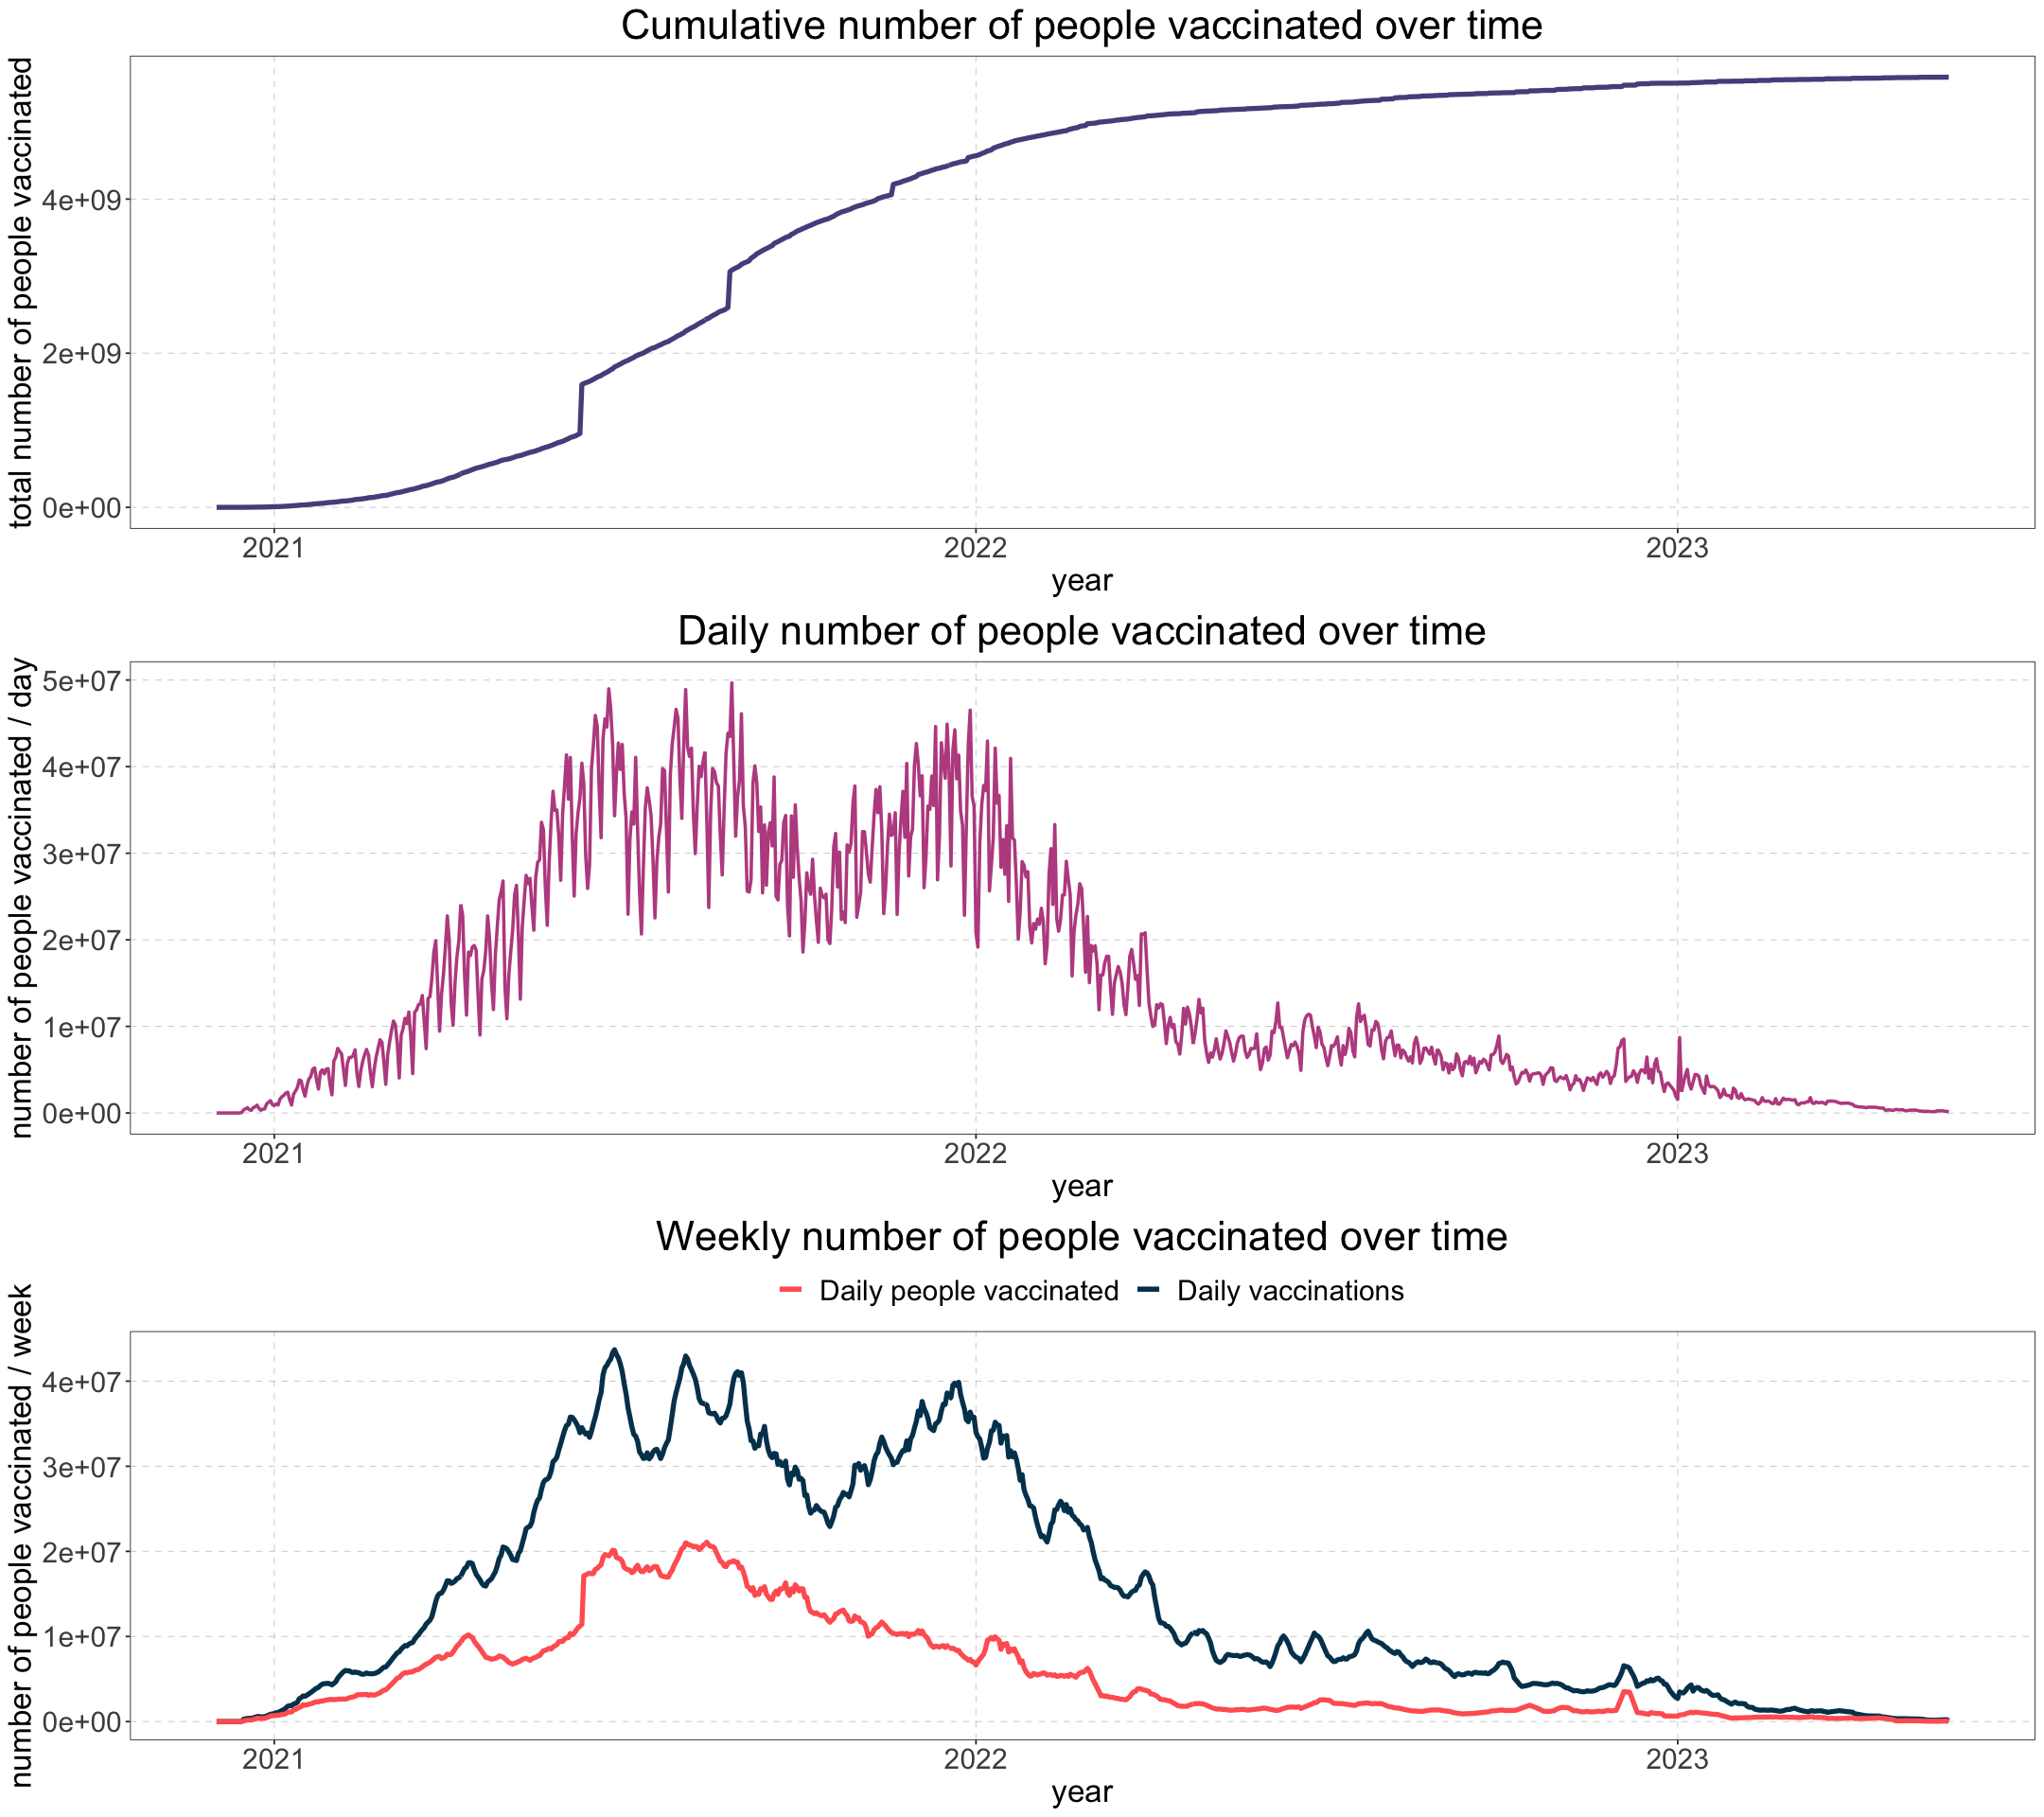

In [191]:
grid.arrange(plot_vax_c1, plot_vax_d1, plot_vax_w1)

We can compare these plot with the previous ones: the only different data is that one corresponding to `daily_vaccinations`, not present in the previous dataset. We can make the assumption that `daily_vaccinations` data also includes vaccine doses higher than the first, while in `daily_people_vaccinated` data there are only data of first vaccine dose. So `daily_vaccinations` are always higher then `daily_people_vaccinated` because they include also boosters. Moreover, `new_vaccinations` from the complete dataset is equal to the number of people vaccinated every day.

#### 2. Number of confirmed deaths by COVID-19, both cumulative and weekly average

From the complete dataset, we analyze the variables of our interest in this case:
* `total_deaths`: total deaths attributed to COVID-19. Counts can include probable deaths, where reported.
* `new_deaths`: new deaths attributed to COVID-19. Counts can include probable deaths, where reported. In rare cases where our source reports a negative daily change due to a data correction, we set this metric to NA.
* `new_deaths_smoothed`: new deaths attributed to COVID-19 (7-day smoothed). Counts can include probable deaths, where reported.

For the cumulative number of deaths, we can use `total_deaths` and `new_deaths_smoothed` for the weekly average. Moreover, we select `World` among `locations`.

In [176]:
# creating a tibble
data_d <- as_tibble(data_df)

In [177]:
data_d <- data_d %>% transmute(
    location = location,
    date = as.Date(date),           # date format
    deaths_c = total_deaths,        # cumulative
    deaths_w = new_deaths_smoothed  # weekly
)

In [178]:
# selecting world data
data_d <- filter(data_d, location == "World")

In [179]:
head(data_d)

location date       deaths_c deaths_w
1 World    2020-01-03 NA       NA      
2 World    2020-01-04 NA       NA      
3 World    2020-01-05 NA       NA      
4 World    2020-01-06 NA       NA      
5 World    2020-01-07 NA       NA      
6 World    2020-01-08 NA        0

In [180]:
# filtering out NA
data_d <- data_d %>% filter(!is.na(deaths_c))
data_d <- data_d %>% filter(!is.na(deaths_w))

In [181]:
dim(data_d)

[1] 1229    4

In [182]:
head(data_d)

location date       deaths_c deaths_w
1 World    2020-01-12 1        0.143   
2 World    2020-01-13 1        0.143   
3 World    2020-01-14 1        0.143   
4 World    2020-01-15 1        0.143   
5 World    2020-01-16 1        0.143   
6 World    2020-01-17 2        0.286

In [183]:
tail(data_d)

location date       deaths_c deaths_w
1 World    2023-05-19 6934779  609.286 
2 World    2023-05-20 6934951  604.714 
3 World    2023-05-21 6935527  282.429 
4 World    2023-05-22 6935837  289.143 
5 World    2023-05-23 6935876  257.286 
6 World    2023-05-24 6935876  236.571

In [186]:
# plots

plot_d <- ggplot(data_d) +
        theme_bw() + 
        theme( legend.position = "top",
        plot.title = element_text(size = 26, hjust = 0.5),
        axis.title = element_text(size = 20),
        axis.text  = element_text(size = 18),
        legend.title = element_text(size = 20, hjust = 0.5),
        legend.text  = element_text(size = 18),
        panel.grid.major.y = element_line( color = alpha("black",0.2),
                                        linewidth = 0.3,
                                        linetype = 2 ),
        panel.grid.major.x = element_line( color = alpha("black",0.2),
                                        linewidth = 0.3,
                                        linetype = 2 ),
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        legend.background = element_rect( fill = "white",
                                        linewidth = 0.5, 
                                        linetype = "solid", 
                                        colour = "white" ) )

plot_d_c <- plot_d +
            geom_line(
                aes(
                    x = date,
                    y = deaths_c
                ),
                linewidth = 1.5,
                color = color_palette[2]
            ) + 
            labs( 
                x = "year", 
                y = "total number of deaths", 
                title = "Cumulative number of deaths over time" )

plot_d_w <- plot_d +
            geom_line(
                aes(
                    x = date,
                    y = deaths_w
                ),
                linewidth = 1.5,
                color = color_palette[3]
            ) +
            labs( 
                x = "year", 
                y = "number of deaths / week", 
                title = "Weekly number of deaths over time" )

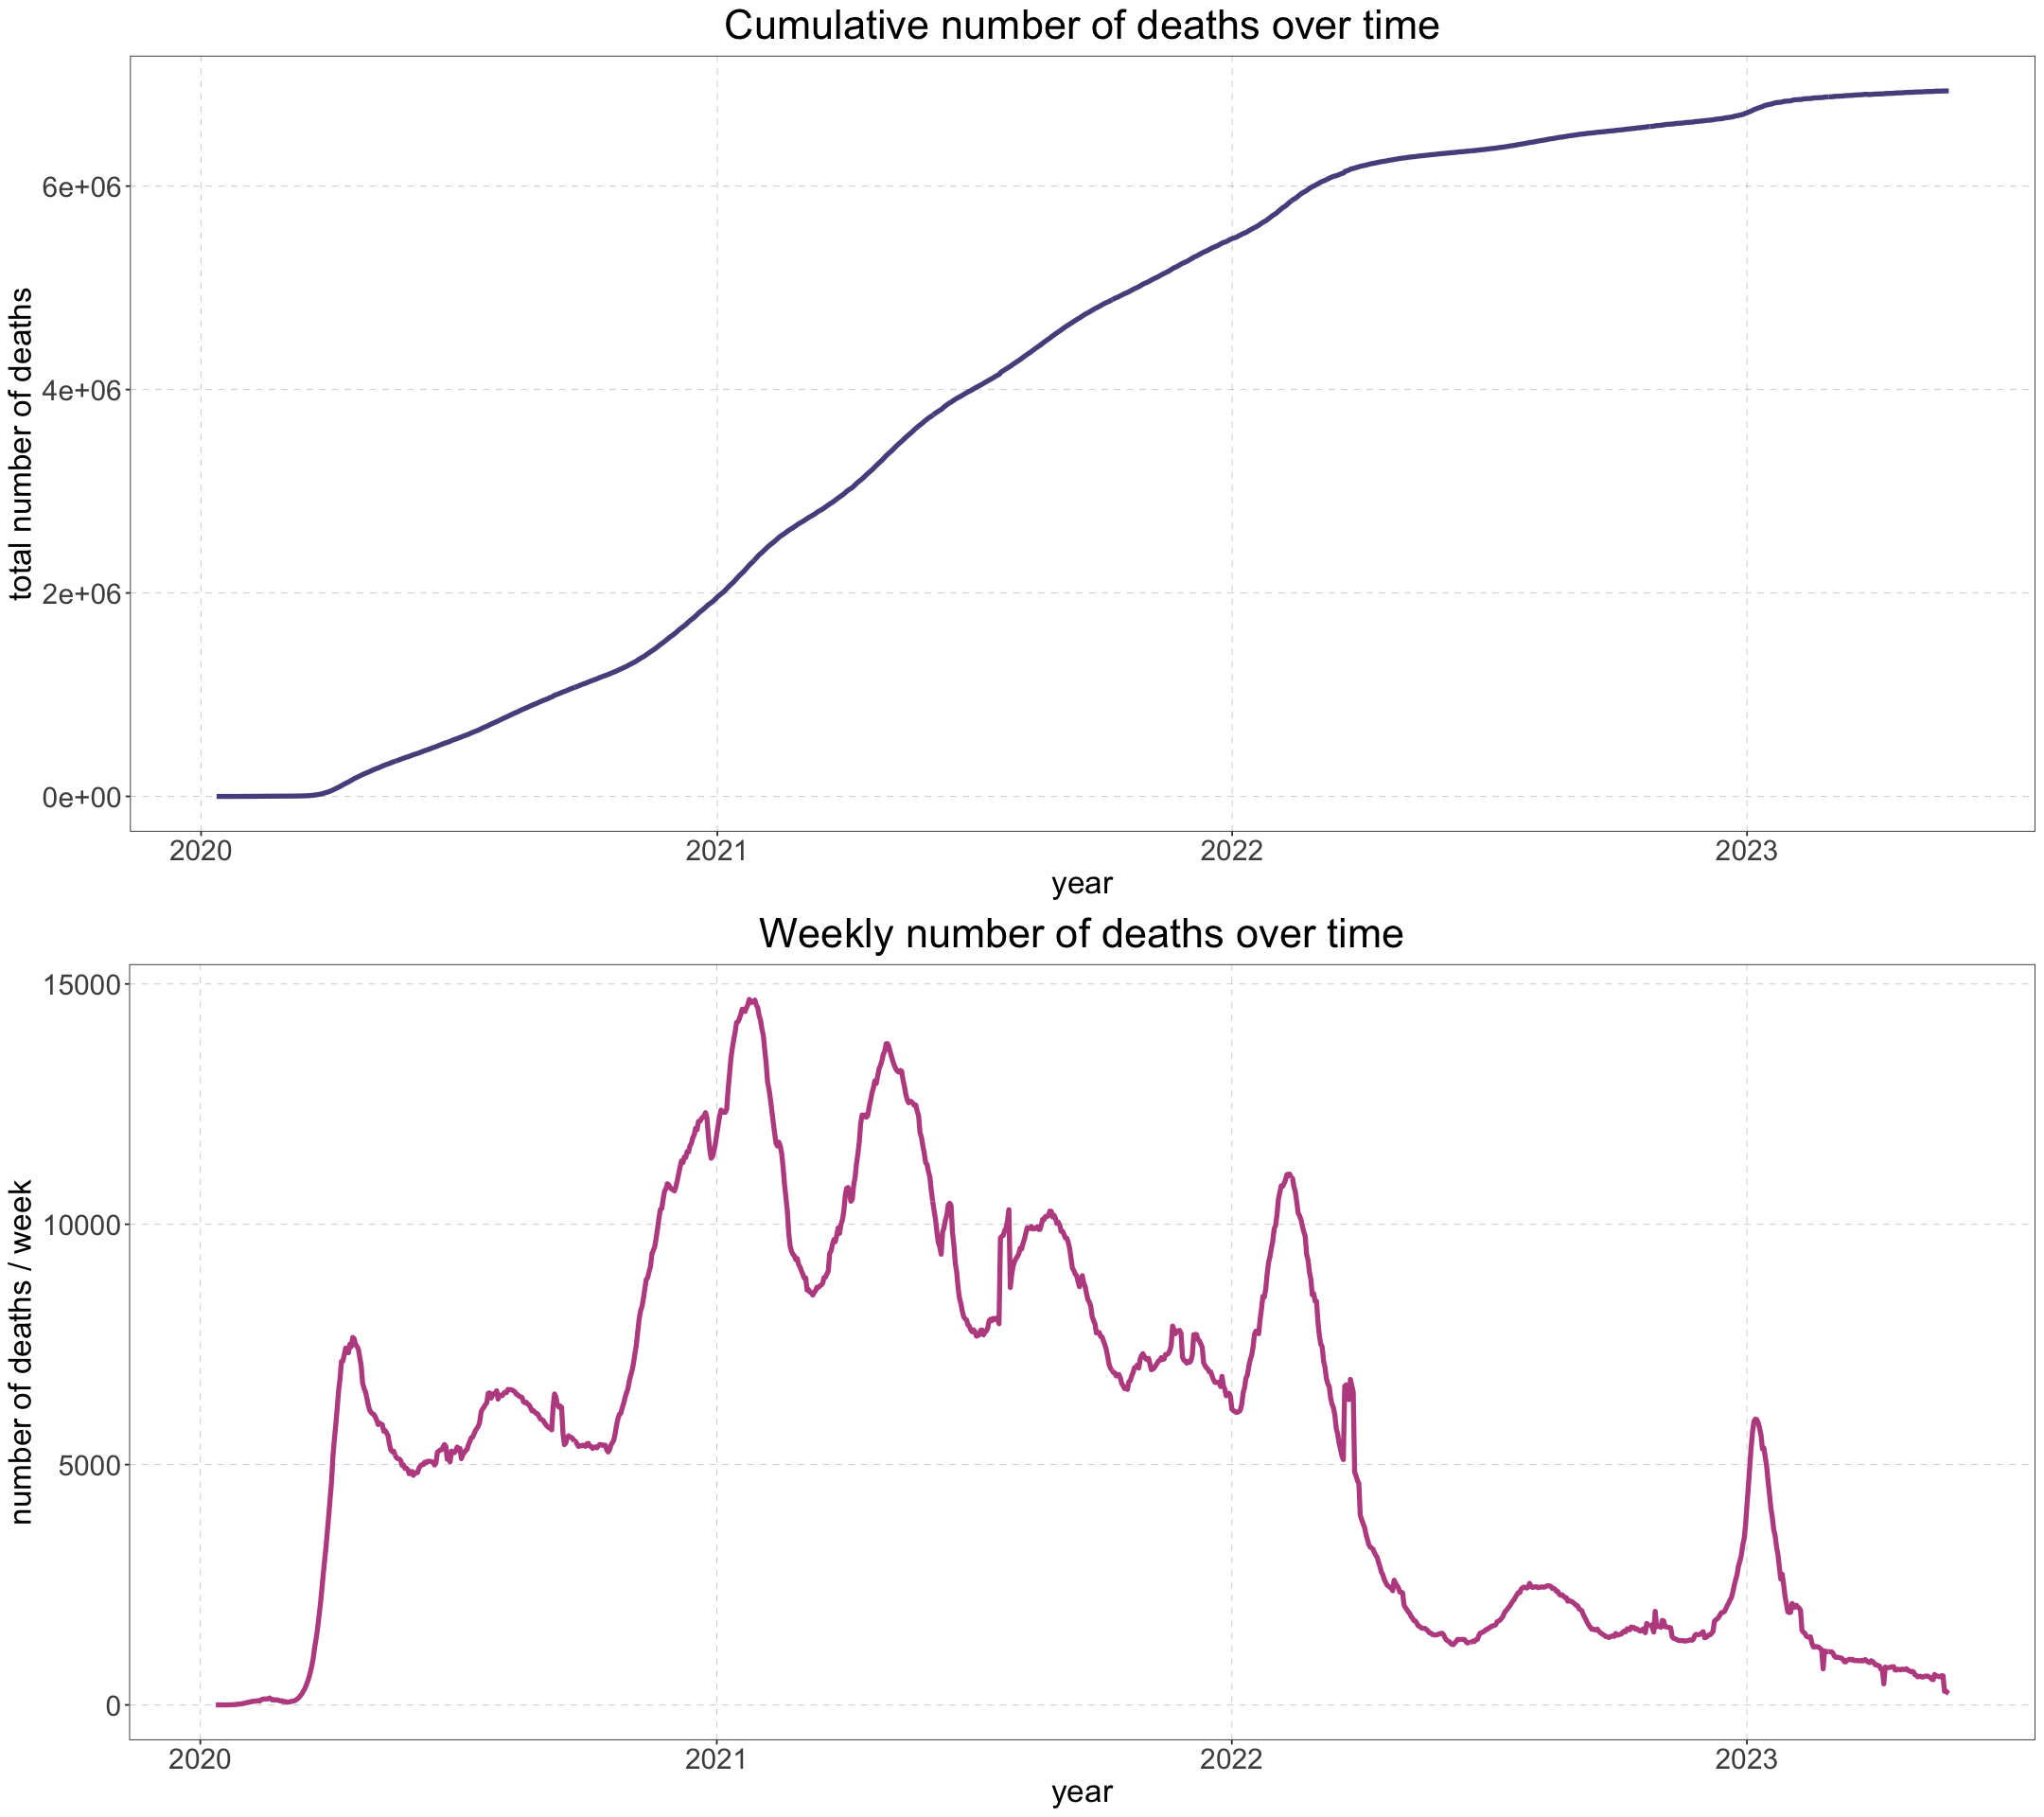

In [187]:
grid.arrange(plot_d_c, plot_d_w)